In [1]:
import json
import os
import glob
import pickle
import pandas as pd
pd.set_option('display.max_colwidth', None)
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import re

import numpy as np
from collections import Counter, defaultdict
import random
import math
from tqdm import tqdm
import platform

# print machine name
machine_name = platform.node().split(".")[0]
print(machine_name)

# print available scratch directories
print(" ".join(os.listdir(f"/{machine_name}")))
scr_dir = os.listdir(f"/{machine_name}")[0]

DISK_IO_DIR = "/{}/{}/yiweil".format(machine_name,scr_dir)
print(DISK_IO_DIR)
if not os.path.exists(DISK_IO_DIR):
    os.mkdir(DISK_IO_DIR)

john10
scr1
/john10/scr1/yiweil


# Load utils

In [2]:
from cleantext import clean

clean_str = lambda s: clean(s,
                            fix_unicode=True,               # fix various unicode errors
                            to_ascii=True,                  # transliterate to closest ASCII representation
                            lower=True,                     # lowercase text
                            no_line_breaks=True,           # fully strip line breaks as opposed to only normalizing them
                            no_urls=True,                  # replace all URLs with a special token
                            no_emails=True,                # replace all email addresses with a special token
                            no_phone_numbers=True,         # replace all phone numbers with a special token
                            no_numbers=False,               # replace all numbers with a special token
                            no_digits=False,                # replace all digits with a special token
                            no_currency_symbols=True,      # replace all currency symbols with a special token
                            no_punct=False,                 # fully remove punctuation
                            replace_with_url="<URL>",
                            replace_with_email="<EMAIL>",
                            replace_with_phone_number="<PHONE>",
                            replace_with_number="<NUMBER>",
                            replace_with_digit="0",
                            replace_with_currency_symbol="<CUR>",
                            lang="en"
                            )

In [3]:
STANZA_DIR='/u/scr/yiweil/Green-American-Lexicon/2_data_exploration/combined_stanza_output_with_ner'

# Loads stanza-processed json object if utterance text is non-empty and not a single '/' or '-'
def get_stanza_json(utt,
    stanza_dir='/u/scr/yiweil/Green-American-Lexicon/2_data_exploration/combined_stanza_output_with_ner'):
    if len(utt.text) > 0 and utt.text != '-' and utt.text != '/':
        return json.load(open(os.path.join(stanza_dir,f'{utt.id}.json'),'r'))

In [59]:
from sklearn.feature_extraction.text import CountVectorizer

def get_lemmas_with_heads(stanza_json_parse, exclude_punc=True):
    if exclude_punc:
        return [f"{w['lemma']}_{stanza_json_parse[ix_sent][int(w['head'])-1]['lemma']}"
                if w['lemma'] is not None 
                else f"{w['text']}_{stanza_json_parse[ix_sent][int(w['head'])-1]['text']}"
                for ix_sent,sent in enumerate(stanza_json_parse)
                for w in sent if w['upos'] != 'PUNCT']
    else:
        return [f"{w['lemma']}_{stanza_json_parse[ix_sent][int(w['head'])-1]['lemma']}"
                if w['lemma'] is not None 
                else f"{w['text']}_{stanza_json_parse[ix_sent][int(w['head'])-1]['text']}"
                for ix_sent,sent in enumerate(stanza_json_parse)
                for w in sent]

def get_counts_for_lor(corpus, sample1_ids, priors, save_prefix, 
                       stanza_dir='/u/scr/yiweil/Green-American-Lexicon/2_data_exploration/combined_stanza_output_with_ner',
                       verbose=False, cache=True, background_only=False, skip_background=False,
                       ngram_range=(1,2), min_df=5, do_lowercase=True, 
                       upos=False, xpos=False, depparse=True, heads=False):
    
    if not cache:
        counts_dict = {}
        if not background_only:
            print(f"Creating count matrix for +/- samples with ngram range {ngram_range}, min_df = {min_df}, lowercasing = {do_lowercase}, upos = {upos}, xpos = {xpos}, depparse = {depparse}, and heads = {heads}...")

            # create text arrays
            corpus1_texts, corpus2_texts = [], []
            for utt in tqdm(corpus.iter_utterances()):
                json_obj = get_stanza_json(utt,stanza_dir=stanza_dir)
                if json_obj is not None:
                    if utt.id in sample1_ids:
                        if upos:
                            corpus1_texts.append(' '.join([f"{x['lemma']}_{x['upos']}" 
                                                           if x['lemma'] is not None 
                                                           else f"{x['text']}_{x['upos']}"
                                                           for sent in json_obj['parse']
                                                           for x in sent if x['upos'] != 'PUNCT']))
                        elif xpos:
                            corpus1_texts.append(' '.join([f"{x['lemma']}_{x['xpos']}" 
                                                           if x['lemma'] is not None 
                                                           else f"{x['text']}_{x['xpos']}"
                                                           for sent in json_obj['parse']
                                                           for x in sent if x['upos'] != 'PUNCT']))
                        elif depparse:
                            corpus1_texts.append(' '.join([f"{x['lemma']}_{x['deprel']}" 
                                                           if x['lemma'] is not None 
                                                           else f"{x['text']}_{x['deprel']}"
                                                           for sent in json_obj['parse']
                                                           for x in sent if x['upos'] != 'PUNCT']))
                        elif heads:
                            corpus1_texts.append(' '.join(get_lemmas_with_heads(json_obj['parse'])))
                        else:
                            corpus1_texts.append(' '.join([x['lemma'] 
                                                           if x['lemma'] is not None 
                                                           else x['text']
                                                           for sent in json_obj['parse']
                                                           for x in sent if x['upos'] != 'PUNCT']))
                    else:
                        if upos:
                            corpus2_texts.append(' '.join([f"{x['lemma']}_{x['upos']}" 
                                                           if x['lemma'] is not None 
                                                           else f"{x['text']}_{x['upos']}"
                                                           for sent in json_obj['parse']
                                                           for x in sent if x['upos'] != 'PUNCT']))
                        elif xpos:
                            corpus2_texts.append(' '.join([f"{x['lemma']}_{x['xpos']}" 
                                                           if x['lemma'] is not None 
                                                           else f"{x['text']}_{x['xpos']}"
                                                           for sent in json_obj['parse']
                                                           for x in sent if x['upos'] != 'PUNCT']))
                        elif depparse:
                            corpus2_texts.append(' '.join([f"{x['lemma']}_{x['deprel']}"
                                                           if x['lemma'] is not None 
                                                           else f"{x['text']}_{x['deprel']}"
                                                           for sent in json_obj['parse']
                                                           for x in sent if x['upos'] != 'PUNCT']))
                        elif heads:
                            corpus2_texts.append(' '.join(get_lemmas_with_heads(json_obj['parse'])))
                        else:
                            corpus2_texts.append(' '.join([x['lemma'] 
                                                           if x['lemma'] is not None 
                                                           else x['text']
                                                           for sent in json_obj['parse']
                                                           for x in sent if x['upos'] != 'PUNCT']))
            del corpus # free up memory
            print(f'\tFound {len(corpus1_texts)} non-empty texts in sample 1; {len(corpus2_texts)} non-empty texts in sample 2.')
            if verbose:
                print('\tExample corpus1 texts:',corpus1_texts[:3])
                print('\tExample corpus2 texts:',corpus2_texts[:3])

            # create; save count dictionaries from CV
            for corp_ in ['corpus1','corpus2']:
                vectorizer = CountVectorizer(analyzer='word', ngram_range=ngram_range, 
                                             min_df=min_df, lowercase=do_lowercase)
                X = vectorizer.fit_transform(corpus1_texts) if corp_ == 'corpus1' \
                    else vectorizer.fit_transform(corpus2_texts)
                vocab = vectorizer.get_feature_names()
                counts = np.sum(X,axis=0)
                count_dict = Counter({vocab[i]: counts[0,i] for i in range(len(vocab))
                                  if len(vocab[i]) > 0})
                counts_dict[corp_] = count_dict
                savename = os.path.join('lor_count_mats',
                                     f'{save_prefix}_{corp_}_ngrams={ngram_range}_min_df={min_df}_lowercase={do_lowercase}_upos={upos}_xpos={xpos}_depparse={depparse}_heads={heads}')
    #             if not os.path.exists('lor_count_mats'):
    #                 os.mkdir('lor_count_mats')
                pickle.dump(count_dict,open(savename,'wb'))
                print(f"\tSaved counts of {corp_} (N types = {len(count_dict)}) to {savename}.")
        else:
            print("Skipping directly to creation of background corpus counts matrices.")
        
        if not skip_background:
            # create texts array
            prior_texts = []
            for prior_corp in priors:
                for utt in tqdm(prior_corp.iter_utterances()):
                    json_obj = get_stanza_json(utt)
                    if json_obj is not None:
                        if upos:
                            prior_texts.append(' '.join([f"{x['lemma']}_{x['upos']}" 
                                                         if x['lemma'] is not None 
                                                         else f"{x['text']}_{x['upos']}"
                                                         for sent in json_obj['parse']
                                                         for x in sent if x['upos'] != 'PUNCT']))
                        elif xpos:
                            prior_texts.append(' '.join([f"{x['lemma']}_{x['xpos']}" 
                                                         if x['lemma'] is not None 
                                                        else f"{x['text']}_{x['xpos']}"
                                                         for sent in json_obj['parse']
                                                         for x in sent if x['upos'] != 'PUNCT']))
                        elif depparse:
                            prior_texts.append(' '.join([f"{x['lemma']}_{x['deprel']}" 
                                                         if x['lemma'] is not None 
                                                           else f"{x['text']}_{x['deprel']}"
                                                           for sent in json_obj['parse']
                                                           for x in sent if x['upos'] != 'PUNCT']))
                        elif heads:
                            prior_texts.append(' '.join(get_lemmas_with_heads(json_obj['parse'])))
                        else:
                            prior_texts.append(' '.join([x['lemma'] 
                                                         if x['lemma'] is not None 
                                                           else x['text']
                                                         for sent in json_obj['parse']
                                                         for x in sent if x['upos'] != 'PUNCT']))
                del prior_corp # free up memory when done iterating
            del priors # free up memory when done iterating
            #del corp_to_analyze['switchboard']
            #del corp_to_analyze['gen_reddit']
            if verbose:
                print('Example prior corpus texts:',prior_texts[:3])

            # create; save count dictionary
            if len(prior_texts) > 0:
                vectorizer_prior = CountVectorizer(analyzer='word', ngram_range=ngram_range, min_df=min_df, 
                                                   lowercase=do_lowercase)
                X_prior = vectorizer_prior.fit_transform(prior_texts)
                vocab_prior = vectorizer_prior.get_feature_names()
                print(len(vocab_prior))
                #pickle.dump(X_prior,open('X_prior.pkl','wb'))
                counts_prior = np.sum(X_prior,axis=0)
                count_dict_prior = Counter({vocab_prior[i]: counts_prior[0,i] for i in range(len(vocab_prior))
                                   if len(vocab_prior[i]) > 0})
                counts_dict['prior'] = count_dict_prior

                savename_prior = os.path.join('lor_count_mats',
                                         f'{save_prefix}_prior_ngrams={ngram_range}_min_df={min_df}_lowercase={do_lowercase}_upos={upos}_xpos={xpos}_depparse={depparse}_heads={heads}')
                pickle.dump(count_dict_prior,open(savename_prior,'wb'))
                print(f"\tSaved counts of prior (N types = {len(count_dict_prior)}) to {savename_prior}.")
            else:
                print("\tNo prior corpora passed.")
                counts_dict['prior'] = Counter()
        
        return counts_dict
        
    else:
        print("Loading counters from cache...")
        counts_dict = {}
        for save_infix in ['corpus1','corpus2','prior']:
            savename = os.path.join('lor_count_mats',
                                 f'{save_prefix}_{save_infix}_ngrams={ngram_range}_min_df={min_df}_lowercase={do_lowercase}_upos={upos}_xpos={xpos}_depparse={depparse}_heads={heads}')
            try:
                counts_dict[save_infix] = pickle.load(open(savename,'rb'))
            except FileNotFoundError:
                pass
        return counts_dict        

In [41]:
PRIOR_WEIGHT = 1
COUNTS1_WEIGHT = 1 # use for +delta
COUNTS2_WEIGHT = 1

def do_weighted_lor(counts1, counts2, counts_prior, 
                    prior_weight=PRIOR_WEIGHT, counts1_weight=COUNTS1_WEIGHT, counts2_weight=COUNTS2_WEIGHT, 
                    verbose=False):
    
    counts1,counts2 = counts1.copy(),counts2.copy()
    if type(counts1) != Counter:
        counts1 = Counter(counts1)
        counts2 = Counter(counts2)
    prior = counts_prior + counts1 + counts2

    sigmasquared = defaultdict(float)
    sigma = defaultdict(float)
    delta = defaultdict(float)

    for word in prior.keys():
        prior[word] = int(prior[word]/prior_weight + 0.5)

    for word in counts2.keys():
        counts1[word] = int(counts1[word]/counts1_weight + 0.5)
        if prior[word] == 0:
            prior[word] = 1

    for word in counts1.keys():
        counts2[word] = int(counts2[word]/counts2_weight + 0.5)
        if prior[word] == 0:
            prior[word] = 1

    n1  = sum(counts1.values())
    n2  = sum(counts2.values())
    nprior = sum(prior.values())
    print("Size of class1:",n1)
    print("Size of class2:",n2)
    print("Size of prior:",nprior)

    for word in prior.keys():
        if prior[word] > 0:
            l1 = float(counts1[word] + prior[word]) / (( n1 + nprior ) - (counts1[word] + prior[word]))
            l2 = float(counts2[word] + prior[word]) / (( n2 + nprior ) - (counts2[word] + prior[word]))
            sigmasquared[word] =  1/(float(counts1[word]) + float(prior[word])) + 1/(float(counts2[word]) + float(prior[word]))
            sigma[word] =  math.sqrt(sigmasquared[word])
            delta[word] = ( math.log(l1) - math.log(l2) ) / sigma[word]

    if verbose:
        for word in sorted(delta, key=delta.get):
            print(word)
            print("%.3f" % delta[word])
            
    return delta

In [61]:
# sample1_set = set([utt.id for utt in corp_to_analyze['matched_cmv_subsample'].iter_utterances()
#                    if utt.meta['is_awarded_delta']])
# print('Found {} examples in positive sample.'.format(len(sample1_set)))

res_cache = get_counts_for_lor(corp_to_analyze['matched_cmv_subsample'],
                         sample1_set,
                         [corp_to_analyze['switchboard'],corp_to_analyze['gen_reddit']],
                         'matched_cmv_subsample_deltas_vs_no_deltas_gen_reddit_switchboard_prior',
                         verbose=True,
                         cache=True,
                         background_only=False,
                         skip_background=False,
                         min_df=5,
                         upos=False,
                         xpos=False,
                         depparse=False,
                         heads=False)

Loading counters from cache...


In [62]:
res_cache.keys()

dict_keys(['corpus1', 'corpus2', 'prior'])

In [46]:
zscores = do_weighted_lor(res_cache['corpus1'],res_cache['corpus2'],res_cache['prior'],
                          prior_weight=60,counts1_weight=1,counts2_weight=40)

Size of class1: 6320782
Size of class2: 3765704
Size of prior: 5819978


In [47]:
# with heads
sorted(zscores.items(),key=lambda x:x[1],reverse=True)

[('there_be', 30.76121214413858),
 ('org', 30.517900874924347),
 ('be_', 30.033432946112764),
 ('have_', 24.035126659751633),
 ('i_think', 23.46106954702168),
 ('en', 21.604652850330602),
 ('there_be be_', 21.58915154479404),
 ('org wiki', 21.09955255334148),
 ('wikipedia', 20.747756622559546),
 ('wikipedia org', 20.564090777705243),
 ('en wikipedia', 20.516577542421615),
 ('think_', 19.80423740972715),
 ('a_lot', 19.617520023596413),
 ('i_think think_', 16.725614937398625),
 ('you_have', 16.25757956716602),
 ('be_go', 15.760454859245787),
 ('gov', 15.0041750633921),
 ('pdf', 14.729984265756798),
 ('https en', 14.700143991057503),
 ('https', 14.413088558720808),
 ('be_good', 14.2522359902701),
 ('not_have', 14.114082253302465),
 ('that_have', 13.994601495714486),
 ('in_way', 13.987704686115833),
 ('html', 13.833284070258635),
 ('it_make', 13.81579439205445),
 ('the_way', 13.514727800594473),
 ('that_be', 13.357121044539609),
 ('of_people', 13.012386939468502),
 ('go_', 12.9689442928102

In [50]:
[(x,zscores[x]) for x in zscores if 'poor' in x and abs(zscores[x]) > 1.96]

[('for_poor the_poor', 1.987586367781115),
 ('poor', 2.7945084920344363),
 ('poor_class', -2.088647325662292),
 ('the_poor', 2.0759628544707827),
 ('exhibit_think poor_behaviour', -2.650801354027481),
 ('poor_behaviour', -2.6130289323991196),
 ('poor_behaviour behaviour_exhibit', -2.650801354027481)]

In [128]:
# with POS
sorted(zscores.items(),key=lambda x:x[1],reverse=True)

[('climate_noun', 14.231410803807405),
 ('c_propn', 13.181914170900304),
 ('climate_noun change_noun', 12.14587230966225),
 ('uh_intj', 11.704692334488632),
 ('c_propn and_cconj', 11.006143047601018),
 ('f_propn', 10.697497397746078),
 ('_sym c_propn', 10.343222889915852),
 ('co2_noun', 9.31585900897932),
 ('gt_noun', 9.270921162725408),
 ('carbon_noun', 8.768467882565803),
 ('f_intj', 8.67313675334961),
 ('_sym i_pron', 8.573639365742098),
 ('f_propn uh_intj', 8.532090874748608),
 ('warming_noun', 8.412319985089391),
 ('uh', 8.336807219926667),
 ('f_intj uh_intj', 7.840408131892001),
 ('huh_propn', 7.488620087216906),
 ('uh huh_propn', 7.488620087216906),
 ('c_propn but_cconj', 6.981520990356984),
 ('yeah_intj _sym', 6.888500265561821),
 ('laughter_noun', 6.88775869226877),
 ('d_intj', 6.435070478800361),
 ('change_noun', 6.410904769809328),
 ('global_adj warming_noun', 6.341573244651999),
 ('yeah_intj', 6.3162491567573555),
 ('emission_noun', 6.24785493517724),
 ('climate', 5.9126545

In [131]:
zscores['fear_noun'],zscores['fear_verb']

(-2.122119939571348, -1.1995764079340019)

In [132]:
zscores['hope_noun'],zscores['hope_verb']

(-0.6122920964832613, -0.5687296860528672)

In [104]:
# dep parsed
sorted(zscores.items(),key=lambda x:x[1],reverse=True)

[('the_det', 5.670909751359043),
 ('of_case', 4.305305677198573),
 ('be_cop', 3.9418814493650047),
 ('to_mark', 3.9251376596541103),
 ('a_det', 3.873855583341755),
 ('org', 3.866458910949491),
 ('and_cc', 3.5570564654792096),
 ('in_case', 3.335907779489739),
 ('climate_compound', 3.1561094350080965),
 ('carbon_compound', 3.1122130196256883),
 ('climate', 3.055730102806364),
 ('relcl', 2.926066685559158),
 ('per_case', 2.8036885197759736),
 ('we_nsubj', 2.717597970225494),
 ('they_nsubj', 2.687169782555351),
 ('action_obj', 2.6353097291394607),
 ('ocean_compound', 2.6308048515541786),
 ('change_compound', 2.5617716274534836),
 ('http', 2.5467774996792865),
 ('climate_compound change_compound', 2.544223047521666),
 ('skepticalscience', 2.516739077956945),
 ('skepticalscience com', 2.516739077956945),
 ('prt', 2.4707437327421546),
 ('www skepticalscience', 2.453672013512088),
 ('97_nummod', 2.4374766174178397),
 ('to_case', 2.423626434744524),
 ('greenhouse_compound', 2.42209638533634),
 

In [96]:
zscores['earth_nsubj'],zscores['earth_obj']

(0.7426370407051001, 0.8584580013824271)

In [97]:
zscores['planet_nsubj'],zscores['planet_obj']

(0.2881841030465635, -2.1557474523010356)

In [95]:
zscores['you_nsubj'],zscores['you_obj']

(2.0489349736930227, 0.655518711091208)

In [88]:
zscores['we_nsubj'],zscores['we_obj']

(3.220053321811488, 1.8280344004655156)

In [99]:
zscores['they_nsubj'],zscores['they_obj']

(3.2740167521346994, 0.7456216657392779)

In [93]:
zscores['person_nsubj'],zscores['person_obj']

(1.0368999042559577, -0.4971627173368151)

In [98]:
zscores['people_nsubj'],zscores['people_obj']

(0.37329425202156724, 0.8587786980804862)

In [94]:
zscores['society_nsubj'],zscores['society_obj']

(-0.13514220708575678, -0.9369940627837132)

In [4]:
# og_dir = '/juice/scr/yiweil/Green-American-Lexicon/2_data_exploration'
# os.chdir('/juice/scr/yiweil/Green-American-Lexicon/1_data_collection/reddit/convokit')
# import customized_fighting_words
# from customized_fighting_words import FightingWords
# os.chdir(og_dir)

In [322]:
# import importlib 
# os.chdir('/juice/scr/yiweil/Green-American-Lexicon/1_data_collection/reddit/convokit')
# importlib.reload(customized_fighting_words)
# from customized_fighting_words import FightingWords
# os.chdir(og_dir)

# Load ConvoKit corpus

Available corpora to load:
* entirety of r/changemyview from inception to 9/24/2021 (`full_cmv`)
* comments-only subset of r/changemyview where comments w/ and without deltas have been evenly matched for length, depth, elapsed time, etc. (`matched_cmv_subsample`)
* subset of the above, further subsetted to comments attached to climate-change-related posts (`matched_cc_cmv_subsample`)
* random sample of posts & comments from top 100 high-activity subreddits (`gen_reddit`)
* switchboard corpus

In [5]:
from convokit import Corpus#, Speaker, download
AVAILABLE_CORP = [
    'full_cmv','matched_cmv_subsample',
    'matched_cc_cmv_subsample','gen_reddit']
corp_name_to_filepath = {
                         'full_cmv': '/u/scr/yiweil/my-cmv-corpus_1-1-2010_to_09-24-2021',
                         'matched_cmv_subsample': '/u/scr/yiweil/subsampled_cmv_corpus_general',
                         'matched_cc_cmv_subsample':'/u/scr/yiweil/for_Esin/subsampled_cmv_corpus',
                         'gen_reddit':'/u/scr/yiweil/datasets/convokit/reddit-corpus-small',
                         'switchboard':'/sailhome/yiweil/.convokit/downloads/switchboard-corpus'
                        }

In [6]:
# first load matched_cc_cmv_subsample only to finish Emolex results
corp_to_analyze = {'matched_cmv_subsample':None,'gen_reddit': None,'switchboard':None}
#{'matched_cc_cmv_subsample': None,'gen_reddit': None,'switchboard':None}

for corp_name in corp_to_analyze:
    print("Loading corpus: {}...".format(corp_name))
    corp_to_analyze[corp_name] = Corpus(filename=corp_name_to_filepath[corp_name])
    corp_to_analyze[corp_name].print_summary_stats()
    print('\n')

Loading corpus: matched_cmv_subsample...
Number of Speakers: 85342
Number of Utterances: 763067
Number of Conversations: 51139


Loading corpus: gen_reddit...
Number of Speakers: 119889
Number of Utterances: 297132
Number of Conversations: 8286


Loading corpus: switchboard...
Number of Speakers: 440
Number of Utterances: 122646
Number of Conversations: 1155




In [7]:
# Update full meta for conversations
# if corpus is not matched_cc_cmv_subsample (contains comments only, by design)
for corp_name in corp_to_analyze:
    if corp_name in {'full','matched_cmv_subsample','matched_cc_cmv_subsample',
                     'gen_reddit','switchboard'}:
        for utt in corp_to_analyze[corp_name].iter_utterances():
            if utt.id == utt.conversation_id: # not a comment but a post
                meta_dict = corp_to_analyze[corp_name].get_utterance(utt.id).meta
                for key in meta_dict:
                    corp_to_analyze[corp_name].get_conversation(utt.id)\
                    .add_meta(key, meta_dict[key])

## Filter bots/moderators

In [8]:
# bot/moderator-filtering utils

known_bots = pickle.load(open('../1_data_collection/reddit/bots/bots.pkl','rb'))
with open('../1_data_collection/reddit/known_cmv_mods.txt','r') as f:
    known_cmv_mods = f.read().splitlines()
bot_mod_set = known_bots | set(known_cmv_mods)
bot_mod_set.add('TotesMessenger')
assert 'TotesMessenger' in bot_mod_set

def written_by_bot(corp,utt_idx,bot_mod_set):
    return corp.get_utterance(utt_idx).speaker.id in bot_mod_set

def filter_bots_mods_removed(corp,bot_mod_set=bot_mod_set,filter_bot_suffixes=True):
    
    if filter_bot_suffixes:
        print("Filtering speakers with usernames ending in '-bot'...")
        speaker_ids = corp.get_speaker_ids()
        speaker_names = [corp.get_speaker(s_id).id for s_id in speaker_ids]
        potential_bots = [x for x in speaker_names if type(x) == str and x.endswith('bot') 
                          and 'robot' not in x.lower()
                          and 'bottle' not in x.lower() and 'bottom' not in x.lower()]
        bot_mod_set |= set(potential_bots)
        del speaker_ids
        
    for utt in corp.iter_utterances():
        utt.meta['written_by_bot'] = written_by_bot(corp,utt.id,bot_mod_set)
        
    utt_ids_to_keep = set([utt.id for utt in corp.iter_utterances()
                          if not utt.meta['written_by_bot']
                          and not utt.text == '[deleted]'
                          and not utt.text == '[removed]'])
    print("Found {} non-deleted/removed utterances not written by a bot or moderator.".format(
                len(utt_ids_to_keep)))
    
    return corp.filter_utterances_by(lambda utt: utt.id in utt_ids_to_keep)

In [9]:
for corp_name in corp_to_analyze:
    print("Filtering {}...".format(corp_name))
    corp_to_analyze[corp_name] = filter_bots_mods_removed(corp_to_analyze[corp_name])
    print('\n')

Filtering matched_cmv_subsample...
Filtering speakers with usernames ending in '-bot'...
Found 762944 non-deleted/removed utterances not written by a bot or moderator.


Filtering gen_reddit...
Filtering speakers with usernames ending in '-bot'...
Found 270493 non-deleted/removed utterances not written by a bot or moderator.


Filtering switchboard...
Filtering speakers with usernames ending in '-bot'...
Found 122646 non-deleted/removed utterances not written by a bot or moderator.




## Filter generic comments

In [10]:
with open('generic_comment_regex_patterns.txt','r') as f:
    generic_regex_pats = f.read().splitlines()
    
GENERIC_REGEX_PATS = [re.compile(pat, re.IGNORECASE) for pat in generic_regex_pats]

def is_generic(utt_text,compiled_pats):
    for pat in compiled_pats:
        res = re.search(pat, utt_text)
        if res:
            return True
    return False

def filter_generic_comments(corp,generic_regex_pats,save=True,
                            fname='non_generic_utt_ids',cache=True):
    
    if cache:
        utt_ids_to_keep = pickle.load(open(fname,'rb'))  
    else:
        with open(os.path.join(DISK_IO_DIR,'generic_utt_ids.txt'),'w') as f:
            for utt in tqdm(corp.iter_utterances()):
                bool_ = is_generic(utt.text,compiled_pats=generic_regex_pats)
                if bool_:
                    f.write(utt.id+'\n')
                utt.meta['is_generic'] = bool_

        utt_ids_to_keep = set([utt.id for utt in corp.iter_utterances()
                                      if not utt.meta['is_generic']])
        if save:
            pickle.dump(utt_ids_to_keep,open('{}.pkl'.format(fname),'wb'))
        
    print("Filtering to {} non-generic comments.".format(
                    len(utt_ids_to_keep)))

    return corp.filter_utterances_by(lambda utt: utt.id in utt_ids_to_keep)

Do un-cached version to create cache once initially:

In [30]:
# filtered_cc_cmv_corpus = filter_generic_comments(
#     corp_to_analyze['matched_cc_cmv_subsample'], 
#     GENERIC_REGEX_PATS,
#     fname='non_generic_utt_ids_matched_cc_cmv_subsample',cache=False)
# filtered_cc_cmv_corpus.print_summary_stats()

Do cached version all subsequent times:

In [11]:
for corp_name in corp_to_analyze:
    if corp_name in {'matched_cmv_subsample','matched_cc_cmv_subsample'}:
        print("Filtering out generic utterances from {}...".format(corp_name))
        corp_to_analyze[corp_name] = filter_generic_comments(
            corp_to_analyze[corp_name], 
            GENERIC_REGEX_PATS,
            fname=f'non_generic_utt_ids_{corp_name}.pkl')
        corp_to_analyze[corp_name].print_summary_stats()
        print('\n')

Filtering out generic utterances from matched_cmv_subsample...
Filtering to 756789 non-generic comments.


KeyboardInterrupt: 

## Remove footnotes; in-line embedded text

In [ ]:
# Remove footnotes; embedded text

def cleanup(utt_text):
    lines = [line for line in utt_text.splitlines()
             if not line.lstrip().startswith("&gt;")
             and not line.lstrip().startswith("____")
             and not line.lstrip().startswith(">")
             and "edit" not in " ".join(line.lower().split()[:2])
            ]
    return "\n".join(lines)

In [ ]:
# text = "Please leave the footnote below the following line, but remember to delete this sentence by replacing it with the body of your post. Thank you!\n\n_____\nIn Connecticut, this is one of the warmest February 22nd's I can remember, and yet it is still too damn cold for Margaritas. I suggest that it be switched with National Bourbon day (June 14th), because it is ludicrous to have a day dedicated to Margaritas in the winter when you have a day dedicated to Bourbon in the summer. Tonight I plan on enjoying a glass of bourbon, and on June 14th I will have a margarita - mark my words. Join me if you like, in a revolution against the establishment of booze-days. The 99% deserve warm weather for National Margarita Day!\n\n\n> *Hello, users of CMV! This is a footnote from your moderators. We'd just like to remind you of a couple of things. Firstly, please remember to* ***[read through our rules](http://www.reddit.com/r/changemyview/wiki/rules)***. *If you see a comment that has broken one, it is more effective to report it than downvote it. Speaking of which,* ***[downvotes don't change views](http://www.reddit.com/r/changemyview/wiki/guidelines#wiki_upvoting.2Fdownvoting)****! If you are thinking about submitting a CMV yourself, please have a look through our* ***[popular topics wiki](http://www.reddit.com/r/changemyview/wiki/populartopics)*** *first. Any questions or concerns? Feel free to* ***[message us](http://www.reddit.com/message/compose?to=/r/changemyview)***. *Happy CMVing!*"

# cleanup(text)

In [ ]:
for corp_name in corp_to_analyze:
    print("Removing footnotes and in-line embedded text from {}...".format(corp_name))
    for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
        if utt.id != utt.conversation_id:
            utt.text = cleanup(utt.text)

## Sanity checks

In [14]:
# `matched_cc_cmv_subsample` is subset of `matched _cmv_subsample`
cc_ids = set(corp_to_analyze['matched_cc_cmv_subsample'].get_utterance_ids())
all_cmv_ids = set(corp_to_analyze['matched_cmv_subsample'].get_utterance_ids())
cc_ids.issubset(all_cmv_ids)

KeyError: 'matched_cc_cmv_subsample'

# Parsing (w/ Stanza)

In [ ]:
STANZA_DIR='/u/scr/yiweil/Green-American-Lexicon/2_data_exploration/combined_stanza_output_with_ner'

Check if any parsing needs to be done:

In [24]:
processed = glob.glob(os.path.join(STANZA_DIR,'*.json'))
processed_ids = set([x.split('/')[-1].split('.json')[0] for x in processed])
print('Already processed {} utterances.'.format(len(processed)))

corp_to_process = {}
for corp_name in corp_to_analyze:
    print(f"Checking that non-empty utterances in {corp_name} have been processed...")
    missing_ids = set([utt.id for utt in corp_to_analyze[corp_name].iter_utterances()
                  if len(utt.text) > 0]).difference(processed_ids)
    print("\tFound {} missing ids.".format(len(missing_ids)))
    
    if len(missing_ids) > 0:
        print("Creating separate corpus with utterances not yet processed...")
        corpus_to_process = corp_to_analyze[corp_name].filter_utterances_by(
            lambda utt: utt.id in missing_ids)
        corpus_to_process.print_summary_stats()
        corp_to_process[corp_name] = corpus_to_process

Already processed 1151562 utterances.
Checking that non-empty utterances in matched_cmv_subsample have been processed...
	Found 0 missing ids.
Checking that non-empty utterances in gen_reddit have been processed...
	Found 1 missing ids.
Creating separate corpus with utterances not yet processed...
Number of Speakers: 1
Number of Utterances: 1
Number of Conversations: 1
Checking that non-empty utterances in switchboard have been processed...
	Found 1 missing ids.
Creating separate corpus with utterances not yet processed...
Number of Speakers: 1
Number of Utterances: 1
Number of Conversations: 1


Only continue past this point if missing ids exist:

In [34]:
# import stanza
# stanza.download('en') # download English model
# nlp = stanza.Pipeline('en', use_gpu= True)

In [30]:
# Perform parsing
processed_dirname = f'{STANZA_DIR}'
assert processed_dirname == '/u/scr/yiweil/Green-American-Lexicon/2_data_exploration/combined_stanza_output_with_ner'

if not os.path.exists(processed_dirname):
    os.mkdir(processed_dirname)

for corp_name in corp_to_process:
    for utt in tqdm(corp_to_process[corp_name].iter_utterances()):
    #     savename = os.path.join(
    #         DISK_IO_DIR,processed_dirname,"{}.json".format(
    #             utt.id))
        savename = os.path.join(processed_dirname,"{}.json".format(
                utt.id))
        if len(utt.text) > 0:
            print(utt.text)
            try:
                doc = nlp(utt.text)
                print('test')
                jsonlist = {'parse': [[{
                                            'id': word.id,
                                            'text': word.text,
                                            'lemma': word.lemma,
                                            'upos': word.upos,
                                            'xpos': word.xpos,
                                            'feats': word.feats,
                                            'head': word.head,
                                            'deprel': word.deprel,
                                            'start_char': word.start_char,
                                            'end_char': word.end_char
                                        } 
                            for word in sent.words]
                            for sent in doc.sentences],
                            'ents': [{
                                        "text": ent.text,
                                        "type": ent.type,
                                        "start_char": ent.start_char,
                                        "end_char": ent.end_char
                                    }
                                    for ent in doc.ents]}
                with open(savename,'w') as f:
                    json.dump(jsonlist,f)
            except AssertionError:
                pass
        #break

1it [00:00,  8.28it/s]


-


0it [00:00, ?it/s]

/


1it [00:00,  8.98it/s]


Perform some file management:

In [ ]:
# zip up within local machine dir
tar -czf stanza_processed_matched_filtered_cc_cmv_corpus.tar.gz stanza_processed_matched_filtered_cc_cmv_corpus

# move to /juice dir
export JUICE_DIR=/u/scr/yiweil/Green-American-Lexicon/2_data_exploration
echo $JUICE_DIR # check
mv stanza_processed_matched_filtered_cc_cmv_corpus.tar.gz $JUICE_DIR

# unzip to /juice dir
tar -xzf $JUICE_DIR/stanza_processed_matched_filtered_cc_cmv_corpus.tar.gz -C $JUICE_DIR

# move contents to central dir
export STANZA_DIR=/u/scr/yiweil/Green-American-Lexicon/2_data_exploration/combined_stanza_output#_with_ner
mv $JUICE_DIR/stanza_processed_matched_filtered_cc_cmv_corpus/* $JUICE_DIR/STANZA_DIR/

In [105]:
# Check for corrupted and/or missing json files in unzipped directory
JUICE_DIR='/u/scr/yiweil/Green-American-Lexicon/2_data_exploration'
STANZA_DIR=os.path.join(JUICE_DIR,'combined_stanza_output_with_ner')
all_fnames = glob.glob(os.path.join(STANZA_DIR,'*.json'))
problematic_fnames = []
for fname in tqdm(all_fnames):
    try:
        json.load(open(fname,'r'))
    except EOFError:
        problematic_fnames.append(fname)
print("Found {} problematic json files among {} total files in unzipped /juice dir.".format(
    len(problematic_fnames), len(all_fnames)))

corpus_to_process = corp_to_analyze['matched_cc_cmv_subsample']
ids_needed = [utt.id for utt in corpus_to_process.iter_utterances() if len(utt.text) > 0]
missing_ids = set(ids_needed).difference(set([x.split('/')[-1].split('.json')[0] for x in all_fnames]))
print("Found {} missing ids from {} utterance ids total in corpus to parse.".format(
    len(missing_ids), len(ids_needed)
))

100%|██████████| 6349/6349 [00:05<00:00, 1115.49it/s]

Found 0 problematic json files among 6349 total files in unzipped /juice dir.
Found 0 missing ids from 6349 utterance ids total in corpus to parse.


# Topic analysis

Approach 1: extract nouns from post titles

In [ ]:
stanza_title_dir = ''
processed = glob.glob(os.path.join(stanza_title_dir,'*.json'))
missing_ids = set(corp_to_analyze['full_cmv'].get_conversation_ids()).difference(
    set([x.split('/')[-1].split('.json')[0] for x in processed]))
print(f"Found {len(missing_ids)} missing ids.")

In [95]:
# # Aggregate all nouns found
# post2title_nouns = {}
# for fname in tqdm(glob.glob(os.path.join(DISK_IO_DIR,'stanza_processed','cmv_post_titles','*.json'))):
#     with open(fname,'r') as f:
#         json_obj = json.load(f)
#     nouns = []
#     for sent in json_obj:
#         nouns.extend([sent[i]['lemma'] for i in range(len(sent))
#             if sent[i]['upos']=='NOUN'])
#     p_id = fname.split('/')[-1].split('.json')[0]
#     post2title_nouns[p_id] = nouns

In [46]:
# counted_title_nouns = Counter([item for sublist in post2title_nouns.values() for item in sublist])
# sorted_title_nouns = sorted(counted_title_nouns.items(), key=lambda x:x[1], reverse=True)

In [8]:
#sorted_title_nouns[:50]

## LOR: words in post titles where OP did and didn't award delta

In [169]:
deltalog = pd.read_csv(os.path.join('/u/scr/yiweil/Green-American-Lexicon/1_data_collection/reddit','deltalog.tsv'),
                      sep='\t',header=0)
deltalog.drop_duplicates(inplace=True, subset=['awarding_utt_id', 'awarded_utt_id'], ignore_index=True)

def op_awarded_delta(corp, delta_utt_id):
    delta_utt = corp.get_utterance(delta_utt_id)
    delta_utt_speaker = delta_utt.speaker.id
    op_speaker = corp.get_utterance(delta_utt.conversation_id).speaker.id
#     print("User awarding delta:",delta_utt_speaker)
#     print("OP username:",op_speaker)
    
    return (delta_utt_speaker != None) and (delta_utt_speaker == op_speaker)

deltalog['awarded_by_OP'] = deltalog['awarding_utt_id'].apply(lambda x: op_awarded_delta(cmv_corpus, x))## LOR: nouns in post titles where OP did and did not award delta

deltalog['awarded_by_OP'].value_counts() # Out of the 34K comments awarding a delta, roughly 1/2 were from the OP

True     19636
False    15160
Name: awarded_by_OP, dtype: int64

In [129]:
comments_awarding_deltas = set(deltalog['awarding_utt_id'].values)
len(comments_awarding_deltas),len(deltalog)

(34796, 34796)

In [187]:
# get ids of posts where OP did vs. did not award delta
post_ids_for_lor = defaultdict(list)

for convo_id in tqdm(corp_to_analyze['full_cmv'].get_conversation_ids()):
    op = corp_to_analyze['full_cmv'].get_utterance(convo_id)
    op_speaker = op.speaker.id if type(op.speaker.id) == str else ''
    op_replies = op.meta['all_comment_ids']
    op_delta_replies = set(op_replies).intersection(comments_awarding_deltas)
    delta_reply_speakers = set([corp_to_analyze['full_cmv'].get_utterance(x).speaker.id 
                            for x in op_delta_replies])
    if op_speaker in delta_reply_speakers:
        post_ids_for_lor['+delta'].append(convo_id)
    else:
        post_ids_for_lor['-delta'].append(convo_id)

100%|██████████| 2/2 [00:20<00:00, 10.29s/it]


In [ ]:
# get counts for each sample
res = get_counts_for_lor(corp_to_analyze['full_cmv'],
                         set([utt.id for utt in corp_to_analyze['full_cmv'].iter_utterances()
                              if utt.id in set(post_ids_for_lor['+delta'])]),
                         [corp_to_analyze['switchboard'],corp_to_analyze['gen_reddit']],
                         'full_cmv_titles_deltas_vs_no_deltas_gen_reddit_switchboard_prior',
                         stanza_dir='/u/scr/yiweil/Green-American-Lexicon/2_data_exploration/full_cmv_titles_stanza_output'
                         verbose=False,
                         cache=False,
                         min_df=5,
                         upos=False,
                         xpos=False,
                        depparse=True)

In [191]:
# unigrams and bigrams; with deprel
zscores = do_weighted_lor(res['corpus1'],res['corpus2'],res['prior'],
                          prior_weight=100,counts1_weight=1,counts2_weight=15)

In [69]:
#deltalog['awarded_by_OP'] = deltalog['awarding_utt_id'].apply(lambda x: op_awarded_delta(cmv_corpus, x))

# Find climate-change related conversations

In [11]:
import re
def remove_special_chars(s):
    return re.sub('[^A-Za-z]+', ' ', s)

def contains_keyword(s,keyword_set,ignore_case=True):
    if ignore_case:
        s = s.lower()
    pat = re.compile(r'\b(' + (r'|'.join(keyword_set)) + r')\b')
    #print(set(pat.findall(remove_special_chars(s))).intersection(keyword_set))
    return len(set(pat.findall(s)).intersection(keyword_set)) > 0

with open('../1_data_collection/keywords_high_precision.txt','r') as f:
    CLIMATE_KEYWORDS = f.read().splitlines()
#print(CLIMATE_KEYWORDS)

def get_op(corp,convo_idx):
    return corp.get_utterance(convo_idx)

def get_op_title(op):
    return op.meta['title']

def get_op_text(op):
    return op.text

In [13]:
for corp_name in corp_to_analyze:
    if corp_name == 'full_cmv' \
    or corp_name == 'matched_cmv_subsample' \
    or corp_name == 'matched_cc_cmv_subsample':
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            assert 'is_cc_related' in utt.meta

762944it [00:02, 332159.48it/s]


In [14]:
# climate_convo_idxs = []
# lingering_posts = []
# for utt in tqdm(filtered_cmv_corpus.iter_utterances()):
#     if utt.id[:2] == 't3':
#         print('test') # Oh, right, I deleted OPs in the subsamples b/c those automatically can't get deltas
#         lingering_posts.append(utt)
#         op_idx = utt.id
#         op = get_op(filtered_subsample,op_idx)
#         op_title = get_op_title(op)
#         if contains_keyword(op_title, set(CLIMATE_KEYWORDS)):
#             climate_convo_idxs.append(op_idx)
# len(climate_convo_idxs)

In [15]:
# # Add meta field for whether utterance belongs to climate change-related conversation
# for utt in tqdm(corpus.iter_utterances()):
#     utt.meta['is_cc_related'] = utt.conversation_id in \
#                                 set(climate_convo_idxs)

# Stance labeling

In [71]:
# Select random sample to manually classify
sample_convo_ids = np.random.choice(climate_convo_idxs,size=150,replace=False)
len(sample_convo_ids),sample_convo_ids[:3]

(150, array(['t3_an59pr', 't3_563ep2', 't3_2ylc5a'], dtype='<U9'))

In [83]:
# Write to file to manually label
pd.DataFrame({
    'id': sample_convo_ids,
    'title': [corpus.get_utterance(convo_id).meta['title'] 
             if 'title' in corpus.get_utterance(convo_id).meta else -1
             for convo_id in sample_convo_ids],
    'label': [-1]*len(sample_convo_ids)
}).to_csv('cmv_climate_posts_to_manually_stance_label.csv',header=True,index=False)

In [57]:
# Read in labels
sample_with_labels_df = pd.read_csv('/u/scr/yiweil/Green-American-Lexicon/2_data_exploration/\
cmv_climate_posts_with_manual_stance_labels.csv',header=0)
sample_with_labels_df.head()

,id,title,label
0,t3_an59pr,CMV: The most ethical course of action is to take very drastic measures to stop climate change,p
1,t3_563ep2,CMV: I will not have kids due to climate change.,ps
2,t3_2ylc5a,CMV:Climate change is a scam by the UN,a
3,t3_ehwa7r,Politicians who don't believe in climate change should not be allowed to hold public office,ps
4,t3_bg5fnj,CMV: Patanogia donating $10 Million towards climate change sets a bad precedent.,an


In [58]:
# Aggregate fine-grained annotations into one of 3 macro categories
sample_with_labels_df['manual_label_macro'] = sample_with_labels_df['label'].apply(lambda x: x[0])
sample_with_labels_df['manual_label_macro'] = sample_with_labels_df['manual_label_macro'].apply(
    lambda x: {'p':'pro',
               'a':'anti',
               'n':'neutral'}[x] if x in {'p','a','n'} else x)
sample_with_labels_df['manual_label_macro'].value_counts()

pro        92
anti       38
neutral    20
Name: manual_label_macro, dtype: int64

In [62]:
sample_with_labels_df['label'].value_counts()/sum(sample_with_labels_df['label'].value_counts())

ps    0.380000
a     0.246667
p     0.126667
n     0.126667
pa    0.106667
an    0.006667
na    0.006667
Name: label, dtype: float64

In [59]:
# Plot distribution over time
# x-axis: time
# y-axis: conversation stance

from datetime import datetime
def get_convo_time(convo_id):
    return corpus.get_utterance(convo_id).meta['created']

sample_with_labels_df['time'] = sample_with_labels_df['id'].apply(lambda x: get_convo_time(x))
sample_with_labels_df['year'] = sample_with_labels_df['time'].apply(lambda x: datetime.utcfromtimestamp(x).year)

sns.displot(data=sample_with_labels_df,x='year',hue='manual_label_macro',ax=ax,multiple='stack')
plt.xlabel('')
plt.ylabel('Number of posts')
plt.title('Stance of post titles over time')
sns.despine()
plt.legend(title='Stance of post title', loc='upper left', labels=['neutral', 'anti', 'pro'])

NameError: name 'ax' is not defined

In [ ]:
# plt.rcParams['figure.figsize'] = [10, 14]
# sns.displot(data=sample_with_labels_df.loc[sample_with_labels_df['label']
#                                           .isin({'p','ps','pa','a','n'})],x='year',hue='label',multiple='stack',
#            hue_order=['a','n','p','ps','pa'],legend=False)
# plt.xlabel('')
# plt.ylabel('Number of posts',fontsize=20)
# plt.title('Stance of post titles over time',fontsize=24)
# sns.despine()
# plt.legend(title='', loc='upper left', labels=['anti', 'neutral', 'pro_explicit', 'pro_implicit',
#                                                                   'pro_doom'][::-1],
#           fontsize=15)
# plt.savefig('figs/stance_manual_labels_over_time.png',dpi=200,bbox_inches="tight")

# Features

## Arousal

### SentiStrength

#### Examine SentiStrength lexicon bugs

In [59]:
with open('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data/\
Dictionary.txt','r') as f:
    ss_vocab = set(f.read().splitlines())

In [92]:
#ss_vocab[:50]

In [30]:
len(senti_dict)

2655

In [40]:
senti_dict['abduc']

KeyError: 'abduc'

In [36]:
for line in lines:
    if line.startswith('aba'):
        print(line)

abandon*	-2	liwc uness specified otherwise
abate	-2	General Inquirer Feb 2010


In [33]:
with open('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data/\
SentimentLookupTable.txt','r') as f:
    lines = f.read().splitlines()
    
senti_dict = {}
for line in lines:
    line_fields = line.split('\t')[:2]
    word, score = line_fields[0], int(line_fields[1])
    senti_dict[word] = score

In [110]:
#senti_dict#['abandon*']

In [56]:
def find_sentistrength_overlap(utts,ss_vocab):
    utts_vocab = [utt.split() for utt in utts]
    utts_vocab = [item.strip() for sublist in utts_vocab for item in sublist]
    return Counter([x for x in utts_vocab if x in ss_vocab])

In [60]:
sentistrength_vocab_overlap_per_cat = {}
for cat in utt_ids_per_senti_cat:
    sentistrength_vocab_overlap_per_cat[cat] = find_sentistrength_overlap(
        [filtered_cmv_subsample.get_utterance(utt_id).text
        for utt_id in utt_ids_per_senti_cat[cat]],ss_vocab)

In [112]:
deltas_one_cat_vs_rest = {}
for curr_cat in SENTI_CATS:
    print("Computing LOR values for SS vocab in {} class vs. the rest.".format(curr_cat))
    rest = Counter()
    for cat in SENTI_CATS:
        if cat != curr_cat:
            rest += sentistrength_vocab_overlap_per_cat[cat]
    deltas_one_cat_vs_rest[curr_cat] = \
        do_weighted_lor(sentistrength_vocab_overlap_per_cat[curr_cat], 
                                           rest, 
                    PRIOR_WEIGHT, COUNTS1_WEIGHT, COUNTS2_WEIGHT, verbose=False)

Computing LOR values for SS vocab in hi_neg_hi_pos class vs. the rest.
Size of class1: 45833607
Size of class2: 47668738
Computing LOR values for SS vocab in hi_neg_lo_pos class vs. the rest.
Size of class1: 18091001
Size of class2: 75411344
Computing LOR values for SS vocab in hi_pos_lo_neg class vs. the rest.
Size of class1: 10366370
Size of class2: 83135975
Computing LOR values for SS vocab in lo_neg_lo_pos class vs. the rest.
Size of class1: 7270109
Size of class2: 86232236
Computing LOR values for SS vocab in hi_neg_neut_pos class vs. the rest.
Size of class1: 5005878
Size of class2: 88496467
Computing LOR values for SS vocab in lo_neg_neut_pos class vs. the rest.
Size of class1: 3075586
Size of class2: 90426759
Computing LOR values for SS vocab in lo_pos_neut_neg class vs. the rest.
Size of class1: 1496651
Size of class2: 92005694
Computing LOR values for SS vocab in hi_pos_neut_neg class vs. the rest.
Size of class1: 1462075
Size of class2: 92040270
Computing LOR values for SS v

In [93]:
#sorted(deltas_one_cat_vs_rest['hi_neg_hi_pos'].items(),key=lambda x: x[1],reverse=True)

In [94]:
#sorted(deltas_one_cat_vs_rest['hi_neg_lo_pos'].items(),key=lambda x: x[1],reverse=True)

In [95]:
#sorted(deltas_one_cat_vs_rest['hi_pos_lo_neg'].items(),key=lambda x: x[1],reverse=True)
# REALLY NEED TO REMOVE GENERIC COMMENTS

In [96]:
#sorted(deltas_one_cat_vs_rest['hi_neg_neut_pos'].items(),key=lambda x: x[1],reverse=True)

In [97]:
#sorted(deltas_one_cat_vs_rest['lo_neg_neut_pos'].items(),key=lambda x: x[1],reverse=True)

In [98]:
#sorted(deltas_one_cat_vs_rest['lo_pos_neut_neg'].items(),key=lambda x: x[1],reverse=True)

In [99]:
#sorted(deltas_one_cat_vs_rest['hi_pos_neut_neg'].items(),key=lambda x: x[1],reverse=True)

In [100]:
#sorted(deltas_one_cat_vs_rest['neut_neg_neut_pos'].items(),key=lambda x: x[1],reverse=True)

In [79]:
len(senti_dict)

2655

In [86]:
# BUGS TO REMOVE FROM LOOKUP TABLE!

# cool, coolest, coolness, erode, erosion, exhaust, fume, fumes, leakage, leaking, 
# pollut, power, powerless, spill, sunnier, sunniest, sunny, sunshin*, warm*

# ?: desert, progressive, drought, undemocratic

bugs_to_remove = ['cool','coolest', 'coolness', 'erode', 'erosion', 'exhaust', 'fume', 
                  'fumes', 'leakage', 'leaking', 'pollut', 'power', 'powerless', 'spill', 
                  'sunnier', 'sunniest', 'sunny', 'sunshin*', 'warm*','desert','drought']

In [85]:
pd.DataFrame(senti_dict,index=[0]).T.to_csv('senti_dict.tsv',sep='\t',header=True,
                                            index=True)

In [100]:
with open('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data_debug/\
SentimentLookupTable.txt','r') as f:
    old_lines = f.read().splitlines()

for i,line in enumerate(old_lines):
    for n,bug in enumerate(bugs_to_remove):
        if line.startswith(bug):
            print(n,line)

with open('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data_debug/\
SentimentLookupTable_debugged.txt','w') as f:
    for line in old_lines:
        has_bug = False
        for bug in bugs_to_remove:
            if line.startswith(bug):
                has_bug = True
                break
        if not has_bug:
            f.write(line+'\n')

0 cool	2	
0 coolest	3	ur da coolest mom ever!!
1 coolest	3	ur da coolest mom ever!!
0 coolly	-2	kev
0 coolness	-2	kev
2 coolness	-2	kev
19 desert	-1	General Inquirer Feb 2010
19 deserting	-2	General Inquirer Feb 2010
19 desertion*	-2	General Inquirer Feb 2010
20 drought*	-2	General Inquirer Feb 2010
3 erode*	-2	General Inquirer Feb 2010
4 erosion	-2	General Inquirer Feb 2010
5 exhaust*	-2	
6 fume*	-3	
6 fumes	-2	kev mod
7 fumes	-2	kev mod
8 leakage	-2	General Inquirer Feb 2010
9 leaking	-2	General Inquirer Feb 2010
10 pollut*	-2	General Inquirer Feb 2010
11 powerless*	-2	General Inquirer Feb 2010
12 powerless*	-2	General Inquirer Feb 2010
13 spill*	-2	General Inquirer Feb 2010
14 sunnier	2	
15 sunniest	2	
16 sunny	2	
17 sunshin*	2	
18 warm*	1	


In [101]:
with open('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data_debug/\
SentimentLookupTable_debugged.txt','r') as f:
    for line in f:
        for bug in bugs_to_remove:
            if line.startswith(bug):
                print(line)

In [104]:
with open('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data_debug/\
SentimentLookupTable_debugged.txt','r') as f:
    print(len(f.read().splitlines()))

2634


In [105]:
len(old_lines),len(bugs_to_remove)

(2657, 21)

In [106]:
os.rename('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data_debug/\
SentimentLookupTable_debugged.txt',
         '/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data_debug/\
SentimentLookupTable.txt')

#### Measure SentiStrength

In [47]:
from sentistrength import PySentiStr
senti = PySentiStr()
senti.setSentiStrengthPath('/u/scr/yiweil/datasets/SentiStrength/SentiStrength.jar') 
senti.setSentiStrengthLanguageFolderPath('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data/') 
print(senti.getSentiment('What exhaust, what fumes there is too much drought!',score='dual'))
print(senti.getSentiment('Energy efficiency is great.',score='dual'))

senti_debugged = PySentiStr()
senti_debugged.setSentiStrengthPath('/u/scr/yiweil/datasets/SentiStrength/SentiStrength.jar') 
senti_debugged.setSentiStrengthLanguageFolderPath('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data_debug/') 
print(senti_debugged.getSentiment('What exhaust, what fumes there is too much drought!', 
                         score='dual'))
print(senti_debugged.getSentiment('Energy efficiency is great.',score='dual'))

senti_ads = PySentiStr()
senti_ads.setSentiStrengthPath('/u/scr/yiweil/datasets/SentiStrength/SentiStrength.jar') 
senti_ads.setSentiStrengthLanguageFolderPath('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data_adjs_advs/') 
print(senti_ads.getSentiment('What a journey! What wrath! What Uneasiness!', 
                         score='dual'))
print(senti.getSentiment('What a journey! What wrath! What Uneasiness!', 
                         score='dual'))

def get_senti_scores(utts, senti_model=senti_debugged, score='dual'):
    """
    param s: str to label for arousal
    param senti_model: instance of a PySentiStr() object
    param score: 'unary', 'dual' (default), 'binary', or 'ternary'
    """
    res = senti_model.getSentiment(utts, score=score)
    return res

[(2, -1)]
[(2, -3)]


Skip directly to scoring from cache if caches exist:

In [48]:
# Check that text; title information available for all ids
for corp_name in corp_to_analyze:
    for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
        if utt.id != utt.conversation_id: # is a comment, rather than post
            text = utt.text
        else:
            text = corp_to_analyze[corp_name].get_conversation(utt.id).meta['title']

756789it [00:02, 317573.64it/s]
6349it [00:00, 211855.78it/s]


In [88]:
# # Score in batches
# BATCH_SIZE=5000

# for corp_name in corp_to_analyze:
#     if corp_name in {'matched_cmv_subsample','gen_reddit'}:
#         print("Scoring comment texts/post titles within {} in batches of {}..."\
#              .format(corp_name, BATCH_SIZE))
#         utt_ids = corp_to_analyze[corp_name].get_utterance_ids()
#         print("\tFound {} items to score.".format(len(utt_ids)))

#         all_senti_scores = defaultdict(list)

#         for ix in range(0,len(utt_ids),BATCH_SIZE):
#             utt_ids_batch = utt_ids[ix:min(ix+BATCH_SIZE,len(utt_ids))]
#             utts_batch_texts = [corp_to_analyze[corp_name].get_utterance(utt_id).text 
#                     if utt_id != corp_to_analyze[corp_name].get_utterance(utt_id).conversation_id
#                     else corp_to_analyze[corp_name].get_conversation(utt_id).meta['title']
#                     for utt_id in utt_ids_batch]
#             ids_texts_zip = list(zip(utt_ids_batch,utts_batch_texts))
#             ids_texts_zip = [item for item in ids_texts_zip if len(item[1]) > 0]
#             for senti_model in {senti_debugged, senti_ads}:
#                 utts_batch_texts = [x[1] for x in ids_texts_zip]
#                 utts_batch_senti_scores = get_senti_scores(utts_batch_texts,
#                                                            senti_model=senti_model)
#                 if len(utts_batch_senti_scores) != len(utts_batch_texts):
#                     break
#                 senti_model_name = 'all' if senti_model == senti_debugged else 'adxs_only'
#                 all_senti_scores[senti_model_name].extend(
#                     list(zip([x[0] for x in ids_texts_zip],utts_batch_senti_scores)))
#             if ix % 5000 == 0:
#                 print(ix)

#         pickle.dump(all_senti_scores,
#                     open('filtered_{}_senti_scores.pkl'.format(corp_name),'wb'))
#         print('\tSaved SentiStrength output to {}.\n'.format(
#                 'filtered_{}_senti_scores.pkl'.format(corp_name)))

In [79]:
diff = []
for i in tqdm(range(len(all_senti_scores['adxs_only']))):
    if all_senti_scores['adxs_only'][i] != all_senti_scores['all'][i]:
        diff.append(all_senti_scores['adxs_only'][i][0])
len(diff)

100%|██████████| 756670/756670 [00:00<00:00, 930395.31it/s] 


189988

In [84]:
utt_id2senti_score['adxs_only'][diff[10000]]

(3, -2)

In [85]:
utt_id2senti_score['all'][diff[10000]]

(3, -3)

In [86]:
corp_to_analyze['matched_cmv_subsample'].get_utterance(diff[10000]).text

'What makes you think the troops believe in intervening in these countries?  \n\nA line from "The Charge of the Light Brigade:"  \n\n*Ours is not to question why, ours is not to make reply. Ours is but to do and die.*  \n\nThe "support our troops" is not for what the government has them do, but for what they are willing to do for you as a US citizen. They are willing to guard your freedoms, with their life if need be. They are willing to take a bullet so that we can get on here and debate, have sympathy for them, etc... they aren\'t personally asking for it.  \n\nDo I think the idea of supporting the troops has been fetishized? I certainly do. I also think there are individuals who take it way too far, and think you are a bad person if you don\'t respect or support the troops. I don\'t think everyone must, that it is somehow our civic duty to do so. As a veteran, I support our troop without supporting the current policy. I honestly hold no umbrage against anyone that say a veteran or c

In [87]:
# Load scores from cache and initialize look-up dict
cached_senti_scores = glob.glob('filtered_*_senti_scores.pkl')
print('Found {} cached SentiStrength files.'.format(len(cached_senti_scores)))
utt_id2senti_score = defaultdict(dict)
for cache in cached_senti_scores:
    if cache != 'filtered_gen_reddit_senti_scores.pkl':
        scores = pickle.load(open(cache,'rb'))
        for senti_model in scores:
            utt_id2senti_score[senti_model].update(dict(zip(
                [item[0] for item in scores[senti_model]],
                [item[1] for item in scores[senti_model]]
            )))                              
        
def assign_senti_cat(senti_res): 
    res_pos, res_neg = senti_res[0], senti_res[1]
    cats = []
    if res_pos == 2:
        cats.append('lo_pos')
    elif res_pos > 2:
        cats.append('hi_pos')
    else:
        cats.append('neut_pos')
        
    if res_neg == -2:
        cats.append('lo_neg')
    elif res_neg < -2:
        cats.append('hi_neg')
    else:
        cats.append('neut_neg')
    
    return cats

# Assign scores from look-up dict
for corp_name in corp_to_analyze:
    if corp_name in {'matched_cc_cmv_subsample','gen_reddit','matched_cmv_subsample'}:
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            if len(utt.text) > 0:
                for senti_model in {'all','adxs_only'}:
                    cats = assign_senti_cat(utt_id2senti_score[senti_model][utt.id])
                    utt.meta[f'senti_{senti_model}_arousal_cat'] = '_'.join(sorted(cats))
            else:
                for senti_model in {'all','adxs_only'}:
                    utt.meta[f'senti_{senti_model}_arousal_cat'] = None

Found 3 cached SentiStrength files.


756789it [00:20, 37673.24it/s]
6349it [00:00, 34810.21it/s]


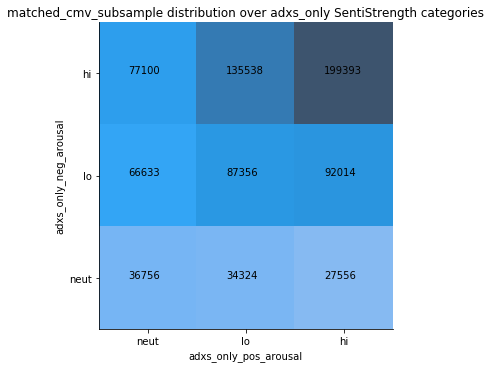

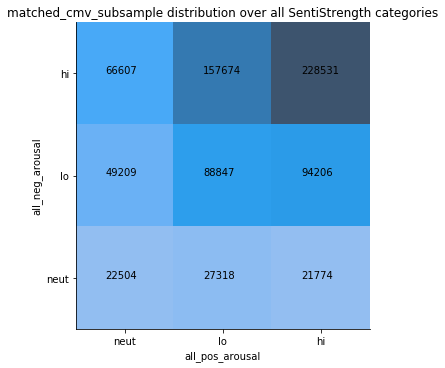

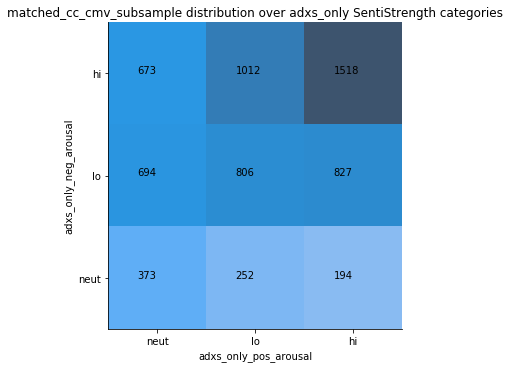

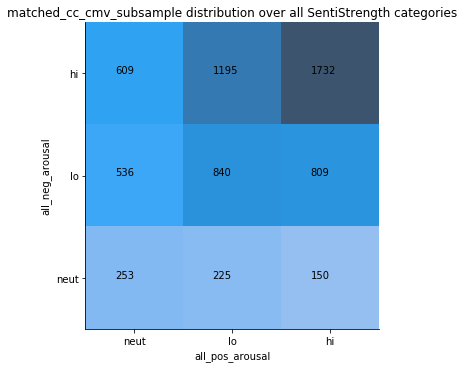

In [89]:
for corp_name in corp_to_analyze:
    if corp_name in {'matched_cc_cmv_subsample','gen_reddit','matched_cmv_subsample'}:
        to_plot_df = pd.DataFrame({
            'id': [utt.id for utt in corp_to_analyze[corp_name].iter_utterances()
                  if utt.meta['senti_all_arousal_cat']],
            'senti_all_arousal_cat':[utt.meta['senti_all_arousal_cat'] 
                                 for utt in corp_to_analyze[corp_name].iter_utterances()
                                 if utt.meta['senti_all_arousal_cat']],
            'senti_adxs_only_arousal_cat':[utt.meta['senti_adxs_only_arousal_cat'] 
                                 for utt in corp_to_analyze[corp_name].iter_utterances()
                                 if utt.meta['senti_all_arousal_cat']]
        })
        for senti_model in {'all','adxs_only'}:
            for i,val in enumerate(['pos','neg']):
                to_plot_df[f'{senti_model}_{val}_arousal'] = \
                to_plot_df[f'senti_{senti_model}_arousal_cat'].apply(
                    lambda x: x.split('_{}'.format(val))[0].split('_')[-1]
                )
                if i%2 == 1:
                    categories=['hi','lo','neut']
                else:
                    categories=['neut','lo','hi']
                to_plot_df[f'{senti_model}_{val}_arousal'] = \
                pd.Categorical(to_plot_df[f'{senti_model}_{val}_arousal'],
                               categories=categories,
                               ordered=True)

            ax = sns.displot(data=to_plot_df, 
                             x=f'{senti_model}_pos_arousal', 
                             y=f'{senti_model}_neg_arousal')
            x_locs, y_locs = ax.axes[0][0].get_xticks(), ax.axes[0][0].get_yticks()
            for p_i,pos_level in enumerate(['neut', 'lo', 'hi']):
                for n_i,neg_level in enumerate(['neut', 'lo', 'hi']):
                    plt.annotate(str(len(to_plot_df.loc[
                        (to_plot_df[f'{senti_model}_pos_arousal']==pos_level) &
                        (to_plot_df[f'{senti_model}_neg_arousal']==neg_level)])),
                        xy=(x_locs[p_i]-0.2,y_locs[2-n_i]))
            plt.title(f'{corp_name} distribution over {senti_model} SentiStrength categories')
            plt.savefig(f'figs/senti_dist_{corp_name}_{senti_model}.png',
                        dpi=150,bbox_inches="tight")

Examine temporal trend:

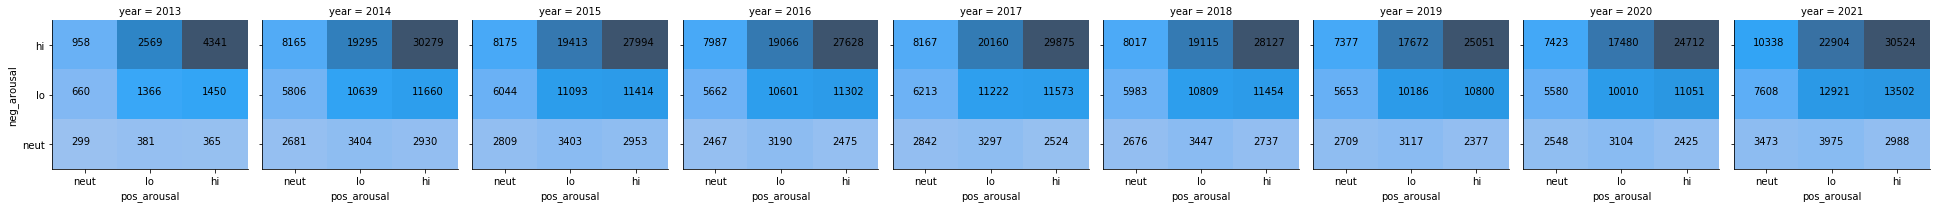

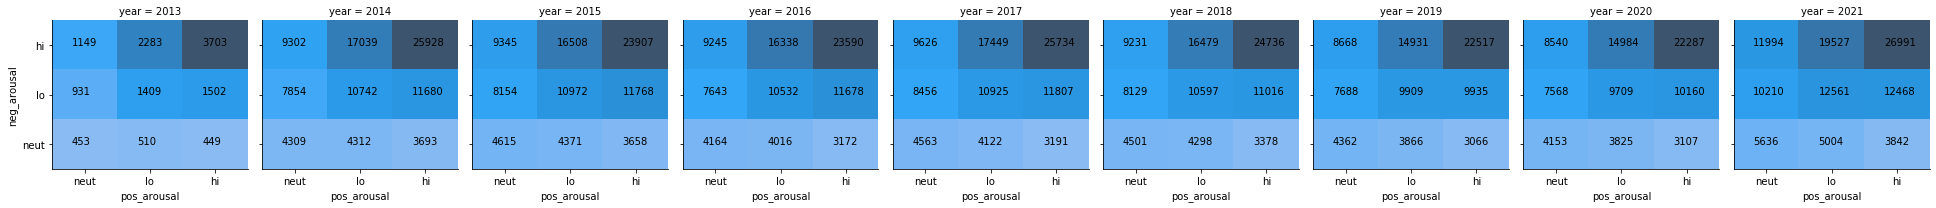

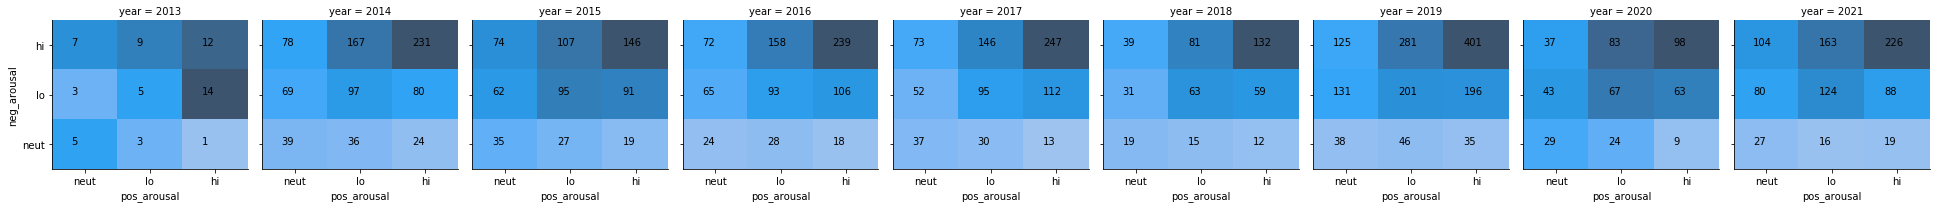

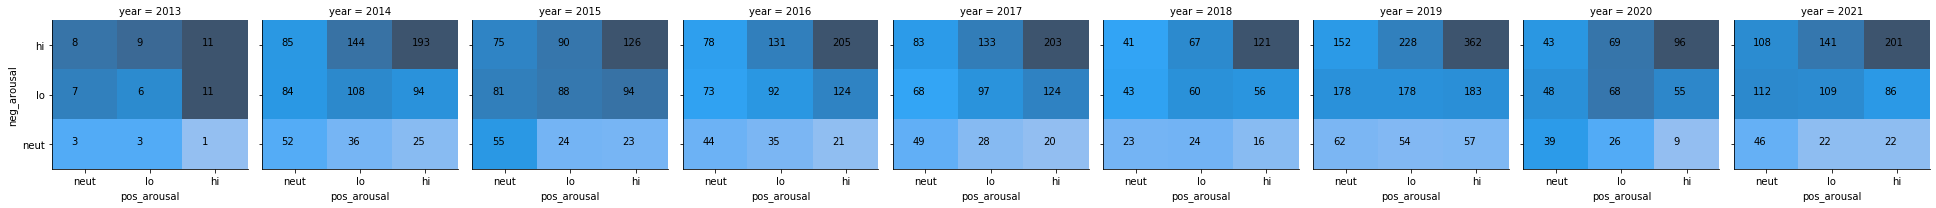

In [90]:
for corp_name in corp_to_analyze:
    if corp_name in {'matched_cc_cmv_subsample','gen_reddit','matched_cmv_subsample'}:

        years = list(range(2013,2022))
        topics = ['climate change','other']
        for senti_model in ['all','adxs_only']:
        #emotions = EMOLEX_EMOS
            df_year, df_topic = [], []
            df_id, df_contro, df_replies, df_score = [], [], [], []
            df_pos_arousal, df_neg_arousal = [], []
            for utt in corp_to_analyze[corp_name].iter_utterances():
                year = datetime.utcfromtimestamp(utt.timestamp).year
                topic = 'climate change' if ('is_cc_related' in utt.meta and utt.meta['is_cc_related']) else 'other'
                df_year.append(year)
                df_topic.append(topic)
                df_id.append(utt.id)
                contro = utt.meta['controversiality'] if 'controversiality' in utt.meta else None
                df_contro.append(contro)
                num_replies = len(utt.meta['reply_ids']) if 'reply_ids' in utt.meta else None
                df_replies.append(num_replies)
                df_score.append(utt.meta['score'])
                senti_cat = utt.meta[f'senti_{senti_model}_arousal_cat'] 
                if senti_cat is not None:
                    df_pos_arousal.append(senti_cat.split('_pos')[0].split('_')[-1])
                    df_neg_arousal.append(senti_cat.split('_neg')[0].split('_')[-1])
                else:
                    df_pos_arousal.append(None)
                    df_neg_arousal.append(None)
            to_plot_df = pd.DataFrame({
                'year':df_year,
                'topic':df_topic,
                'id':df_id,
                'contro':df_contro,
                'num_replies':df_replies,
                'score':df_score,
                'pos_arousal':df_pos_arousal,
                'neg_arousal':df_neg_arousal
            })
            for i,val in enumerate(['pos','neg']):
                if i%2 == 1:
                    categories=['hi','lo','neut']
                else:
                    categories=['neut','lo','hi']
                to_plot_df['{}_arousal'.format(val)] = pd.Categorical(
                                                          to_plot_df['{}_arousal'.format(val)],
                                                          categories=categories,
                                                          ordered=True)

            g = sns.FacetGrid(to_plot_df, col='year', aspect=1)
            g.map(sns.histplot, 'pos_arousal', 'neg_arousal')#, ci='sd')
            sns.despine()
            for i,col in enumerate(g.col_names):
                ax = g.axes.flat[i]
                x_locs, y_locs = ax.get_xticks(), ax.get_yticks()
                for p_i,pos_level in enumerate(['neut', 'lo', 'hi']):
                    for n_i,neg_level in enumerate(['neut', 'lo', 'hi']):
                        ax.annotate(str(len(to_plot_df.loc[(to_plot_df['year']==col) &
                                                           (to_plot_df['pos_arousal']==pos_level) &
                                                           (to_plot_df['neg_arousal']==neg_level)])),
                                    xy=(x_locs[p_i]-0.2,y_locs[2-n_i]))
            plt.savefig(f'figs/senti_dist_over_time_{corp_name}_{senti_model}.png',
                        dpi=150,bbox_inches="tight")

In [173]:
# Why are there so many neut-neut comments in general Reddit?
# Examine examples
[utt.text for utt in corp_to_analyze['gen_reddit'].iter_utterances()
if utt.meta['senti_arousal_cat'] == 'neut_neg_neut_pos'][:20]

["Entire island has no power and water and petrol sales are stopped. Every building is dark and no traffic lights or street lights are working. I'm overnighting at a 7-11 here in Obihiro near Hakurindai station. Hope they manage to get things restored soon, but it may be a few days or even over a week, who knows...",
 'Just a question for my school project. Would really appreciate detailed answers. Thanks!',
 "**Petitions**\n \n[For repeal](https://www.change.org/p/the-singapore-government-repeal-377a)\n\n[Against repeal](https://www.change.org/p/singaporeans-please-keep-penal-code-377a-in-singapore)\n\nUnless there's an actual referendum, these petitions are probably gonna be the best census of which camp is actually larger. Sign away!",
 'Share some interesting love stories from your school days\n\n*disclaimer if the title is misleading, not limited to JC ok. ',
 'Need recommendations after bingeing on Bojack season 5. Any recommendations are welcomed!',
 '*Almost 14 million tourists

In [176]:
[utt.text for utt in corp_to_analyze['matched_cmv_subsample'].iter_utterances()
if utt.meta['senti_arousal_cat'] == 'hi_neg_hi_pos'][:20]

["There's no debate being offered by exposing the_donald to majority of the reddit community on a frequent basis. Challenging opinions aren't allowed on the_donald so if they were to get access the front page again it'd just be *'Here, look out our propaganda! Look at it! Don't challenge it, just look!!!'*. \n\nTell me, what's the point of that? All it does is piss people off because they recognize the blatant lies but can't expose them. That just creates a toxic atmosphere and is no way to run a successful social forum. \n\nIf the_donald allowed freedom of speech I'D LOVE for it to constantly reach /r/all because i'd look forward to the avalanche of intellectual criticism that would bury every post in shame. \n\nSo you might not respect reddit on principle but as a business you should %100 respect it because it is serving it's main customer exactly how it should. \n\nTell me one mainstream conservative speaker or forum that allows or gives weight to liberal opinion? None. Because that

### NRC

In [95]:
VAD = pd.read_csv('/u/scr/yiweil/datasets/NRC-VAD-Lexicon.txt',sep='\t',header=0)
VAD.head()

,Word,Valence,Arousal,Dominance
0,aaaaaaah,0.479,0.606,0.291
1,aaaah,0.520,0.636,0.282
2,aardvark,0.427,0.490,0.437
3,aback,0.385,0.407,0.288
4,abacus,0.510,0.276,0.485


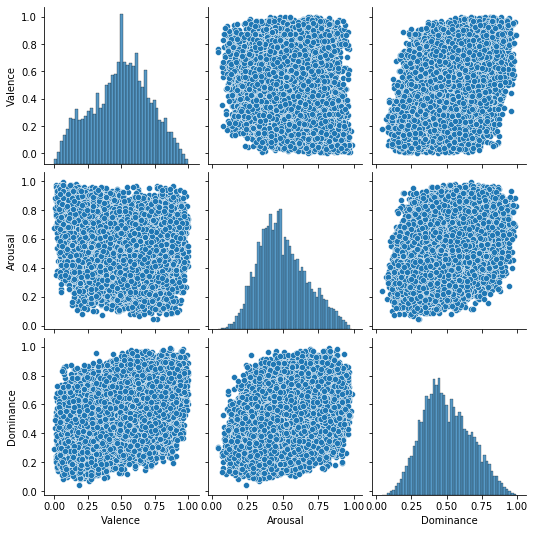

In [20]:
sns.pairplot(data=VAD)

In [98]:
# Create look-up dicts and function for computing NRC arousal

word2nrc_arousal = dict(zip(VAD['Word'],VAD['Arousal']))
word2nrc_valence = dict(zip(VAD['Word'],VAD['Valence']))

NRC_words_per_cat = defaultdict(list)
HI_AROUSAL_THRESH, LO_AROUSAL_THRESH = VAD['Arousal'].quantile(.75), VAD['Valence'].quantile(.25)
for w in tqdm(VAD['Word'].values):
    if word2nrc_arousal[w] >= HI_AROUSAL_THRESH \
    and word2nrc_valence[w] <= VAD['Valence'].quantile(.25):
        NRC_words_per_cat['hi_neg'].append(w)
    elif word2nrc_arousal[w] <= LO_AROUSAL_THRESH \
    and word2nrc_valence[w] <= VAD['Valence'].quantile(.25):
        NRC_words_per_cat['lo_neg'].append(w)
    elif word2nrc_arousal[w] <= LO_AROUSAL_THRESH \
    and word2nrc_valence[w] >= VAD['Valence'].quantile(.75):
        NRC_words_per_cat['lo_pos'].append(w)
    elif word2nrc_arousal[w] >= HI_AROUSAL_THRESH \
    and word2nrc_valence[w] >= VAD['Valence'].quantile(.75):
        NRC_words_per_cat['hi_pos'].append(w)
    else:
        NRC_words_per_cat['neut'].append(w)
        
NRC_words_per_cat = {cat: set(NRC_words_per_cat[cat]) for cat in NRC_words_per_cat}

word2NRC_cat = {}
for cat in NRC_words_per_cat:
    word2NRC_cat.update({w: cat for w in NRC_words_per_cat[cat]})
    
def get_nrc_arousal_cat(utt_lemmas,verbose=False):
    val_lemms = [lemm for lemm in utt_lemmas if lemm in word2nrc_valence]
    if len(val_lemms) > 0:
        valence_norm = sum([word2nrc_valence[lemm] 
                        for lemm in val_lemms])/len(val_lemms)
        arousal_lemms = [lemm for lemm in utt_lemmas if lemm in word2nrc_arousal]
        arousal_norm = sum([word2nrc_arousal[lemm] 
                           for lemm in arousal_lemms])/len(arousal_lemms)
        if verbose:
            print(val_lemms)
            print(arousal_lemms)

        if arousal_norm >= VAD['Arousal'].quantile(.50):
            if valence_norm >= VAD['Valence'].quantile(.5):
                return 'hi_pos'
            else:
                return 'hi_neg'
        elif arousal_norm < VAD['Arousal'].quantile(.50) \
        and arousal_norm >= VAD['Arousal'].quantile(.25):
            if valence_norm >= VAD['Valence'].quantile(.5):
                return 'lo_pos'
            else:
                return 'lo_neg'
        else:
            return 'neut'
    return None

100%|██████████| 20007/20007 [00:22<00:00, 872.77it/s] 


In [ ]:
#NRC_words_per_cat['hi_neg']

In [ ]:
#NRC_words_per_cat['lo_neg']

In [ ]:
#NRC_words_per_cat['hi_pos']

In [ ]:
#NRC_words_per_cat['lo_pos']

In [105]:
# Assign NRC arousal categories if stanza-parsed corpus exists
STANZA_DIR = '/u/scr/yiweil/Green-American-Lexicon/2_data_exploration/\
combined_stanza_output_with_ner'

stanza_dir_dict = {
    'filtered_full_cmv': '/nlp/u/yiweil/stanza_processed/cmv_corpus', # full CMV w/ bots etc. filtered
    'matched_cc_cmv_subsample': '/u/scr/yiweil/Green-American-Lexicon/2_data_exploration/stanza_processed_matched_filtered_cc_cmv_corpus'
}

for corp_name in ['matched_cc_cmv_subsample']:#corp_to_analyze:
    for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
        lemmas, adxs = [], []
        jsonfile = os.path.join(STANZA_DIR,'{}.json'.format(utt.id))
        with open(jsonfile,'r') as f:
            json_obj = json.load(f)
            for sent in json_obj['parse']:
                lemmas.extend([x['lemma'] for x in sent])
                adxs.extend([x['lemma'] for x in sent if x['upos'] in {'ADJ', 'ADV'}])
            
        utt.meta['nrc_all_arousal_cat'] = get_nrc_arousal_cat(lemmas)
        utt.meta['nrc_adxs_only_arousal_cat'] = get_nrc_arousal_cat(adxs)
        #break

6349it [04:06, 25.77it/s]


### Compare SentiStrength categories to VAD categories

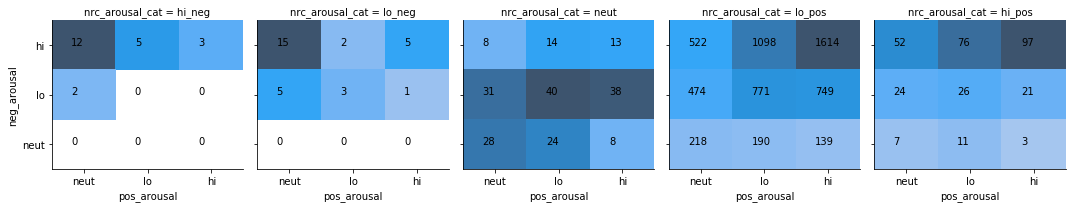

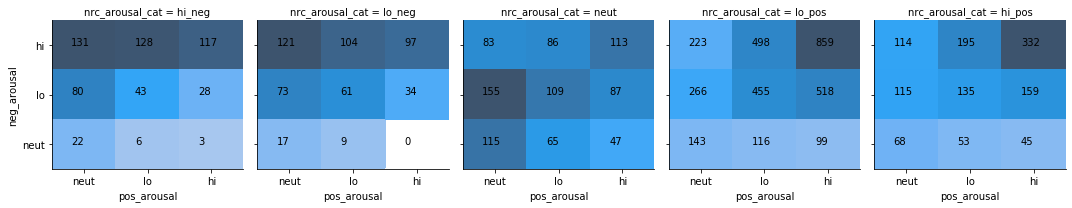

In [112]:
for corp_name in ['matched_cc_cmv_subsample']:#corp_to_analyze:
    for model_name in ['all','adxs_only']:
        to_plot_df = pd.DataFrame({
            'id': [utt.id for utt in corp_to_analyze[corp_name].iter_utterances()
                  if utt.meta[f'senti_{model_name}_arousal_cat'] 
                  and f'nrc_{model_name}_arousal_cat' in utt.meta 
                  and utt.meta[f'nrc_{model_name}_arousal_cat']],
            'senti_arousal_cat':[utt.meta[f'senti_{model_name}_arousal_cat'] 
                                 for utt in corp_to_analyze[corp_name].iter_utterances()
                                 if utt.meta[f'senti_{model_name}_arousal_cat'] 
                                 and f'nrc_{model_name}_arousal_cat' in utt.meta 
                                 and utt.meta[f'nrc_{model_name}_arousal_cat']],
            'nrc_arousal_cat':[utt.meta[f'nrc_{model_name}_arousal_cat'] 
                                 for utt in corp_to_analyze[corp_name].iter_utterances()
                                 if utt.meta[f'senti_{model_name}_arousal_cat'] 
                                 and f'nrc_{model_name}_arousal_cat' in utt.meta 
                                 and utt.meta[f'nrc_{model_name}_arousal_cat']]})
        for i,val in enumerate(['pos','neg']):
            to_plot_df['{}_arousal'.format(val)] = \
            to_plot_df[f'senti_arousal_cat'].apply(
                lambda x: x.split('_{}'.format(val))[0].split('_')[-1]
            )
            if i%2 == 1:
                categories=['hi','lo','neut']
            else:
                categories=['neut','lo','hi']
            to_plot_df['{}_arousal'.format(val)] = pd.Categorical(
                                                      to_plot_df['{}_arousal'.format(val)],
                                                      categories=categories,
                                                      ordered=True)

        g = sns.FacetGrid(to_plot_df, col='nrc_arousal_cat', 
                          col_order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'])
        g.map(sns.histplot, 'pos_arousal', 'neg_arousal')
        for i,col in enumerate(['hi_neg','lo_neg','neut','lo_pos','hi_pos']):
            ax = g.axes.flat[i]
            x_locs, y_locs = ax.get_xticks(), ax.get_yticks()
            for p_i,pos_level in enumerate(['neut', 'lo', 'hi']):
                for n_i,neg_level in enumerate(['neut', 'lo', 'hi']):
                    ax.annotate(str(len(to_plot_df.loc[(to_plot_df['nrc_arousal_cat']==col) &
                                                       (to_plot_df['pos_arousal']==pos_level) &
                                                       (to_plot_df['neg_arousal']==neg_level)])),
                                xy=(x_locs[p_i]-0.2,y_locs[2-n_i]))
    #     plt.title('{} distribution over SentiStrength categories per VAD category'.format(
    #         corp_name))
        plt.savefig(f'figs/senti_dist_and_vad_dist_{corp_name}_{model_name}.png',
                     dpi=150,bbox_inches="tight")

Comments receiving `hi_neg` NRC label but `hi_pos_lo_neg` SentiStrength label:

In [115]:
mismatch_ids = to_plot_df.loc[(to_plot_df['nrc_arousal_cat']=='hi_neg') &
                              (to_plot_df['senti_arousal_cat']=='hi_pos_lo_neg')]\
['id'].values
pd.DataFrame([corp_to_analyze[corp_name].get_utterance(i).text for i in mismatch_ids])

,0
0,"The existence of Global Warming is considered a political issue in very few countries. Really only the US.\n\nWhy is that?\n\nIn 2006, Al Gore helped to make the movie ""An Inconvenient Truth."" The opening line of this film is ""'Hi, I'm Al Gore, I used to be the next president of the United States of America."" By opening the film in this manner, Mr. Gore *immediately* politicized the issue. I don't agree with the fact that it did, but that's the unfortunate truth.\n\n\nIf you're talking about the US and only the US, then there's some truth to this as we've politicized the issue of global warming (even though the IPCC has officially stated that it's happening and caused by humans.) If your talking about other countries, then I don't think this is true simply because global warming isn't a political issue. So, please clarify, is this US specific or not?\n\nSource: Attendance of Multiple Lectures by IPCC memebers"
1,"Just because a source has not got a good track record does not mean they are permanently doomed to being wrong forever. Second, a prediction is only proved when it comes true. Just because it has not come true yet doesn't mean it never will. What you demand from these organisations is that they knew what they were talking about 5 years ago, when there is every chance they are working on more robust science since then. Regardless of this, your post claims it is unprovable. They are, of course, all provable, they just haven't been proved yet. \n\nInstead I put it to you, that you cannot prove that anthropocentric climate change being catastrophic cannot be proven, and your point of view is therefore redundant. I however, can prove that it is provable. It is instantly proved, when any one of the models that claims it will be catastrophic is proved correct"
2,"First time commenting on one of these, your opinion actually makes a lot of sense to me. Developing economies need these co2 emitting resources; however, there is no need for developed nations to still be using them. While there are definite pluses for having more CO2 in the air there are still many negatives! Pollution, contamination, CO2 levels in the ocean, acid rain, smog, and many more. Human life and expectancy can all move up by creating resources that have no effect on the environment. Elon Musk had commented this a couple days ago: ""If we know we have to get off oil no matter what, we know that is an inescapable outcome, why run this crazy experiment of changing the chemical composition of the atmosphere and oceans by adding enormous amounts of CO2 that have been buried since the Precambrian Era?"" he added. ""That's crazy. That's the dumbest experiment in history, by far."""
3,Politicians should have been making substantial progress towards stopping climate change years and years ago. We still aren't doing enough. One could make the point that our economies are dependent on fossil fuels too much at the minute (particularly in the us where lobbying forces have ensured that fossil fuels are subsidised massively.) These are all things that are currently delaying (or minimising) political action on climate change
4,"Could be if it wasn't so expensive. Nuclear power could be great if we'd invested heavily in developing a cheap to decommission, long life, unable to breed isotopes for nuclear weapons reactor 30 or 40 years ago. \n\nThe same is true of fusion, even if fusion reactors become viable you can get a huge amount of solar panels, wind turbines and hydro dams for the same money as a fusion reactor would cost."
5,"Very few progressives are abstaining from their vote with Biden, especially with the leaders of the progressive wing aligning themselves, furthermore with no serious 3rd party contender your argument should be along the lines ”if your on the left and hold climate change to a high degree then you should vote for biden and not a write in candidate or the green party” \n\nThere are thousands of sources that will adequately demonstrate the

Comments receiving `hi_pos` NRC label but `hi_neg_neut_pos` or `hi_neg_lo_pos` SentiStrength label:

In [39]:
mismatch_ids = to_plot_df.loc[(to_plot_df['nrc_arousal_cat']=='hi_pos') &
                              (to_plot_df['senti_arousal_cat'].isin({'hi_neg_neut_pos',
                                                                     'hi_neg_lo_pos'}))]\
['id'].values
pd.DataFrame([corp_to_analyze[corp_name].get_utterance(i).text for i in mismatch_ids])

,0
0,The right to free speech is like the right for an infectious disease to escape quarantine.\n\nWe are not children. We understand that certain ideas (violence for one) are infectious and destructive.\n\nAnyone to argue differently is ruled by his emotion and not his higher mind.\n\nFreedom of speech was an experiment that failed.
1,"Thank everything you're not in charge. No telling what kind of lies [one] might invent to justify [one's] tyranny. Maybe even something like how God put [them] in charge, and [they'd] be justified to stab anyone who disagreed.\n\nEDIT: [grammatical correction]\n\nFurther edit for clarity. The ""Noble Lie"" has been used for thousands of years to oppress and abuse the overwhelming majority of humanity even to the level of the ""divine right"" of absolute monarchs and living god-kings, which included the authority to stab anyone who disagree with their ""noble lie."""
2,"Yes, a smoker telling their kids not to smoke is not a hypocrite. They are warning them. They may wish they had never started and could quit. But spanking their kid for hitting his sister, *that* is hypocritical. \n\nFlying in a private jet is not an addiction. They could easily not do it. They want people to change their lifestyles. They should lead by example."
3,"The specific example given is a fairly uncontroversial effort to prosecute a grand fraud perpetuated on the public. Lies are not an important part of any ""free and open debate"", which is why we have laws against defamation and false advertising, both of which have been used by climate deniers in their effort to choke any serious public debate about climate change. The few qualified scientists who genuinely disbelieve part or all of the consensus on climate change are free to challenge those scientific conclusions in return for being corruptly subsidised to do so by Exxon - and are free to be humiliatingly rebutted over and over and over within the pages of scientific publications. Their sponsors are not free to misrepresent the actual results of that debate and (inter alia) the likely dangers associated with the products they sell to their shareholders, consumers or the public, which is the crime they're accused of. Nor is a car company selling a car that explodes when you turn the ignition legally allowed to sell it you as safe. That is not the sort of free speech that is protected in the first amendment, no matter what nonsense Reason bleats. It's not actually important that we permit corporations to pay for vast false advertising campaigns, or to lie to their shareholders or customers."
4,"But how is that fear mongering? The proposed ban isn't because of some scary thing that might happen in the future. Its because air pollution has *already* damaged Paris, combined with the fact that even if they were 100% clean, massive cars are disruptive to city life. Can you show how this proposal is in any way linked to ""fear mongering"" about climate change, as opposed to responding to non-climate related problems (smog, space) that are *already* affecting the city?"
...,...
120,"> All the catastrophic predictions for global warming assume some feedback loop whereby continued increases in CO2 trigger another effect which then leads to runaway warming. Change a few assumptions about those feedback loops (e.g. how much sunlight is reflected back by cloud cover) and suddenly the predictions for warming are moderate and not catastrophic at all.\n\nAll reasonable studies give their results in the form of a probability distribution function. Typically, they say that catastrophic warming is a low probability, but not zero probability, event.\n\nGiven the potential catastrophe, we should be thinking about the fact that if the assumptions about feedback *do* skew a certain way in point of fact, then we have a major global crisis impending. A 3% or 5% chance of catastrophe is not something to be taken lightly.\n\nI strongly suggest reading or listening to [this interview](http://ww

## Emotions

### EmoLex

In [116]:
BLACKLIST_WORDS = {'shit','shitty','fuck','crap','crappy','gore','trump','tree','sun','soil','shanghai','john',
                  'desert','turn','earthquake','lightning','hurricane','cyclone','tornado','storm','wildfire',
                  'fire','cool','warm','hot','human','earth','planet','global','climate','change','cold'}

In [117]:
PATH_TO_EMOLEX = "/u/scr/yiweil/datasets/NRC-Emotion-Intensity-Lexicon-v1.txt"
EMOLEX = pd.read_csv(PATH_TO_EMOLEX,sep='\t')
EMOLEX = EMOLEX.loc[~EMOLEX['word'].isin(BLACKLIST_WORDS)]
EMOLEX_EMOS = EMOLEX['emotion'].value_counts().index
print(EMOLEX.head())

print(EMOLEX[
    'emotion'
].value_counts())

        word emotion  emotion-intensity-score
0   outraged   anger                    0.964
1  brutality   anger                    0.959
2     hatred   anger                    0.953
3    hateful   anger                    0.940
4  terrorize   anger                    0.939
fear            1754
trust           1562
anger           1475
sadness         1292
joy             1265
disgust         1085
anticipation     862
surprise         578
Name: emotion, dtype: int64


In [124]:
EMOLEX.loc[(EMOLEX['emotion']=='trust') & 
          (EMOLEX['emotion-intensity-score']>0.5)].word.values

array(['truthfulness', 'trusted', 'trustworthy', 'truth', 'honor',
       'honest', 'honesty', 'trusting', 'truthful', 'brotherhood',
       'entrust', 'credibility', 'integrity', 'honorable', 'loyalty',
       'committed', 'trust', 'faithful', 'sincere', 'true', 'partnership',
       'responsible', 'wisdom', 'verification', 'cooperative', 'vow',
       'oath', 'credible', 'respectable', 'promise', 'verified', 'hero',
       'sisterhood', 'qualified', 'respected', 'authentication',
       'compassion', 'safekeeping', 'love', 'trusts', 'moral',
       'reputable', 'reliability', 'approval', 'loyal', 'competence',
       'companion', 'ally', 'respect', 'advised', 'safeguard',
       'authentic', 'genuine', 'friend', 'stable', 'friendships',
       'respects', 'wholesome', 'faith', 'proven', 'freedom', 'accepting',
       'unification', 'confirmation', 'protecting', 'admirable',
       'reassurance', 'heartfelt', 'supporter', 'respectful', 'trustee',
       'friendship', 'fact', 'confiden

In [118]:
# Create look-up dicts and function for computing Emolex scores

word2emolex_score = defaultdict(dict)
for _,row in EMOLEX.iterrows():
    word, emotion, score = row['word'], row['emotion'], row['emotion-intensity-score']
    word2emolex_score[word][emotion] = score
    
def get_emolex_scores(utt,json_dir,verbose=False):
    jsonfile = os.path.join(json_dir,'{}.json'.format(utt.id))
    json_obj = json.load(open(jsonfile,'r'))
    utt_lemmas, utt_adxs = [], []
    for sent in json_obj['parse']:
        utt_lemmas.extend([x['lemma'] for x in sent])
        utt_adxs.extend([x['lemma'] for x in sent if x['upos'] in {'ADJ','ADV'}])
        
    emo_lemms = [lemm for lemm in utt_lemmas if lemm in word2emolex_score]
    emo_adxs = [lemm for lemm in utt_adxs if lemm in word2emolex_score]
    if verbose:
        print(emo_lemms)
        print(emo_adxs)
    emo_norms = defaultdict(dict)
    if len(emo_lemms) > 0:
        for emo in EMOLEX_EMOS:
            emo_norm = sum([word2emolex_score[lemm][emo]
                            for lemm in emo_lemms
                            if emo in word2emolex_score[lemm]])/len(emo_lemms)
            emo_norms['all'][emo] = emo_norm
    if len(emo_adxs) > 0:
        for emo in EMOLEX_EMOS:
            emo_norm = sum([word2emolex_score[lemm][emo]
                            for lemm in emo_adxs
                            if emo in word2emolex_score[lemm]])/len(emo_adxs)
            emo_norms['adxs_only'][emo] = emo_norm
    return emo_norms

In [119]:
utt.text

'I subscribe to what I\'ve termed as egalitarian, but can be summed up as the Bill and Ted school of thought: "Be excellent to each other. Party on, dudes!" or, in non-80s-surfer-speak: "Every sapient being should be treated with respect and dignity." And from what bits I\'ve picked up from the scholarly aspects of feminism, that\'s pretty in line with their goals too.'

In [120]:
get_emolex_scores(utt,STANZA_DIR,verbose=True)

['subscribe', 'school', 'excellent', 'party', 'treat', 'respect', 'dignity', 'feminism', 'pretty']
['excellent', 'pretty']


defaultdict(dict,
            {'all': {'fear': 0.010444444444444444,
              'trust': 0.3775555555555556,
              'anger': 0.049,
              'sadness': 0.008444444444444444,
              'joy': 0.3972222222222222,
              'disgust': 0.008666666666666666,
              'anticipation': 0.1971111111111111,
              'surprise': 0.034666666666666665},
             'adxs_only': {'fear': 0.0,
              'trust': 0.5115,
              'anger': 0.0,
              'sadness': 0.0,
              'joy': 0.6405000000000001,
              'disgust': 0.0,
              'anticipation': 0.207,
              'surprise': 0.0}})

In [125]:
len(defaultdict(dict))

0

In [126]:
# Get Emolex scores for corpora that are stanza-parsed
for corp_name in ['matched_cc_cmv_subsample']:#corp_to_analyze:
    for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
        scores = get_emolex_scores(utt,STANZA_DIR)
        if len(scores) > 0:
            for emo in EMOLEX_EMOS:
                for model_name in scores:
                    utt.meta[f'emolex_{model_name}_{emo}'] = scores[model_name][emo]

6349it [00:13, 465.23it/s]


Examine temporal trend:

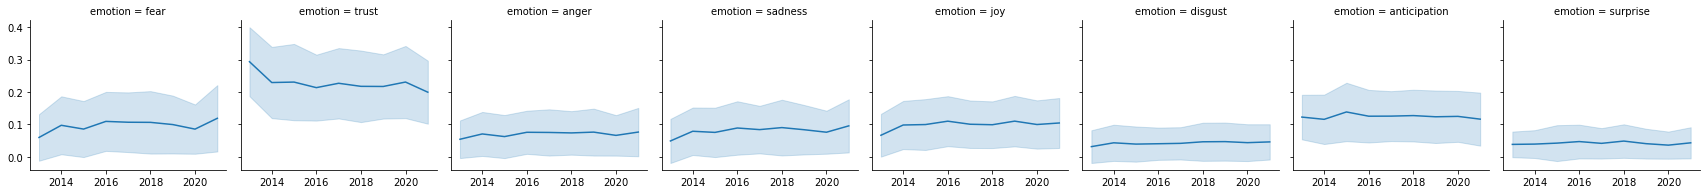

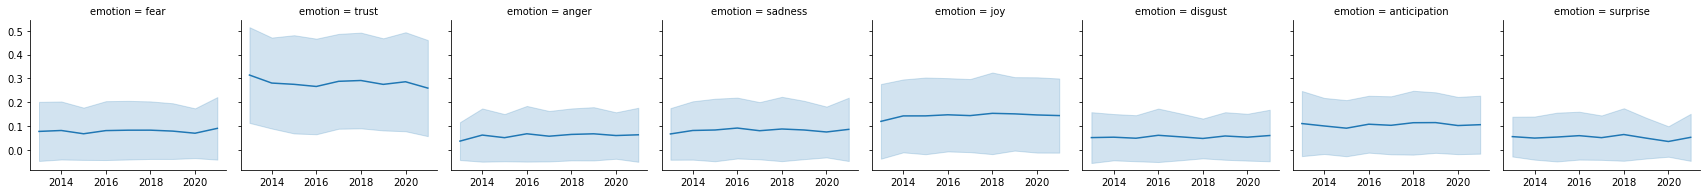

In [133]:
for corp_name in ['matched_cc_cmv_subsample']:#corp_to_analyze:

    years = list(range(2013,2022))
    topics = ['climate change','other']
    emotions = EMOLEX_EMOS
    for model_name in ['all','adxs_only']:
        df_year, df_topic, df_emo, df_emoscore = [], [], [], []
        df_id, df_contro, df_replies, df_score = [], [], [], []
        df_nrc_arousal, df_pos_arousal, df_neg_arousal = [], [], []
        df_delta = []
        for utt in corp_to_analyze[corp_name].iter_utterances():
            year = datetime.utcfromtimestamp(utt.timestamp).year
            topic = 'climate change' if utt.meta['is_cc_related'] else 'other'
            for key in utt.meta.keys():
                if key.startswith(f'emolex_{model_name}'):
                    emo = key.split('_')[-1]
                    score = utt.meta[f'emolex_{model_name}_{emo}']
                    df_year.append(year)
                    df_topic.append(topic)
                    df_emo.append(emo)
                    df_emoscore.append(score)
                    df_id.append(utt.id)
                    df_contro.append(utt.meta['controversiality'])
                    df_replies.append(len(utt.meta['reply_ids']))
                    df_score.append(utt.meta['score'])
                    df_nrc_arousal.append(utt.meta[f'nrc_{model_name}_arousal_cat'])
                    senti_cat = utt.meta[f'senti_{model_name}_arousal_cat']
                    df_pos_arousal.append(senti_cat.split('_pos')[0].split('_')[-1])
                    df_neg_arousal.append(senti_cat.split('_neg')[0].split('_')[-1])
                    df_delta.append(utt.meta['is_awarded_delta'])
        to_plot_df = pd.DataFrame({
            'year':df_year,
            'topic':df_topic,
            'emotion':df_emo,
            'emoscore':df_emoscore,
            'id':df_id,
            'contro':df_contro,
            'num_replies':df_replies,
            'score':df_score,
            'nrc_arousal':df_nrc_arousal,
            'pos_arousal':df_pos_arousal,
            'neg_arousal':df_neg_arousal,
            'is_awarded_delta':df_delta
        })
        for i,val in enumerate(['pos','neg']):
            if i%2 == 1:
                categories=['hi','lo','neut']
            else:
                categories=['neut','lo','hi']
            to_plot_df['{}_arousal'.format(val)] = pd.Categorical(
                                                      to_plot_df['{}_arousal'.format(val)],
                                                      categories=categories,
                                                      ordered=True)
        plt.rcParams['figure.figsize'] = [10, 5]
        g = sns.FacetGrid(to_plot_df, col='emotion', aspect=1)
        g.map(sns.lineplot, 'year', 'emoscore', ci='sd')
        sns.despine()
        for ax in g.axes[0]:
            ax.set_xlabel('')
            ax.set_ylabel('')
        plt.savefig(f'figs/emolex_scores_over_time_{corp_name}_{model_name}.png',
                    dpi=200,bbox_inches="tight")

Examine other correlations:

In [174]:
to_plot_df.head()

,year,topic,emotion,emoscore,id,contro,num_replies,score,nrc_arousal,pos_arousal,neg_arousal
0,2020,climate change,fear,0.03624,t1_fifr7b0,0,1,0,lo_pos,lo,hi
1,2020,climate change,trust,0.24874,t1_fifr7b0,0,1,0,lo_pos,lo,hi
2,2020,climate change,anger,0.03636,t1_fifr7b0,0,1,0,lo_pos,lo,hi
3,2020,climate change,sadness,0.08048,t1_fifr7b0,0,1,0,lo_pos,lo,hi
4,2020,climate change,joy,0.10718,t1_fifr7b0,0,1,0,lo_pos,lo,hi


Engagement-related correlations:

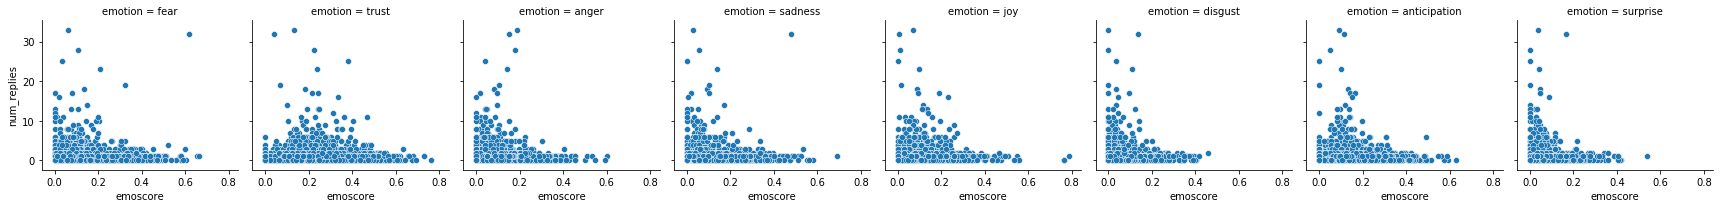

In [209]:
g = sns.FacetGrid(to_plot_df, col='emotion')
g.map(sns.scatterplot,'emoscore','num_replies')
# for ax in g.axes[0]:
#     ax.set_yscale('log')

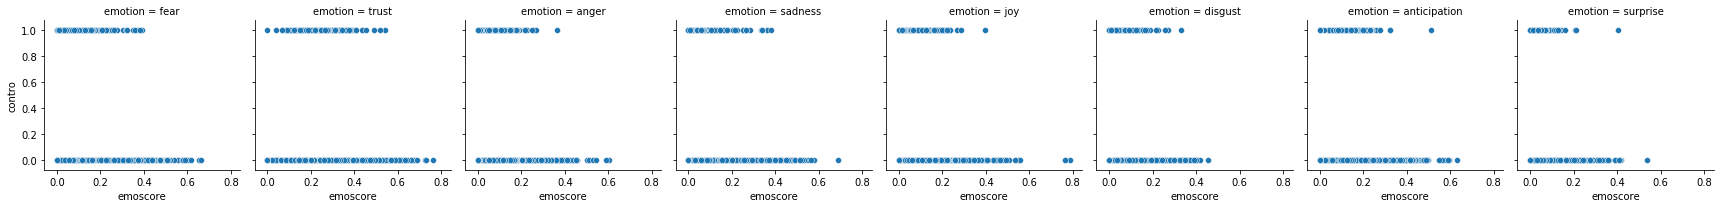

In [210]:
g = sns.FacetGrid(to_plot_df, col='emotion')
g.map(sns.scatterplot,'emoscore','contro')

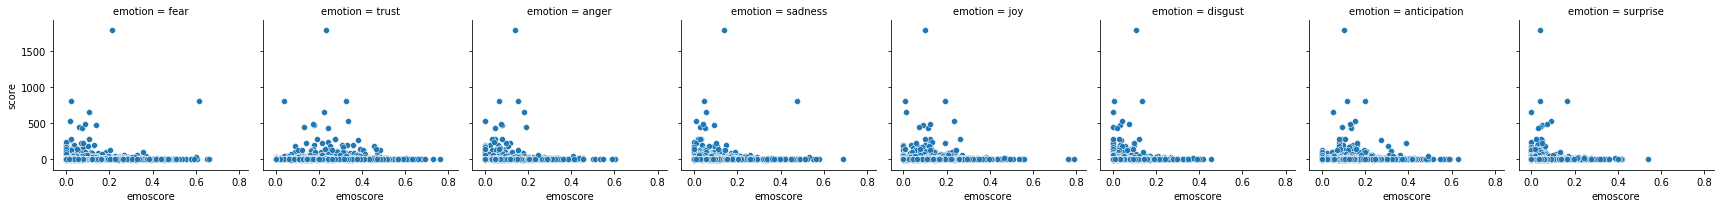

In [211]:
g = sns.FacetGrid(to_plot_df, col='emotion')
g.map(sns.scatterplot,'emoscore','score')

Arousal correlations:

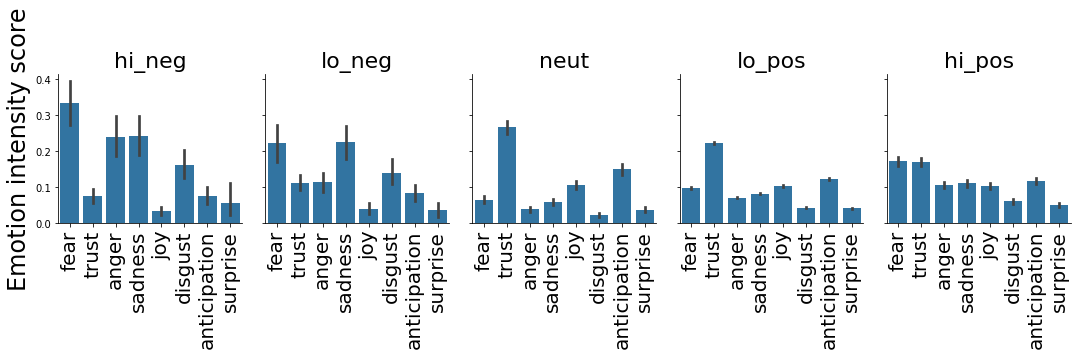

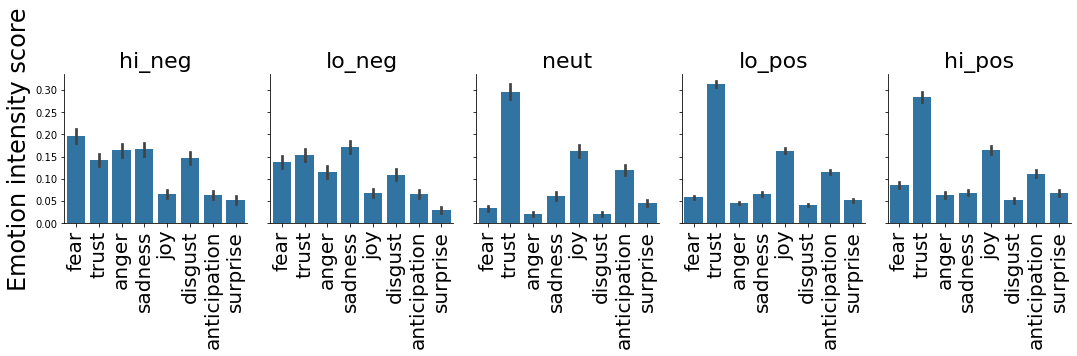

In [134]:
for corp_name in ['matched_cc_cmv_subsample']:#corp_to_analyze:
    for model_name in ['all','adxs_only']:
        df_year, df_topic, df_emo, df_emoscore = [], [], [], []
        df_id, df_contro, df_replies, df_score = [], [], [], []
        df_nrc_arousal, df_pos_arousal, df_neg_arousal = [], [], []
        df_delta = []
        for utt in corp_to_analyze[corp_name].iter_utterances():
            year = datetime.utcfromtimestamp(utt.timestamp).year
            topic = 'climate change' if utt.meta['is_cc_related'] else 'other'
            for key in utt.meta.keys():
                if key.startswith(f'emolex_{model_name}'):
                    emo = key.split('_')[-1]
                    score = utt.meta[f'emolex_{model_name}_{emo}']
                    df_year.append(year)
                    df_topic.append(topic)
                    df_emo.append(emo)
                    df_emoscore.append(score)
                    df_id.append(utt.id)
                    df_contro.append(utt.meta['controversiality'])
                    df_replies.append(len(utt.meta['reply_ids']))
                    df_score.append(utt.meta['score'])
                    df_nrc_arousal.append(utt.meta[f'nrc_{model_name}_arousal_cat'])
                    senti_cat = utt.meta[f'senti_{model_name}_arousal_cat']
                    df_pos_arousal.append(senti_cat.split('_pos')[0].split('_')[-1])
                    df_neg_arousal.append(senti_cat.split('_neg')[0].split('_')[-1])
                    df_delta.append(utt.meta['is_awarded_delta'])
        to_plot_df = pd.DataFrame({
            'year':df_year,
            'topic':df_topic,
            'emotion':df_emo,
            'emoscore':df_emoscore,
            'id':df_id,
            'contro':df_contro,
            'num_replies':df_replies,
            'score':df_score,
            'nrc_arousal':df_nrc_arousal,
            'pos_arousal':df_pos_arousal,
            'neg_arousal':df_neg_arousal,
            'is_awarded_delta':df_delta
        })
        for i,val in enumerate(['pos','neg']):
            if i%2 == 1:
                categories=['hi','lo','neut']
            else:
                categories=['neut','lo','hi']
            to_plot_df['{}_arousal'.format(val)] = pd.Categorical(
                                                      to_plot_df['{}_arousal'.format(val)],
                                                      categories=categories,
                                                      ordered=True)
    
        g = sns.FacetGrid(to_plot_df, col=f'nrc_arousal', 
                          col_order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'])
        g.map(sns.barplot, 'emotion', 'emoscore', order=EMOLEX_EMOS)

        # Aesthetics & saving
        for ax_ix,ax in enumerate(g.axes[0]):
            if ax_ix == 0:
                ax.set_ylabel('Emotion intensity score',fontsize=24)
            ax.set_title(ax.title._text.split('= ')[-1],fontsize=22)
            ax.set_xticklabels(ax.get_xticklabels(),rotation=90,fontsize=20)
            ax.set_xlabel('')
        plt.savefig(f'figs/emolex_dist_and_vad_dist_{corp_name}_{model_name}.png',
                     dpi=150,bbox_inches="tight")

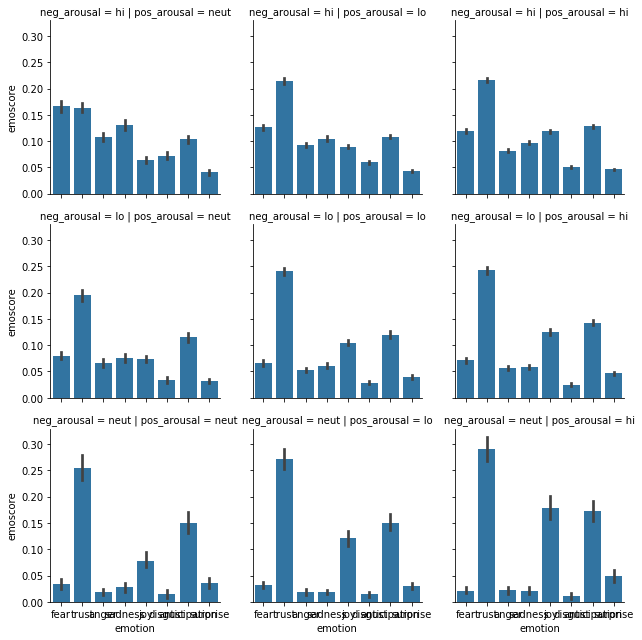

In [200]:
for corp_name in ['matched_cc_cmv_subsample']:#corp_to_analyze:
    
    g = sns.FacetGrid(to_plot_df, col='pos_arousal', row='neg_arousal',
                      col_order=['neut','lo','hi'], row_order=['hi','lo','neut'])
    g.map(sns.barplot, 'emotion', 'emoscore', order=EMOLEX_EMOS)
    
#     # Aesthetics & saving
#     for ax_ix,ax in enumerate(g.axes[0]):
#         if ax_ix == 0:
#             ax.set_ylabel('Emotion intensity score',fontsize=24)
#         ax.set_title(ax.title._text.split('= ')[-1],fontsize=22)
#         ax.set_xticklabels(ax.get_xticklabels(),rotation=90,fontsize=20)
#         ax.set_xlabel('')
#     plt.savefig('figs/emolex_dist_and_senti_dist_{}.png'.format(corp_name),
#                  dpi=150,bbox_inches="tight")

## People

In [47]:
def get_ents(utt,json_dir,verbose=False):
    jsonfile = os.path.join(json_dir,'{}.json'.format(utt.id))
    json_obj = json.load(open(jsonfile,'r'))
    #print(json_obj['ents'])
    ents = [(x['text'],x['type']) for x in json_obj['ents']]
    return ents

In [48]:
# Extract people
for corp_name in ['matched_cc_cmv_subsample']:#corp_to_analyze:
    all_corp_ents = []
    for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
        utt_ents = get_ents(utt,STANZA_DIR)
        all_corp_ents.extend(utt_ents)
        utt.meta['people'] = [e[0] for e in utt_ents if e[1]=='PERSON']

6349it [01:36, 66.01it/s] 


Re-do with only real people (if Stanza+NER output unavailable):

In [70]:
# counted_propns = Counter([item for sublist in 
#          [[x[0] for x in utt.meta['propns']] for utt in corp_to_analyze[corp_name].iter_utterances()]
#         for item in sublist])
# #sorted(counted_propns.items(),key=lambda x: x[1],reverse=True)

In [72]:
#true_people = set(['Trump','Gore','Al','Bill','Greta','Obama','Biden','Nye','McConnell','Clinton','Joe',
              'Hillary','John','Gates','trump','Thunberg','Bush','Musk','AOC','Elon','Donald','Einstein',
              'Bernie','Newton','David','Paul','Nixon','Sanders','Friedman','Koch','George','Michael','Mann',
              'Ehrlich','Milton','Spencer','al','Dr.','Ford','DiCaprio','Hitler','Coke','Hayek','Nordhaus',
              'Milankovitch','Neil','Krugman','Marshall','Mitch','Leonardo','Ted','Hansen','Warren','Lee',
              'Christy','gore','Tucker','Martin','Phillips','Simon','Bezos','Levitt','Kerry','Leo','Mr.',
              'James','Moore','Andrew','Gandhi','Cortez','Adam','Galileo'])

In [73]:
#for corp_name in ['matched_cc_cmv_subsample']:#corp_to_analyze:
    for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
        utt.meta['propns'] = [x[0] for x in utt.meta['propns'] if x[0] in true_people]

6349it [00:00, 95634.57it/s]


First, examine most commonly mentioned NEs:

In [110]:
sorted(Counter([x for x in all_corp_ents if x[1] not in {'DATE','CARDINAL','ORDINAL','PERCENT'}]).items(), 
       key=lambda x: x[1], reverse=True)[:100]

[(('US', 'GPE'), 738),
 (('Earth', 'LOC'), 642),
 (('China', 'GPE'), 602),
 (('Trump', 'PERSON'), 175),
 (('India', 'GPE'), 174),
 (('IPCC', 'ORG'), 160),
 (('American', 'NORP'), 155),
 (('America', 'GPE'), 145),
 (('Europe', 'LOC'), 139),
 (('Republicans', 'NORP'), 130),
 (('Canada', 'GPE'), 116),
 (('USA', 'GPE'), 108),
 (('Americans', 'NORP'), 95),
 (('NASA', 'ORG'), 92),
 (('California', 'GPE'), 89),
 (('Democrats', 'NORP'), 83),
 (('Russia', 'GPE'), 83),
 (('the United States', 'GPE'), 79),
 (('Africa', 'LOC'), 74),
 (('Chinese', 'NORP'), 73),
 (('U.S.', 'GPE'), 71),
 (('republicans', 'NORP'), 65),
 (('Australia', 'GPE'), 57),
 (('UK', 'GPE'), 57),
 (('earth', 'LOC'), 56),
 (('EPA', 'ORG'), 51),
 (('Republican', 'NORP'), 50),
 (('Al Gore', 'PERSON'), 48),
 (('Tesla', 'ORG'), 46),
 (('Venus', 'LOC'), 45),
 (('Paris', 'GPE'), 45),
 (('Obama', 'PERSON'), 44),
 (('Germany', 'GPE'), 42),
 (('EU', 'ORG'), 41),
 (('Florida', 'GPE'), 40),
 (('Bible', 'WORK_OF_ART'), 40),
 (('OP', 'ORG'), 

Examine most commonly mentioned people:

In [112]:
counted_people = Counter([item for sublist in 
         [utt.meta['people'] for utt in corp_to_analyze[corp_name].iter_utterances()]
        for item in sublist])
sorted(counted_people.items(),key=lambda x: x[1],reverse=True)

[('Trump', 175),
 ('Al Gore', 48),
 ('Obama', 44),
 ('Greta', 38),
 ('Biden', 36),
 ('McConnell', 32),
 ('Bill Nye', 26),
 ('Clinton', 26),
 ('Hillary', 23),
 ('Jesus', 17),
 ("Al Gore's", 14),
 ('Nye', 14),
 ('Gore', 13),
 ('Nixon', 13),
 ('Bush', 13),
 ('Greta Thunberg', 13),
 ('Donald Trump', 12),
 ('Newton', 12),
 ('Satan', 12),
 ('Bill Gates', 11),
 ('Elon Musk', 11),
 ('Einstein', 11),
 ('Joe', 9),
 ('Thunberg', 9),
 ('Hitler', 9),
 ('Bill', 9),
 ('Joe Biden', 8),
 ('Musk', 8),
 ('Milton Friedman', 8),
 ('Gates', 8),
 ('Bernie', 7),
 ('Onceler', 7),
 ('David Suzuki', 6),
 ('Sanders', 6),
 ('Koch', 6),
 ('Hayek', 6),
 ('Dryas', 6),
 ('Utah Phillips', 6),
 ('Levitt', 6),
 ('JFK', 6),
 ('Green', 6),
 ('Joe Everyman', 6),
 ('Michael Mann', 6),
 ('Hansen', 5),
 ('Lee', 5),
 ('Cortez', 5),
 ('DiCaprio', 5),
 ('Covid', 5),
 ('Cook', 5),
 ('Paul Krugman', 5),
 ('Socrates', 5),
 ('Hillary Clinton', 4),
 ('George Carlin', 4),
 ('Ghandi', 4),
 ('Bernie Sanders', 4),
 ('Spencer', 4),
 ('Nord

Examine temporal trend:

6349it [00:00, 152036.43it/s]
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in long_scalars


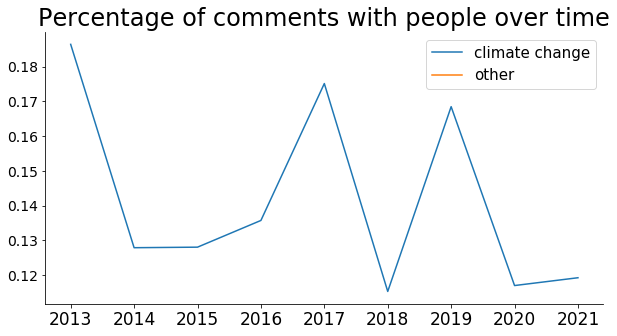

In [113]:
for corp_name in ['matched_cc_cmv_subsample']:#corp_to_analyze:
    counts_by_bin = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

    for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
        if not utt.meta['written_by_bot']\
        and utt.timestamp:
            year = datetime.utcfromtimestamp(utt.timestamp).year
            if utt.meta['is_cc_related']:
                if len(utt.meta['people'])>0:
                    counts_by_bin[year]['climate change']['has person'] += 1
                else:
                    counts_by_bin[year]['climate change']['no person'] += 1
            else:
                if len(utt.meta['people'])>0:
                    counts_by_bin[year]['other']['has person'] += 1
                else:
                    counts_by_bin[year]['other']['no person'] += 1

    years = list(range(2013,2022))
    topics = ['climate change','other']
    classes = ['has person','no person']
    to_plot_df = pd.DataFrame({
        'year':[item for sublist in 
                [[y]*len(topics)*len(classes) for y in years]
                for item in sublist],
        'topic':[item for sublist in 
                [[t]*len(classes) for t in topics]
                for item in sublist]*len(years),
        'class':classes*len(years)*len(topics),
        'count':[counts_by_bin[y][t][c] for y in years for t in topics for c in classes] 
    })

    per_year_topic_totals = to_plot_df.groupby(['year','topic']).sum()
    to_plot_df['percent'] = to_plot_df.apply(
        lambda x: x['count']/per_year_topic_totals.loc[x['year']]\
                            .loc[x['topic']]['count'],
        axis=1
    )

    plt.rcParams['figure.figsize'] = [10, 5]
    sns.lineplot(data=to_plot_df.loc[to_plot_df['class']=='has person'],
               x='year',y='percent',hue='topic',ci='sd')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=14)
    plt.title('Percentage of comments with people over time',fontsize=24)
    plt.legend(title='',fontsize=15)
    sns.despine()
    plt.savefig('figs/pct_comments_with_people_over_time_{}.png'.format(corp_name),
                dpi=200,bbox_inches="tight")

Examine correlation with other comment properties:

In [128]:
for corp_name in ['matched_cc_cmv_subsample']:#corp_to_analyze:

    people_df = pd.DataFrame({
        'id':[utt.id
             for utt in corp_to_analyze[corp_name].iter_utterances()],
        'has_person':[len(utt.meta['people'])>0 
                      for utt in corp_to_analyze[corp_name].iter_utterances()],
        'num_people':[len(utt.meta['people']) 
                      for utt in corp_to_analyze[corp_name].iter_utterances()],
        'year':[datetime.utcfromtimestamp(utt.timestamp).year 
                for utt in corp_to_analyze[corp_name].iter_utterances()],
        'controversiality':[utt.meta['controversiality'] 
                            for utt in corp_to_analyze[corp_name].iter_utterances()],
        'num_replies':[len(utt.meta['reply_ids'])
                       for utt in corp_to_analyze[corp_name].iter_utterances()],
        'score':[utt.meta['score']
                 for utt in corp_to_analyze[corp_name].iter_utterances()]
    })

    people_df.head()

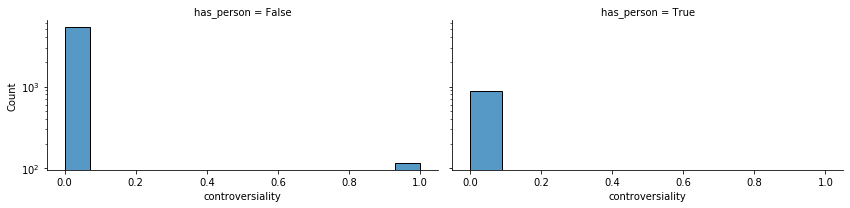

In [129]:
g = sns.FacetGrid(people_df, col='has_person', aspect=2)
g.map(sns.histplot, "controversiality")#, log_scale=True)
g.axes[0][0].set_yscale('log')
g.axes[0][1].set_yscale('log')

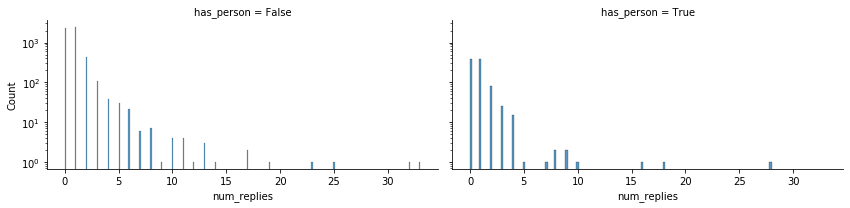

In [130]:
g = sns.FacetGrid(people_df, col='has_person', aspect=2)
g.map(sns.histplot, "num_replies")#, log_scale=True)
g.axes[0][0].set_yscale('log')
g.axes[0][1].set_yscale('log')

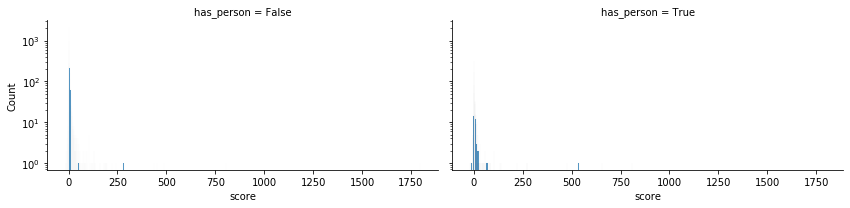

In [131]:
g = sns.FacetGrid(people_df, col='has_person', aspect=2)
g.map(sns.histplot, "score")#, log_scale=True)
g.axes[0][0].set_yscale('log')
g.axes[0][1].set_yscale('log')

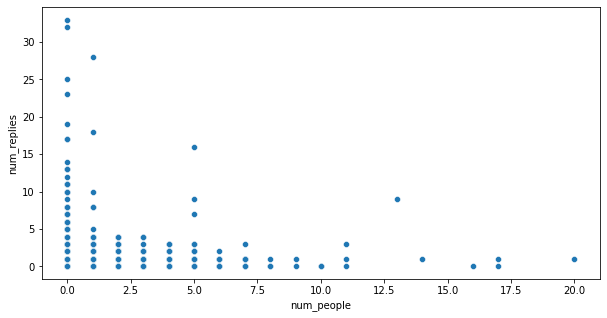

In [132]:
sns.scatterplot(data=people_df,x="num_people",y="num_replies")

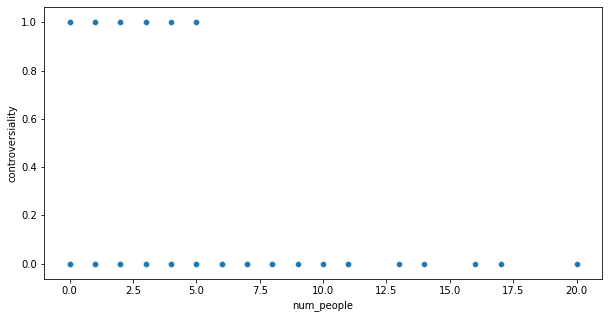

In [133]:
sns.scatterplot(data=people_df,x="num_people",y="controversiality")

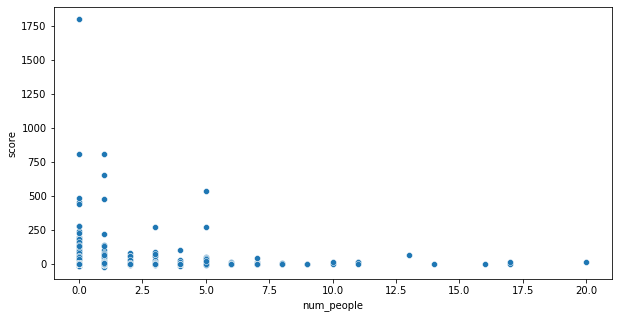

In [134]:
ax = sns.scatterplot(data=people_df,x="num_people",y="score")

### old--before stanza processing

In [21]:
NE_stance_dict = pd.read_pickle('/u/scr/yiweil/GWStance/4_analyses/NE_stance_dict.pkl')
NE_fuzzy_map = pd.read_pickle('/u/scr/yiweil/GWStance/4_analyses/named_entity_fuzzymatch_map.pkl')
people_set = set([re.sub('[^A-Za-z0-9]+', ' ', x) for x in NE_fuzzy_map.keys()])
print('Using set of {} people and variants of their names.'.format(len(people_set)))

PEOPLE = set([
    'greta thunberg',
    'al gore',
    'donald trump'
    'joe biden',
    ''
])

false_people = {'politics',
' s',' s ',
'drill',
'drilling',
'fox news',
'propublica',
'politico',
'uber',
'twitter',
'facebook',
'factbook',
'the fossil fuel industry',
'lyft',
'the justice department',
'grist',
'NOAA',
'forbes',
'vox',
'un',
'the un',
'CDC',
'FDA',
'NIH',
'nasa',
'greenpeace',
'the new york times',
'the denier',
'the green movement',
'a young daughter',
'new york times',
'the world health organization',
'exxonmobil',
'the anthropocene',
'the daily caller',
'the united nations',
'National Aeronautics and Space Administration',
'the coalition government',
'the new england journal of medicine',
' green energy company',
'the leader of the most powerful nation on earth',
'mother jones',
'anthropocene',
'the sierra club',
'u n ','the national institutes of health','the growth of renewable energy','exxonmobile',
'hurricane maria','the environmental protection agency','the scientific consensus on the issue',
'the union jack'}

people_set = people_set.difference(false_people)
print('Filtered down to set of {} people and variants of their names.'.format(len(people_set)))

Using set of 6485 people and variants of their names.
Filtered down to set of 6435 people and variants of their names.


In [78]:
import re
people_pat = re.compile(r'\b(' + (r'|'.join([kw.replace('*','\*') for kw in people_set])) + r')\b')
def contains_keyword(s,pat,keyword_set,verbose=False):
    #print(set(pat.findall(remove_special_chars(s))).intersection(keyword_set))
    res = set(pat.findall(s)).intersection(keyword_set)
    if verbose:
        return res
    return len(res) > 0

def has_person(utt,people_pat,people_set,verbose=False):
    clean_utt = re.sub('[^A-Za-z0-9]+', ' ', utt)
    return contains_keyword(utt,people_pat,people_set,verbose=verbose)

# for utt in tqdm(filtered_gen_reddit_corpus.iter_utterances()):
#     utt.meta['entities_in_text'] = has_person(utt.text,people_pat,people_set,verbose=True)
for utt in tqdm(filtered_cmv_subsample.iter_utterances()):
    utt.meta['entities_in_text'] = has_person(utt.text,people_pat,people_set,verbose=True)

509it [00:21, 24.01it/s]


KeyboardInterrupt: 

In [153]:
utts_with_people = [utt.id for utt in filtered_gen_reddit_corpus.iter_utterances()
                    if utt.meta['entities_in_text']]

In [154]:
people_found = [item for sublist in [filtered_gen_reddit_corpus.get_utterance(utt_id).meta['entities_in_text']
                for utt_id in utts_with_people] for item in sublist]
len(people_found)

527

In [155]:
counted_people_found = Counter(people_found)
len(counted_people_found)

26

In [156]:
counted_people_found

Counter({'politics ': 426,
         'ted cruz': 4,
         ' biden ': 2,
         ' jones ': 17,
         ' donald trump': 7,
         'President Trump': 28,
         'Mr Trump': 1,
         'elon musk': 13,
         'bill gates': 2,
         'jordan peterson': 1,
         'alex jones': 6,
         'john mccain': 2,
         'charles': 3,
         'donald trump': 1,
         'sean hannity': 1,
         'jeff bezos': 2,
         'bill clinton': 1,
         'harvey weinstein': 1,
         'aoc': 1,
         'bernie sanders': 1,
         ' bernie sanders ': 1,
         'boris johnson': 1,
         'george bush': 1,
         'joe biden': 1,
         'hillary clinton': 2,
         'david attenborough': 1})

In [157]:
false_people |= {
    'politics ',
}

In [158]:
for utt in tqdm(filtered_gen_reddit_corpus.iter_utterances()):
    utt.meta['cleaned_entities_in_text'] = set(utt.meta['entities_in_text']).difference(false_people)

270501it [00:01, 268570.24it/s]


In [181]:
utts_with_people = [utt.id for utt in filtered_gen_reddit_corpus.iter_utterances()
                    if utt.meta['cleaned_entities_in_text']]

In [183]:
len(utts_with_people)

101

In [184]:
people_found = [item for sublist in 
                [filtered_gen_reddit_corpus.get_utterance(utt_id).meta['cleaned_entities_in_text']
                for utt_id in utts_with_people] for item in sublist]
len(people_found)

101

In [185]:
Counter(people_found)

Counter({'ted cruz': 4,
         ' biden ': 2,
         ' jones ': 17,
         ' donald trump': 7,
         'President Trump': 28,
         'Mr Trump': 1,
         'elon musk': 13,
         'bill gates': 2,
         'jordan peterson': 1,
         'alex jones': 6,
         'john mccain': 2,
         'charles': 3,
         'donald trump': 1,
         'sean hannity': 1,
         'jeff bezos': 2,
         'bill clinton': 1,
         'harvey weinstein': 1,
         'aoc': 1,
         'bernie sanders': 1,
         ' bernie sanders ': 1,
         'boris johnson': 1,
         'george bush': 1,
         'joe biden': 1,
         'hillary clinton': 2,
         'david attenborough': 1})

## DeSMOG features

In [104]:
desmog_feats_dict = defaultdict(list)
for fname in glob.glob('/u/scr/yiweil/GWStance/4_analyses/lexicons/*.txt'):
    feats_cat = fname.split('/')[-1].split('.txt')[0]
    with open(fname,'r') as f:
        desmog_feats_dict[feats_cat].extend(f.read().splitlines())

In [105]:
desmog_feats_dict.keys()

dict_keys(['ANTI_WORDS', 'AFFIRM_WORDS', 'SCI_WORDS', 'VERBS_WORDS', 'DOUBT_WORDS', 'PRO_WORDS'])

# Engagement

Create balanced-ish sample of comments from cc- and non-cc-related threads 
for plotting efficiency: `random_ids_to_plot`

In [41]:
# for corp_name in corp_to_analyze:
#     #if 
#     non_cc_ids_to_keep = [utt for utt in filtered_cmv_subsample.iter_utterances()
#                          if not utt.meta['is_cc_related']]
#     cc_ids_to_keep = list(set(filtered_cmv_subsample.get_utterance_ids()).difference(
#         set(non_cc_ids_to_keep)))
#     random_sample_size = 5000
#     print("Drawing random sample of {} from {} non-climate comments for plotting efficiency.".format(
#         random_sample_size,len(non_cc_ids_to_keep)))
#     random_non_cc_ids_to_plot = list(np.random.choice(non_cc_ids_to_keep,size=random_sample_size,replace=False))
#     random_cc_ids_to_plot = list(np.random.choice(cc_ids_to_keep,size=random_sample_size,replace=False))
#     random_ids_to_plot = random_non_cc_ids_to_plot + list(random_cc_ids_to_plot)
#     print("Final size of random sample of climate-related and non-climate comments:",len(random_ids_to_plot))

Drawing random sample of 5000 from 756554 non-climate comments for plotting efficiency.
Final size of random sample of climate-related and non-climate comments: 10000


In [131]:
gen_reddit_utt = corp_to_analyze['gen_reddit'].random_utterance()

In [132]:
gen_reddit_utt.meta

{'score': 7,
 'top_level_comment': 'e5iu8pm',
 'retrieved_on': 1538758820,
 'gilded': 0,
 'gildings': {'gid_1': 0, 'gid_2': 0, 'gid_3': 0},
 'subreddit': 'baseball',
 'stickied': False,
 'permalink': '/r/baseball/comments/9dnjws/sources_tell_wdiv_detroit_that_altercation_among/e5j9ph8/',
 'author_flair_text': 'MIL bandwagon',
 'written_by_bot': False,
 'senti_arousal_cat': 'hi_neg_neut_pos'}

In [133]:
gen_reddit_utt.reply_to

'e5j14b1'

In [137]:
corp_to_analyze['gen_reddit'].get_conversation(gen_reddit_utt.conversation_id).meta

{'title': "Sources tell WDIV Detroit that altercation among Tigers' broadcasting duo involved color commentator Rod Allen choking play- by-play man Mario Impemba because of a chair in the broadcast booth",
 'num_comments': 404,
 'domain': 'clickondetroit.com',
 'timestamp': 1536270856,
 'subreddit': 'baseball',
 'gilded': 0,
 'gildings': {'gid_1': 0, 'gid_2': 0, 'gid_3': 0},
 'stickied': False,
 'author_flair_text': 'Detroit Tigers'}

In [157]:
len("Removed, see comment rule 3")

27

In [115]:
utt_eng_zip = list(zip([utt.meta['score'] for utt in filtered_cmv_subsample.iter_utterances()],
                       [utt.meta['ups'] for utt in filtered_cmv_subsample.iter_utterances()],
                       [utt.meta['downs'] for utt in filtered_cmv_subsample.iter_utterances()],
                       [utt.meta['is_awarded_delta'] for utt in filtered_cmv_subsample.iter_utterances()],
                       [utt.meta['is_cc_related'] for utt in filtered_cmv_subsample.iter_utterances()],
                      [len(utt.meta['reply_ids']) if 'reply_ids' in utt.meta else 0
                       for utt in filtered_cmv_subsample.iter_utterances()],
                      [utt.id
                       for utt in filtered_cmv_subsample.iter_utterances()]))


eng_df = pd.DataFrame({
    'score':[item[0] for item in utt_eng_zip],
    'ups':[item[1] for item in utt_eng_zip],
    'log_ups':[np.log(item[1]+1) for item in utt_eng_zip],
    'downs':[item[2] for item in utt_eng_zip],
    'log_downs':[np.log(item[2]+1) for item in utt_eng_zip],
    'is_awarded_delta':[item[3] for item in utt_eng_zip],
    'is_cc_related':[item[4] for item in utt_eng_zip],
    'num_replies':[item[5] for item in utt_eng_zip],
    'log_num_replies':[np.log(item[5]+1) for item in utt_eng_zip],
    'id':[item[6] for item in utt_eng_zip]
})

eng_df.describe()

NameError: name 'filtered_cmv_subsample' is not defined

## Relationship/distribution of engagement variables

In [120]:
import scipy.stats as stats
stats.pearsonr(eng_df['score'].values,eng_df['log_num_replies'].values)

(0.26922011147959785, 0.0)

In [117]:
stats.spearmanr(eng_df['score'].values,eng_df['num_replies'].values)

SpearmanrResult(correlation=0.3023072129391767, pvalue=0.0)

Text(0, 0.5, 'Log num replies')

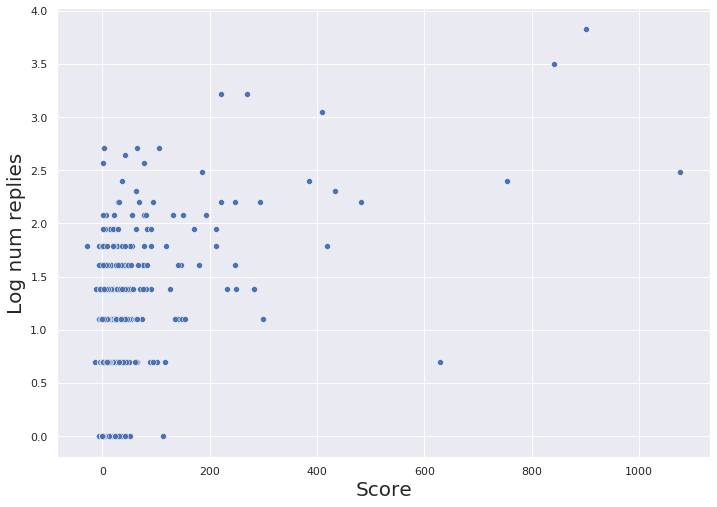

In [131]:
#random_ids_to_plot = set(random_ids_to_plot)
ax = sns.scatterplot(data=eng_df.loc[eng_df['id'].isin(random_ids_to_plot)],
               x='score',y='log_num_replies')
ax.set_xlabel("Score",fontsize=20)
ax.set_ylabel("Log num replies",fontsize=20)

#g.ax_marg_x.set_xlim(0, 100)
#g.ax_joint.set_xscale('log')
#g.ax_joint.set_yscale('log')

#ax.set(xscale="log")#, xscale="log")

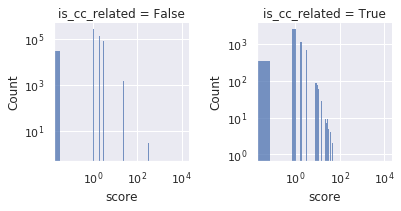

In [155]:
g = sns.FacetGrid(eng_df, col="is_cc_related", sharey=False)#, aspect=1.5)
g.map(sns.histplot, "score")
g.set(xscale="log", yscale="log")
plt.savefig('figs/log_log_score_dist.png',dpi=150,bbox_inches="tight")

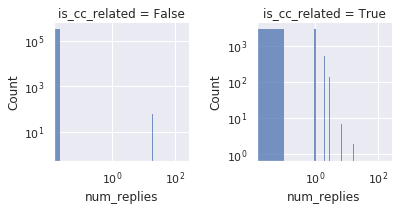

In [142]:
g = sns.FacetGrid(eng_df, col="is_cc_related", sharey=False)#, aspect=1.5)
g.map(sns.histplot, "num_replies")
g.set(yscale="log",xscale="log")#, yscale="log")

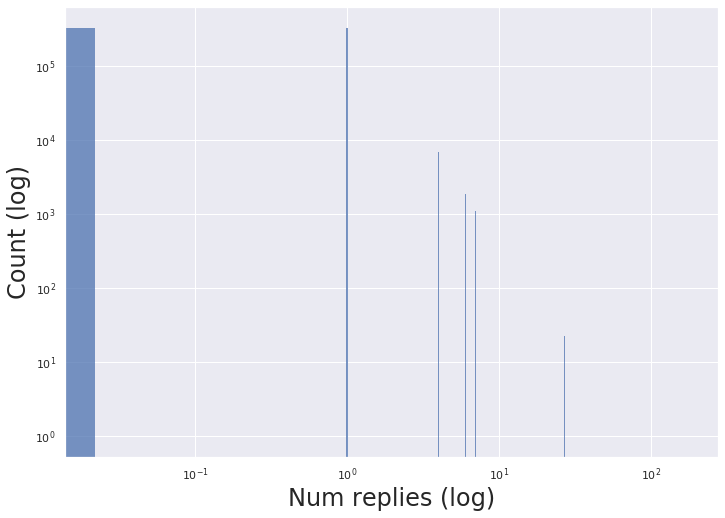

In [153]:
ax = sns.histplot(data=eng_df,x='num_replies')
ax.set(yscale="log")
ax.set(xscale="log")
ax.set_xlabel("Num replies (log)",fontsize=24)
ax.set_ylabel("Count (log)",fontsize=24)
plt.savefig('figs/log_log_num_replies_dist.png',dpi=150,bbox_inches='tight')

/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


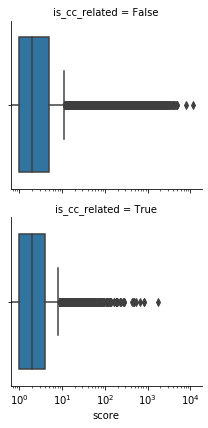

In [54]:
g = sns.FacetGrid(eng_df, row="is_cc_related", sharex=True)#, aspect=1.5)
g.map(sns.boxplot, "score")
g.set(xscale="log")#, yscale="log")

/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


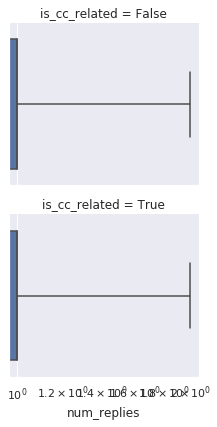

In [132]:
g = sns.FacetGrid(eng_df, row="is_cc_related", sharex=True)#, aspect=1.5)
g.map(sns.boxplot, "num_replies", showfliers=False)
g.set(xscale="log")#, yscale="log")

In [169]:
utt_eng_zip = list(zip([utt.meta['score'] for utt in filtered_gen_reddit_corpus.iter_utterances()],
                       [utt.id for utt in filtered_gen_reddit_corpus.iter_utterances()]))
                       #[utt.meta['downs'] for utt in filtered_gen_reddit_corpus.iter_utterances()]))

eng_df = pd.DataFrame({
    'score':[item[0] for item in utt_eng_zip],
    'id':[item[1] for item in utt_eng_zip]
    #'log_score':[np.log(item[0]+1) for item in utt_zip],
    #'ups':[item[1] for item in utt_eng_zip],
    #'log_ups':[np.log(item[1]+1) for item in utt_eng_zip],
    #'downs':[item[2] for item in utt_eng_zip],
    #'log_downs':[np.log(item[2]+1) for item in utt_eng_zip],
    #'upvote_ratio':[item[1]/(item[2]+.1) for item in utt_eng_zip]
})

eng_df.describe()

,score
count,270501.000000
mean,151.237104
std,2393.677951
min,-698.000000
25%,1.000000
50%,2.000000
75%,8.000000
max,195757.000000


[None, None]

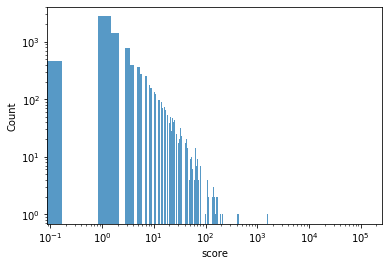

In [170]:
random_gen_reddit_sample_to_plot = set(np.random.choice(filtered_gen_reddit_corpus.get_utterance_ids(),
                                                   size=10000,replace=False))
ax = sns.histplot(data=eng_df.loc[eng_df['id'].isin(random_gen_reddit_sample_to_plot)], x="score")
ax.set(xscale="log", yscale="log")

## Correlation of engagement with features of interest: arousal, NEs

### cmv delta-matched subsample


In [81]:
eng_df['senti_arousal_cats'] = [utt.meta['senti_arousal_cats'] 
                               for utt in filtered_cmv_subsample.iter_utterances()]
eng_df['senti_arousal_cats'] = eng_df['senti_arousal_cats'].apply(
    lambda x: '_'.join(sorted(x)))#.value_counts()
eng_df['senti_arousal_cats'].value_counts()

hi_neg_hi_pos        251081
hi_neg_lo_pos        156390
hi_pos_lo_neg        100206
lo_neg_lo_pos         82631
hi_neg_neut_pos       65974
lo_neg_neut_pos       46495
lo_pos_neut_neg       23121
hi_pos_neut_neg       20489
neut_neg_neut_pos     16557
Name: senti_arousal_cats, dtype: int64

In [109]:
eng_df['senti_arousal_cats'] = [utt.meta['senti_arousal_cat'] 
                               for utt in filtered_gen_reddit.iter_utterances()]
eng_df['senti_arousal_cats'] = eng_df['senti_arousal_cats'].apply(
    lambda x: '_'.join(sorted(x))
if type(x) == list else None)#.value_counts()
eng_df['senti_arousal_cats'].value_counts()

neut_neg_neut_pos    78822
lo_pos_neut_neg      32459
lo_neg_neut_pos      28458
hi_neg_neut_pos      28240
hi_pos_neut_neg      24467
hi_neg_hi_pos        23634
hi_neg_lo_pos        21948
lo_neg_lo_pos        17276
hi_pos_lo_neg        14934
Name: senti_arousal_cats, dtype: int64

/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


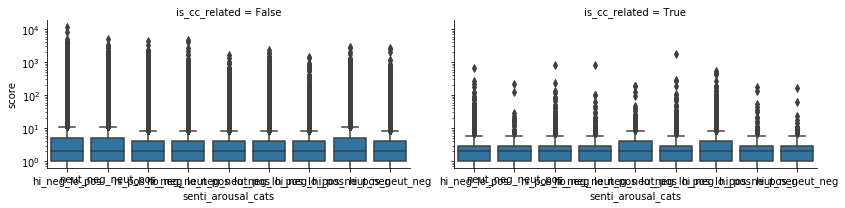

In [82]:
# Distribution over scores for different arousal categories--very even
g = sns.FacetGrid(eng_df, col = 'is_cc_related', aspect=2)
g.map(sns.boxplot, 'senti_arousal_cats', 'score', showfliers=True,)
           #order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'])
g.set(yscale="log")

/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


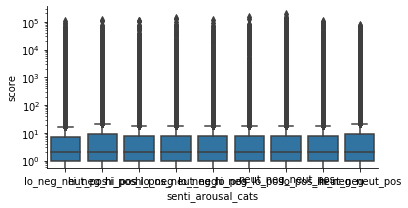

In [111]:
# Distribution over scores for different arousal categories--very even
g = sns.FacetGrid(eng_df, aspect=2)
g.map(sns.boxplot, 'senti_arousal_cats', 'score', showfliers=True,)
           #order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'])
g.set(yscale="log")

/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


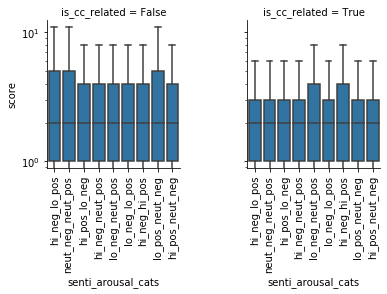

In [83]:
# Fig 1
# Same as above, without outliers--still very even
g = sns.FacetGrid(eng_df, col = 'is_cc_related')
g.map(sns.boxplot, 'senti_arousal_cats', 'score', showfliers=False,)
           #order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'])
#g.set(yscale="log")
for ax in g.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.savefig('figs/score_v_senti_arousal.png',bbox_inches="tight",dpi=150)

[Text(0, 0, 'lo_neg_neut_pos'),
 Text(0, 0, 'hi_neg_hi_pos'),
 Text(0, 0, 'hi_pos_lo_neg'),
 Text(0, 0, 'hi_pos_neut_neg'),
 Text(0, 0, 'lo_neg_lo_pos'),
 Text(0, 0, 'hi_neg_lo_pos'),
 Text(0, 0, 'neut_neg_neut_pos'),
 Text(0, 0, 'lo_pos_neut_neg'),
 Text(0, 0, 'hi_neg_neut_pos')]

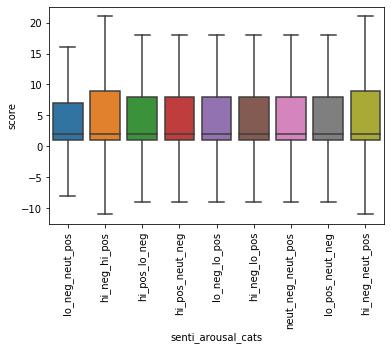

In [114]:
# Fig 
# Same as above, without outliers--still very even
#g = sns.FacetGrid(eng_df)#, col = 'is_cc_related')
ax = sns.boxplot(data=eng_df, x='senti_arousal_cats', y='score', showfliers=False,)
           #order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'])
#ax.set(yscale="log")
#for ax in g.axes.ravel():
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
#plt.savefig('figs/score_v_senti_arousal.png',bbox_inches="tight",dpi=150)

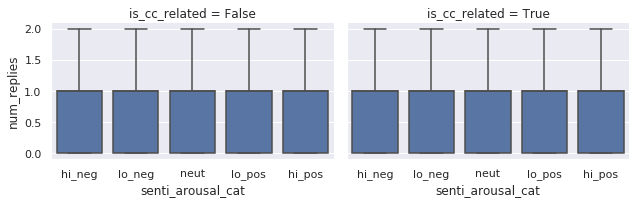

In [146]:
# Distribution over num_replies for different arousal categories--very even
#eng_df['senti_arousal_cat'] = [utt.meta['senti_arousal_cat'] for utt in filtered_cmv_subsample.iter_utterances()]
g = sns.FacetGrid(eng_df, col = 'is_cc_related', aspect=1.5)
g.map(sns.boxplot, 'senti_arousal_cat', 'num_replies', showfliers=False,
           order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'])
#g.set(yscale="log")

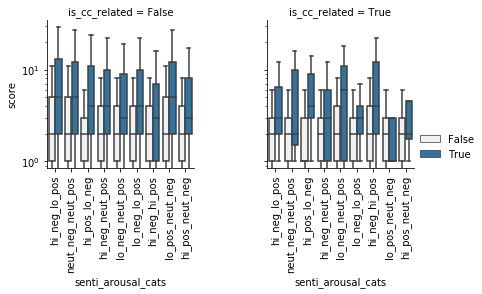

In [84]:
# Fig 2
# what about conditioned on whether or not a comment got a delta?
# score is still independent it seems of arousal for comments w/o delta
# HOWEVER, score varies across arousal category for comments w/ delta

g = sns.FacetGrid(eng_df, col = 'is_cc_related')#, hue='is_awarded_delta')
g.map_dataframe(sns.boxplot, x='senti_arousal_cats', y='score', showfliers=False,
           
               hue='is_awarded_delta')
g.set(yscale="log")
g.add_legend()
for ax in g.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

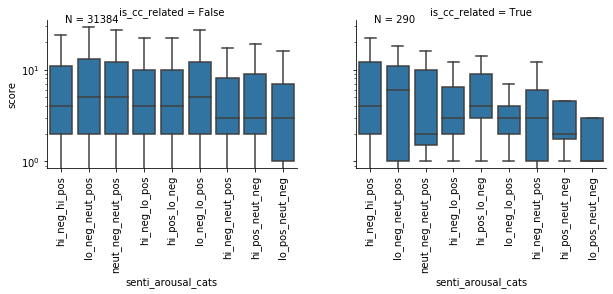

In [85]:
# Fig 3 
# looking only at comments w/ delta:
    # it seems for comments on non-climate-related posts, high arousal ~ high score
    # for comments on climate-related posts (much smaller N), situation is a bit non-linear
    
def annotate(data, **kws):
    n = len(data)
    ax = plt.gca()
    ax.text(.07, .99, f"N = {n}", transform=ax.transAxes)

g = sns.FacetGrid(eng_df.loc[eng_df['is_awarded_delta']], col = 'is_cc_related', aspect=1.5)
g.map_dataframe(sns.boxplot, x='senti_arousal_cats', y='score', showfliers=False,)
           #order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'])
g.set(yscale="log")
g.map_dataframe(annotate)
for ax in g.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

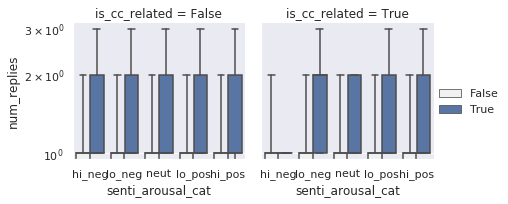

In [136]:
# what about conditioned on whether or not a comment got a delta?
# score is still independent it seems of arousal for comments w/o delta
# HOWEVER, score varies across arousal category for comments w/ delta

g = sns.FacetGrid(eng_df, col = 'is_cc_related')#, hue='is_awarded_delta')
g.map_dataframe(sns.boxplot, x='senti_arousal_cat', y='num_replies', showfliers=False,
           order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'],
               hue='is_awarded_delta')
g.set(yscale="log")
g.add_legend()

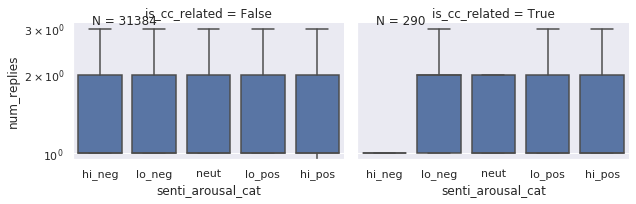

In [139]:
g = sns.FacetGrid(eng_df.loc[eng_df['is_awarded_delta']], col = 'is_cc_related', aspect=1.5)
g.map_dataframe(sns.boxplot, x='senti_arousal_cat', y='num_replies', showfliers=False,
           order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'])
g.set(yscale="log")
g.map_dataframe(annotate)

In [157]:
# Does score differ for comments w/ and w/o people?

eng_df['has_person'] = [len(filtered_cmv_subsample.get_utterance(utt_id).meta['cleaned_entities_in_text']) > 0
                              for utt_id in random_ids_to_plot]

g = sns.FacetGrid(eng_df, col = 'is_cc_related')
g.map(sns.boxplot, 'has_person', 'score', showfliers=True)
g.set(yscale="log")

KeyError: 'cleaned_entities_in_text'

In [ ]:
# Add deltas into the picture
sns.boxplot(data=eng_df, x='has_person', y='score', showfliers=False,
           hue='is_awarded_delta')

### General Reddit subsample

[None]

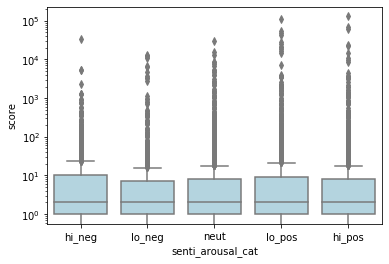

In [176]:
eng_df['senti_arousal_cat'] = [utt.meta['senti_arousal_cat']
                              for utt in filtered_gen_reddit_corpus.iter_utterances()]
ax = sns.boxplot(data=eng_df.loc[eng_df['id'].isin(random_gen_reddit_sample_to_plot)], 
                 x='senti_arousal_cat', y='score', showfliers=True,
               order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'],color='lightblue')
ax.set(yscale="log")

[None]

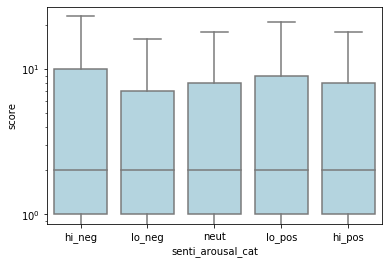

In [178]:
# without outliers
ax = sns.boxplot(data=eng_df.loc[eng_df['id'].isin(random_gen_reddit_sample_to_plot)], 
                 x='senti_arousal_cat', y='score', showfliers=False,
               order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'],color='lightblue')
ax.set(yscale="log")

In [193]:
eng_df['has_person'] = [len(utt.meta['cleaned_entities_in_text']) > 0
                              for utt in filtered_gen_reddit_corpus.iter_utterances()]
eng_df['has_person'].value_counts()

False    270400
True        101
Name: has_person, dtype: int64

[None]

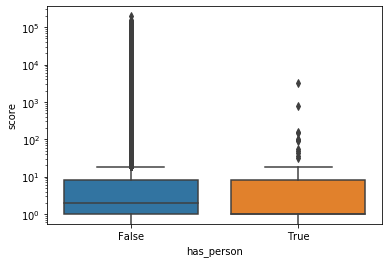

In [194]:
eng_df['has_person'] = [len(utt.meta['cleaned_entities_in_text']) > 0
                              for utt in filtered_gen_reddit_corpus.iter_utterances()]

ax = sns.boxplot(data=eng_df, 
                 x='has_person', y='score', showfliers=True)
ax.set(yscale="log")

# Comments receiving deltas vs. not

Maintain list of comments awarded deltas by:

iterating through all comment utterances

if: speaker.isin(known_mods) AND comment begins with a CUE_START
    
    save: id of mod comment, 
    comment awarding the delta (mod comment's reply_to parent),
    comment awarded the delta (comment awarding the delta's reply_to)

In [92]:
# CUE_STARTS = {'Confirmed: 1 delta awarded to /u/',
#              'Confirmed - 1 delta awarded to /u/',
#              'The moderators have confirmed, ei'}

# with open(os.path.join(DISK_IO_DIR,'deltalog.tsv'),'w') as f:
#     f.write('{}\t{}\t{}\n'.format('logging_utt_id','awarding_utt_id',
#                                   'awarded_utt_id'))
#     for utterance in tqdm(corpus.iter_utterances()):
#         if utterance.speaker.id in known_cmv_mods\
#         and (utterance.text.startswith('Confirmed: 1 delta awarded to /u/')\
#              or utterance.text.startswith('Confirmed - 1 delta awarded to /u/')\
#              or utterance.text.startswith('The moderators have confirmed, ei')):
#             logging_comment_id = utterance.id
#             awarding_comment_id = utterance.reply_to
#             awarded_comment_id = corpus.get_utterance(awarding_comment_id)\
#                                         .reply_to
#             f.write('{}\t{}\t{}\n'.format(
#                 logging_comment_id,awarding_comment_id,
#                     awarded_comment_id))

deltalog = pd.read_csv(os.path.join('/u/scr/yiweil/Green-American-Lexicon/1_data_collection/reddit',
                                    'deltalog.tsv'),
                      sep='\t',header=0)
delta_awarded_utt_ids = set(deltalog['awarded_utt_id'].values)
delta_counts = deltalog['awarded_utt_id'].value_counts()
utt_id2num_deltas = {id_: delta_counts[id_] for id_ in delta_counts.index.values}

# Update meta to include whether an utterance was awarded a delta or not
def is_awarded_delta(utterance_id):
    return utterance_id in delta_awarded_utt_ids

def num_deltas(utterance_id):
    if utterance_id in delta_awarded_utt_ids:
        return utt_id2num_deltas[utterance_id]
    else:
        return 0

for corp_name in corp_to_analyze:
    if corp_name in {'full', 'matched_cmv_subsample', 'matched_cc_cmv_subsample'}:
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            utt.meta['is_awarded_delta'] = is_awarded_delta(utt.id)
            utt.meta['num_deltas'] = num_deltas(utt.id)

6349it [00:00, 91033.09it/s]


Examine comments getting the most deltas:

In [58]:
delta_counts

t1_d498qau    36
t1_h4hrvgr    28
t1_ehuop0f    15
t1_cg7nbsu    14
t1_c9xf9b1    13
              ..
t1_h0735d6     1
t1_gm1gfmm     1
t1_dozxucl     1
t1_eh7bzti     1
t1_ctsigef     1
Name: awarded_utt_id, Length: 33702, dtype: int64

In [ ]:
# # examples
# pd.DataFrame({'text':[corp_to_analyze['matched_cmv_subsample'].get_utterance(utt_id).text
#           for utt_id in delta_counts.index.values[:10]],
#              'num_deltas':[delta_counts[utt_id] for utt_id in delta_counts.index.values[:10]]})

Within cc-related discussions:

In [65]:
cc_ids = set(corp_to_analyze['matched_cc_cmv_subsample'].get_utterance_ids())
print(len(cc_ids))
delta_counts.loc[delta_counts.index.isin(cc_ids)]

6349


t1_dl1zf88    2
t1_dh1bhuq    2
t1_f3xknsc    2
t1_efr2kcr    1
t1_dhd1ud8    1
             ..
t1_ha2hgif    1
t1_h8x5n7z    1
t1_e7gts5n    1
t1_h3fx0yw    1
t1_d8vwrpw    1
Name: awarded_utt_id, Length: 290, dtype: int64

In [ ]:
# pd.DataFrame({'text':[corp_to_analyze['matched_cmv_subsample'].get_utterance(utt_id).text
#           for utt_id in delta_counts.loc[delta_counts.index.isin(cc_ids)].index.values[:10]],
#              'num_deltas':[delta_counts[utt_id] 
#                            for utt_id in delta_counts.loc[delta_counts.index.isin(cc_ids)].index.values[:10]]})

In [ ]:
# for corp_name in corp_to_analyze:
#     if corp_name in {'full', 'matched_cmv_subsample', 'matched_cc_cmv_subsample'}:
#         sns.displot([utt.meta['num_deltas'] for utt in corp_to_analyze[corp_name].iter_utterances()],
#                    log_scale=(False,True))
#         #plt.set_yscale
#         plt.title(f'Distribution of deltas in {corp_name}',fontsize=22)
#         plt.xlabel("Num deltas awarded comment",fontsize=20)
#         plt.ylabel("Num comments",fontsize=20)
#         plt.savefig(f'figs/dist_num_deltas_{corp_name}.png',dpi=150,bbox_inches="tight")

In [ ]:
#for corp_name in corp_to_analyze:
    if corp_name in {'full', 'matched_cmv_subsample', 'matched_cc_cmv_subsample'}:
        to_plot_df = pd.DataFrame({
            'num_deltas': [utt.meta['num_deltas'] for utt in corp_to_analyze[corp_name].iter_utterances()],
            'score': [utt.meta['score'] for utt in corp_to_analyze[corp_name].iter_utterances()],
            #'num_people':[len(utt.meta['people']) for utt in corp_to_analyze[corp_name].iter_utterances()],
            'senti_arousal_cat':[utt.meta['senti_arousal_cat']
                                 if utt.meta['senti_arousal_cat']
                                else None
                                for utt in corp_to_analyze[corp_name].iter_utterances()],
        })
        for i,val in enumerate(['pos','neg']):
            to_plot_df['{}_arousal'.format(val)] = to_plot_df['senti_arousal_cat'].apply(
                lambda x: x.split('_{}'.format(val))[0].split('_')[-1]
                if type(x) == str else None
            )
            if i%2 == 1:
                categories=['hi','lo','neut']
            else:
                categories=['neut','lo','hi']
            to_plot_df['{}_arousal'.format(val)] = pd.Categorical(
                                                      to_plot_df['{}_arousal'.format(val)],
                                                      categories=categories,
                                                      ordered=True)
        sns.scatterplot(data=to_plot_df,x='num_deltas',y='score')
        plt.title("Score vs. num deltas")

In [ ]:
# g = sns.FacetGrid(to_plot_df, aspect=1.5, col='senti_arousal_cat')
# g.map(sns.histplot, 'num_deltas', log_scale=(False,True))
# plt.title("Num deltas vs. arousal")

In [ ]:
# # Temporal trend
# for corp_name in corp_to_analyze:
#     if corp_name in {'full', 'matched_cmv_subsample', 'matched_cc_cmv_subsample'}:

#         counts_by_bin = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

#         for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
#             if utt.timestamp:
#                 year = datetime.utcfromtimestamp(utt.timestamp).year
#                 if utt.meta['is_cc_related']:
#                     if utt.meta['is_awarded_delta']:
#                         counts_by_bin[year]['climate change']['awarded delta'] += 1
#                     else:
#                         counts_by_bin[year]['climate change']['not awarded delta'] += 1
#                 else:
#                     if utt.meta['is_awarded_delta']:
#                         counts_by_bin[year]['other']['awarded delta'] += 1
#                     else:
#                         counts_by_bin[year]['other']['not awarded delta'] += 1
                        
#         years = list(range(2013,2022))
#         topics = ['climate change','other']
#         classes = ['awarded delta','not awarded delta']
#         to_plot_df = pd.DataFrame({
#             'year':[item for sublist in 
#                     [[y]*len(topics)*len(classes) for y in years]
#                     for item in sublist],
#             'topic':[item for sublist in 
#                     [[t]*len(classes) for t in topics]
#                     for item in sublist]*len(years),
#             'class':classes*len(years)*len(topics),
#             'count':[counts_by_bin[y][t][c] for y in years for t in topics for c in classes] 
#         })
        
#         per_year_topic_totals = to_plot_df.groupby(['year','topic']).sum()
#         to_plot_df['percent'] = to_plot_df.apply(
#             lambda x: x['count']/per_year_topic_totals.loc[x['year']]\
#                                 .loc[x['topic']]['count'],
#             axis=1
#         )

#         plt.rcParams['figure.figsize'] = [10, 5]
#         sns.lineplot(data=to_plot_df.loc[to_plot_df['class']=='awarded delta'],
#                    x='year',y='percent',hue='topic',ci='sd')
#         plt.xlabel('')
#         plt.ylabel('')
#         plt.xticks(fontsize=17)
#         plt.yticks(fontsize=14)
#         plt.title('Percentage of comments awarded ∆ over time',fontsize=24)
#         plt.legend(title='',fontsize=15)
#         sns.despine()
#         plt.savefig('figs/pct_comments_awarded_delta_over_time_{}.png'.format(corp_name),
#                     dpi=200,bbox_inches="tight")

Examples of comments awarding deltas, which explain why user was persuaded:

In [289]:
comments_awarding_deltas_climate_threads = [
    utt_id for utt_id in deltalog['awarding_utt_id'].values
    if corpus.get_utterance(utt_id).meta['is_cc_related']
]
print(len(comments_awarding_deltas_climate_threads))

pd.DataFrame({
    'id':comments_awarding_deltas_climate_threads,
    'text':[corpus.get_utterance(utt_id).text
           for utt_id in comments_awarding_deltas_climate_threads]
})

319


,id,text
0,t1_ef9tzs5,∆ Yeah that's honestly a solid point it would be nice if the government could just handle it. So another solution would bne if we could just stop being so over hyped about the issue in general.\n\nOnly issue is that I think we are in way too deep for that to work. It is at the forefront of public policy right now. Plus the changes that liberals are proposing would cost trillions of dollars and have huge impact on peoples lives....which leads to yellow vests.
1,t1_h8xaroo,[deleted]
2,t1_ejjs8tf,"Your point about diminishing returns on greenhouse gas emissions (because of common infrastructure) is a good one. Indeed, I had been imagining that Western population growth leads to emissions growth in a linear fashion. So I guess I'll give you a !delta for that.\n\nHowever, I still maintain my main view that having children isn't a good solution to climate change, on account of the fact that scientific engagement in western countries just isn't high enough. Most people are not involved in energy innovation and research, which means they're producing carbon emissions without contributing to the betterment of these technologies. Maybe if my country (USA) funded its schools better and made more of a conscious drive to shift the labor force towards energy research, then I'd feel differently about this.\n\nAlso, I think that the concept of diminishing returns could apply to energy innovation as well."
3,t1_fhqpeoe,"Yes, and they have links! I love it! \n\nKeep on sciencing, good sir!\n\n!delta"
4,t1_hb50dh3,"Δ I'll buy that. Bonus points for providing why, if fixed, it would be part of the solution to other issues too. Honestly it's the worst part of any kind of activism is battling with peoples lack of awareness. Pair with apathy it's probably the most immediate threat to humanity"
...,...,...
314,t1_ds5kees,[deleted]
315,t1_dh56ffl,∆ Thank you these articles did a great job of changing my view! This gets me thinking. Do humans have a right to keep reproducing and expanding even though that conflicts with general biological conservation? And how can we regulate that conflict?
316,t1_dcsvdvw,"∆ You know, you are right, it is definitely a case of the Dunning-Kruger effect, we just don't know how much we don't know. And I should recognize it as such, also, in the same way some people are hyperbolic negative, being hyperbolic positive is not wise, I recognize now my mistake."
317,t1_et321b6,"!delta\n\nIndividual lifestyle choices may not be useful on their own, but they can inspire others to demand change."


## Which features matter in changing people's minds?

List of features:
* engagement-related features
    * people/messengers
    * +/- arousal (based on SentiStrength)
    * EmoLex
* OG CMV paper features
    * non-textual features
        * entry time
        * len of back-and-forth
        * number of participants
    * textual features
        * interplay-related features
        * word category-based features
        * word score-based features
        * entire argument features
        * markdown formatting features
* DeSMOG features
    
    
NB: OG CMV paper uses different set-up to test importance of features by finding unsuccessful argument with highest Jaccard similarity to successful argument comment and training classifier to make binary prediction as to which one was successful. Intuition: control for content.

### Compute LOR values

First get counts:

In [ ]:
UPOS = True
XPOS = False

counts_with_upos = get_counts_for_lor(corp_to_analyze['matched_cc_cmv_subsample'],
                         set([utt.id for utt in corp_to_analyze['matched_cc_cmv_subsample'].iter_utterances()
                              if utt.meta['is_awarded_delta']]),
                         [corp_to_analyze['gen_reddit'],corp_to_analyze['switchboard']],
                         'matched_cc_cmv_subsample_deltas_vs_no_deltas_gen_reddit_switchboard_prior',
                         verbose=True,
                         cache=True,
                         upos=UPOS,
                         xpos=XPOS)

# counts_no_pos = get_counts_for_lor(corp_to_analyze['matched_cc_cmv_subsample'],
#                          set([utt.id for utt in corp_to_analyze['matched_cc_cmv_subsample'].iter_utterances()
#                               if utt.meta['is_awarded_delta']]),
#                          [corp_to_analyze['gen_reddit'],corp_to_analyze['switchboard']],
#                          'matched_cc_cmv_subsample_deltas_vs_no_deltas_gen_reddit_switchboard_prior',
#                          verbose=True,
#                          cache=False,
#                          upos=False,
#                          xpos=False)

In [144]:
lor_per_corp = defaultdict(dict)

for corp_name in corp_to_analyze:
    unweighted_lor_upos = do_weighted_lor(counts_upos['counts1'], counts_upos['counts2'], 
                                         counts_upos['prior'], 
                                         prior_weight=1, 
                                         counts1_weight=1, 
                                         counts2_weight=1, 
                                         verbose=False)
    lor_per_corp[corp_name]['unweighted_upos'] = unweighted_lor_upos
    weighted_lor_upos = do_weighted_lor(counts_upos['counts1'], counts_upos['counts2'], 
                                         counts_upos['prior'], 
                                         prior_weight=100, 
                                         counts1_weight=1, 
                                         counts2_weight=15, 
                                         verbose=False)
    lor_per_corp[corp_name]['weighted_upos'] = weighted_lor_upos
    
    unweighted_lor_no_pos = do_weighted_lor(counts_no_pos['counts1'], counts_no_pos['counts2'], 
                                          counts_no_pos['prior'], 
                                          prior_weight=1, 
                                          counts1_weight=1, 
                                          counts2_weight=1, 
                                          verbose=False)
    lor_per_corp[corp_name]['unweighted_no_pos'] = unweighted_lor_no_pos
    weighted_lor_no_pos = do_weighted_lor(counts_no_pos['counts1'], counts_no_pos['counts2'], 
                                          counts_no_pos['prior'], 
                                          prior_weight=100, 
                                          counts1_weight=1, 
                                          counts2_weight=15, 
                                          verbose=False)
    lor_per_corp[corp_name]['weighted_no_pos'] = weighted_lor_no_pos

756789it [1:23:00, 151.95it/s]


Computing unweighted LOR values w/o background corpus, w/ POS info...
	Vocab size of class 1: 193611
	Vocab size of class 2: 1071031
Size of class1: 5913604
Size of class2: 107330019
Size of prior: 113243623

Computing weighted LOR values w background corpus, w/o POS info...
	Vocab size of class 1: 192893
	Vocab size of class 2: 1064447
Size of class1: 5913604
Size of class2: 7066843
Size of prior: 2302248


6349it [01:23, 75.88it/s] 


Computing unweighted LOR values w/o background corpus, w/ POS info...
	Vocab size of class 1: 6325
	Vocab size of class 2: 25448
Size of class1: 65307
Size of class2: 1052860
Size of prior: 1118167

Computing weighted LOR values w background corpus, w/o POS info...
	Vocab size of class 1: 5661
	Vocab size of class 2: 22161
Size of class1: 65307
Size of class2: 68406
Size of prior: 172887


In [81]:
# weights = 1:20
sig_vals = {w: lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w] 
 for w in lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos']
if abs(lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w]) > 1.9}
sorted(sig_vals.items(),key=lambda x:x[1],reverse=True)

[('the', 4.4302531538826235),
 ('co2', 4.016102779647343),
 ('a', 3.6958391316434254),
 ('%', 3.27900082888966),
 ('poor', 3.0976039497792205),
 ('experiment', 3.0424920188000733),
 ('dioxide', 3.0424920188000733),
 ('ocean', 2.954950657988805),
 ('carbon', 2.8240499604875784),
 ('CCP', 2.753984186194391),
 ('be', 2.6021516116289285),
 ('cycle', 2.5479712046109273),
 ('per', 2.5382071565705706),
 ('gallon', 2.448384646847179),
 ('Science', 2.448384646847179),
 ('greenhouse', 2.41632292750537),
 ('97', 2.413320700127313),
 ('action', 2.401585299286658),
 ('rich', 2.3418134481657575),
 ('ecosystem', 2.334966622594344),
 ('biodiversity', 2.325489454781162),
 ('release', 2.266239008606097),
 ('seaweed', 2.2661594089949384),
 ('methane', 2.2517828462681706),
 ('organic', 2.2405143977054625),
 ('Chinese', 2.2405143977054625),
 ('Climate', 2.221307313261586),
 ('atmosphere', 2.191767559255129),
 ('battery', 2.176345301888634),
 ('effect', 2.153029738413637),
 ('water', 2.1413696008766516),
 (

In [147]:
# cc-only; weights = 1:15; with switchboard + gen reddit background
sig_vals = {w: lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w] 
 for w in lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos']
if abs(lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w]) > 1.96}
sorted(sig_vals.items(),key=lambda x:x[1],reverse=True)

[('co2', 3.073409887010761),
 ('poor', 3.0468640464438366),
 ('experiment', 2.935999024612736),
 ('dioxide', 2.935999024612736),
 ('CCP', 2.8259325333936167),
 ('Science', 2.5652632762584426),
 ('ocean', 2.417681387726944),
 ('gallon', 2.3718752019230416),
 ('seaweed', 2.362943692821538),
 ('per', 2.354143934908629),
 ('rich', 2.251348124565579),
 ('preservation', 2.2345503013288663),
 ('chemistry', 2.2325408051593065),
 ('biodiversity', 2.2325408051593065),
 ('cycle', 2.228912483832722),
 ('%', 2.203216550745488),
 ('97', 2.1494354909751343),
 ('release', 2.1341811718403463),
 ('battery', 2.112940911364332),
 ('al.', 2.0945069435538954),
 ('ecosystem', 2.072538167736246),
 ('methane', 2.021694522720207),
 ('butcher', 1.9727312617433763),
 ('spend', -1.9854550035112353),
 ('problem', -2.1041447334295675),
 ('say', -2.165822551593976),
 ('have', -2.1837199073610107),
 ('civilization', -2.186938705088744),
 ('economist', -2.2009175638399103),
 ('drought', -2.303192177434896),
 ('you', -2

In [96]:
# cc-only; weights = 1:15; no background (just 2 samples summed)
sig_vals = {w: lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w] 
 for w in lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos']
if abs(lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w]) > 1.9}
sorted(sig_vals.items(),key=lambda x:x[1],reverse=True)

[('poor', 3.713671364499459),
 ('co2', 3.2295807306411852),
 ('experiment', 3.203951655197919),
 ('dioxide', 2.9911401258015),
 ('per', 2.8989588291733894),
 ('CCP', 2.844079322574466),
 ('rich', 2.7421704393263613),
 ('Science', 2.5946945876398217),
 ('ocean', 2.5735458269633043),
 ('release', 2.566973670172775),
 ('battery', 2.4794890558012255),
 ('gallon', 2.404942741828649),
 ('cycle', 2.401765556567715),
 ('seaweed', 2.387298764123448),
 ('%', 2.3487778703293536),
 ('chemistry', 2.3386072864477616),
 ('biodiversity', 2.265351694926317),
 ('preservation', 2.2587407880686805),
 ('97', 2.19121246662543),
 ('local', 2.172246272776472),
 ('ecosystem', 2.132717534315285),
 ('action', 2.125024904123274),
 ('al.', 2.118505571502948),
 ('unit', 2.11660533465535),
 ('methane', 2.0680575117728566),
 ('20', 1.9951863705248571),
 ('butcher', 1.99025136273504),
 ('greenhouse', 1.9743014656083901),
 ('organic', 1.9622396003718359),
 ('Chinese', 1.9622396003718359),
 ('fertilizer', 1.957498656869

In [148]:
# all CMV; weights = 1:15; with switchboard + gen reddit background
sig_vals = {w: lor_per_corp['matched_cmv_subsample']['weighted_wo_pos'][w] 
 for w in lor_per_corp['matched_cmv_subsample']['weighted_wo_pos']
if abs(lor_per_corp['matched_cmv_subsample']['weighted_wo_pos'][w]) > 1.96}
sorted(sig_vals.items(),key=lambda x:x[1],reverse=True)

[('*', 14.177567479521608),
 ('<url>', 9.78708920750381),
 ('delta', 7.695974267662889),
 ('--', 6.812311599885328),
 ('|', 6.679175870937484),
 ('often', 6.581853804565787),
 ('delta?', 5.769511712575998),
 ('delta.', 5.193649024013578),
 ('\\[[source](<url>)\\]', 5.039863498072646),
 ('award', 5.004601515539193),
 ('might', 4.9453627884685964),
 ('\\-', 4.780488804361875),
 ('-', 4.6670574823421065),
 ('pokemon', 4.666525316384888),
 ('dumbledore', 4.570879820943098),
 ('antibiotics', 4.4892817276219015),
 ('carrier', 4.467040585732278),
 ('dance', 4.419521625722625),
 ('depp', 4.276424521243516),
 ('!', 4.214180034179577),
 ('film', 4.169734069322882),
 ('first,', 4.166070179916357),
 ('superman', 4.162700901133546),
 ('mrna', 4.162388369124238),
 ('song', 4.153431349755077),
 ('[<url>](<url>)', 4.106765534187203),
 ('characters', 4.0737706440859425),
 ('3.', 4.057255991897452),
 ('finally,', 4.0213766058719225),
 ('1.', 4.012055821923846),
 ('dreads', 3.968369887556052),
 ('patient

In [145]:
# # weight = 1:10
# sig_vals = {w: lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w] 
#  for w in lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos']
# if abs(lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w]) > 1.96}
# sorted(sig_vals.items(),key=lambda x:x[1],reverse=True)

In [146]:
# # weight = 1:5
# sig_vals = {w: lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w] 
#  for w in lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos']
# if abs(lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w]) > 1.9}
# sorted(sig_vals.items(),key=lambda x:x[1],reverse=True)

### Test RQs

##### Draw random sample from -delta comments for more even sample sizes for LOR

In [68]:
cc_ids = [utt.id for utt in filtered_cmv_subsample.iter_utterances()
                         if utt.meta['is_cc_related']]
non_delta_ids_to_keep = [utt.id for utt in filtered_cmv_subsample.iter_utterances()
                         if not utt.meta['is_awarded_delta']
                        and utt.meta['is_cc_related']]
delta_ids_to_keep = set(cc_ids).difference(set(non_delta_ids_to_keep))
print('Found {} comments w/ deltas.'.format(len(delta_ids_to_keep)))

random_sample_size = len(delta_ids_to_keep)
print("Drawing random sample of equal size of {} from {} non-delta comments total for LOR balance.".format(
    random_sample_size,len(non_delta_ids_to_keep)))

random_non_delta_ids_for_lor = list(np.random.choice(non_delta_ids_to_keep,size=random_sample_size,replace=False))
random_ids_for_lor = set(list(delta_ids_to_keep) + list(random_non_delta_ids_for_lor))
print("Final size of delta-balanced sample of climate-related and non-climate comments:",len(random_ids_for_lor))

Found 290 comments w/ deltas.
Drawing random sample of equal size of 290 from 6100 non-delta comments total for LOR balance.
Final size of delta-balanced sample of climate-related and non-climate comments: 580


In [69]:
random_sample = filtered_cmv_subsample.filter_utterances_by(lambda utt: utt.id in random_ids_for_lor) 
# balanced for +/- delta
random_sample.print_summary_stats()

Number of Speakers: 434
Number of Utterances: 580
Number of Conversations: 240


In [179]:
cc_random_sample = filtered_cmv_subsample.filter_utterances_by(lambda utt: utt.id in random_ids_for_lor) 
# balanced for +/- delta
cc_random_sample.print_summary_stats()

Number of Speakers: 445
Number of Utterances: 580
Number of Conversations: 251


##### RQ1: Is there a messenger effect for changing people's minds?

--> Are comments with deltas more likely to have people/named entities 
compared to comments not receiving deltas?

--> Do people/named entities tend to have large, positive LOR values?

--> Calculate LOR values for all people/named entities and look at their distributions--tend to skew positive?

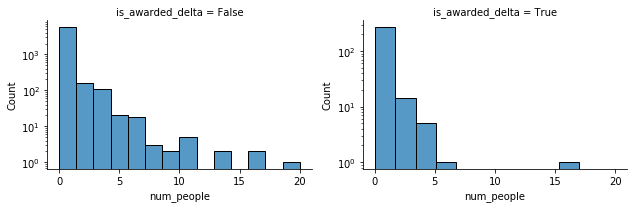

In [149]:
# Plot distribution over +/- person for comments +/- deltas

for corp_name in ['matched_cc_cmv_subsample']:#corp_to_analyze:
    to_plot_df = pd.DataFrame({
        'is_awarded_delta': [utt.meta['is_awarded_delta']
                             for utt in corp_to_analyze[corp_name].iter_utterances()],
        'num_deltas': [utt.meta['num_deltas']
                             for utt in corp_to_analyze[corp_name].iter_utterances()],
        'has_person': [len(utt.meta['people']) > 0
                       for utt in corp_to_analyze[corp_name].iter_utterances()],
        'num_people': [len(utt.meta['people'])
                       for utt in corp_to_analyze[corp_name].iter_utterances()]

    })
    # to_plot_df['senti_arousal_cat'] = pd.Categorical(to_plot_df['senti_arousal_cat'], 
    #                                                  ['hi_neg','lo_neg','neut','lo_pos','hi_pos'])

    g = sns.FacetGrid(to_plot_df, col="is_awarded_delta", sharey=False, aspect=1.5)
    g.map(sns.histplot, "num_people")
    g.axes[0][0].set_yscale('log')
    g.axes[0][1].set_yscale('log')
    plt.savefig(f'figs/people_counts_deltas_vs_no_deltas_{corp_name}.png',dpi=150,bbox_inches="tight")
    
    ax = sns.scatterplot(data=to_plot_df, x="num_people", y="num_deltas")
#     g.map(sns.histplot, "num_people")
#     g.axes[0][0].set_yscale('log')
#     g.axes[0][1].set_yscale('log')
#    plt.savefig(f'figs/people_counts_deltas_vs_no_deltas_{corp_name}.png',dpi=150,bbox_inches="tight")

In [327]:
# Check if people show up in sig. LOR
{w: lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w] 
for w in counted_people.keys()
if w in lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos']
and abs(lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w]) > 1.9}

{}

##### RQ2: Do high +/- arousal words change people's minds?

--> Are comments with deltas more likely to be high arousal?

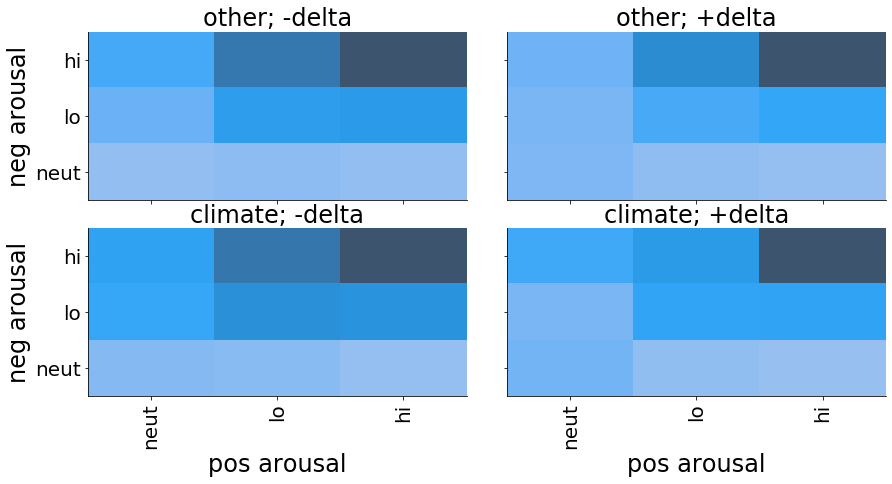

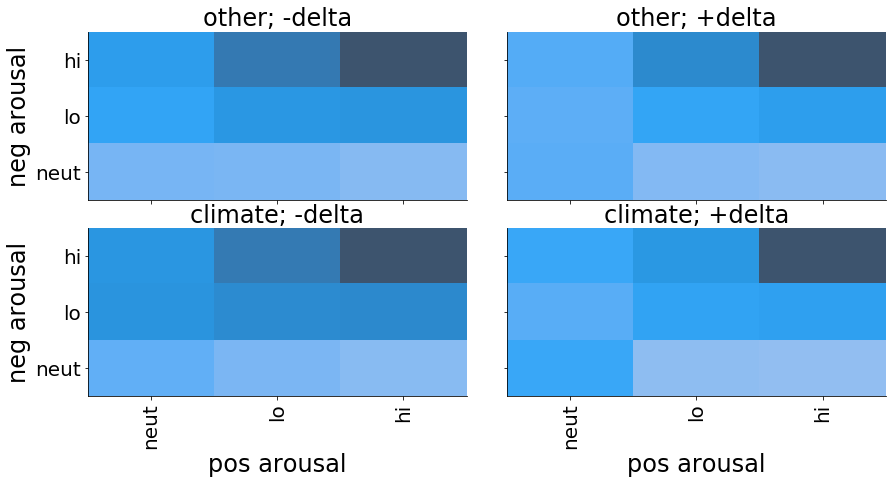

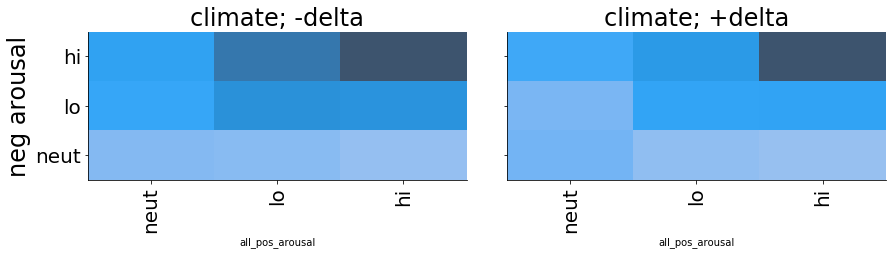

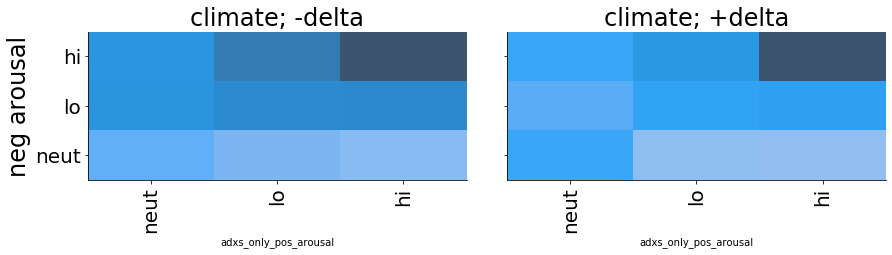

In [93]:
# Fig 4: Distribution of SentiStrength arousal categories for comments
for corp_name in corp_to_analyze:
    if 'cmv' in corp_name:
        # prep data to plot
        to_plot_df = pd.DataFrame({
            'is_awarded_delta': [utt.meta['is_awarded_delta']
                                for utt in corp_to_analyze[corp_name].iter_utterances()
                                if utt.meta['senti_all_arousal_cat']],
            'senti_all_arousal_cat': [utt.meta['senti_all_arousal_cat']
                                for utt in corp_to_analyze[corp_name].iter_utterances()
                                 if utt.meta['senti_all_arousal_cat']],
            'senti_adxs_only_arousal_cat': [utt.meta['senti_adxs_only_arousal_cat']
                                for utt in corp_to_analyze[corp_name].iter_utterances()
                                 if utt.meta['senti_all_arousal_cat']],
            'is_cc_related': [utt.meta['is_cc_related']
                                for utt in corp_to_analyze[corp_name].iter_utterances()
                             if utt.meta['senti_all_arousal_cat']]})
        
        SENTI_CATS = to_plot_df['senti_all_arousal_cat'].value_counts().index
        for senti_model in ['all','adxs_only']:
            to_plot_df[f'senti_{senti_model}_arousal_cat'] = \
            pd.Categorical(to_plot_df[f'senti_{senti_model}_arousal_cat'],
                           categories=SENTI_CATS,
                           ordered=True)
        
            # further prepping: isolate +/- SS components
            for i,val in enumerate(['pos','neg']):
                to_plot_df[f'{senti_model}_{val}_arousal'] = \
                to_plot_df[f'senti_{senti_model}_arousal_cat'].apply(
                    lambda x: x.split('_{}'.format(val))[0].split('_')[-1]
                )
                if i%2 == 1:
                    categories=['hi','lo','neut']
                else:
                    categories=['neut','lo','hi']
                to_plot_df[f'{senti_model}_{val}_arousal'] = \
                pd.Categorical(to_plot_df[f'{senti_model}_{val}_arousal'],
                               categories=categories,
                               ordered=True)

            # plotting
            g = sns.FacetGrid(to_plot_df, col="is_awarded_delta", row="is_cc_related", 
                              sharey=False, aspect=2)
            g.map(sns.histplot, f"{senti_model}_pos_arousal", f"{senti_model}_neg_arousal")
            #g.map(sns.histplot, "senti_arousal_cat")

            # aesthetics
            for ax_ix,ax in enumerate(g.axes.ravel()):
                title = ax.get_title()
                is_cc_related = title.split(' |')[0].split('= ')[-1]
                is_awarded_delta = title.split('| ')[-1].split('= ')[-1]
                if is_cc_related == 'True':
                    pretty_title = 'climate; '
                else:
                    pretty_title = 'other; '
                if is_awarded_delta == 'True':
                    pretty_title += '+delta'
                else:
                    pretty_title += '-delta'
                ax.set_title(pretty_title, fontsize=24)
                ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
                if ax_ix % 2 == 0:
                    ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)
                    ax.set_ylabel("neg arousal",fontsize=24)
                else:
                    ax.set_yticklabels('')
                if ax_ix >= 2:
                    ax.set_xlabel("pos arousal",fontsize=24)

            # saving
            plt.savefig(f'figs/senti_arousal_dist_deltas_vs_no_deltas_{corp_name}_{senti_model}.png',
                       dpi=150,bbox_inches="tight")

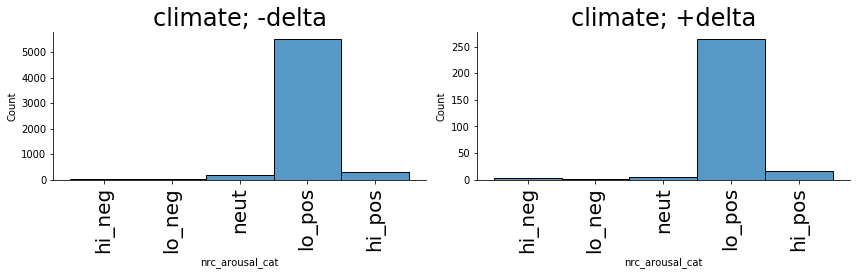

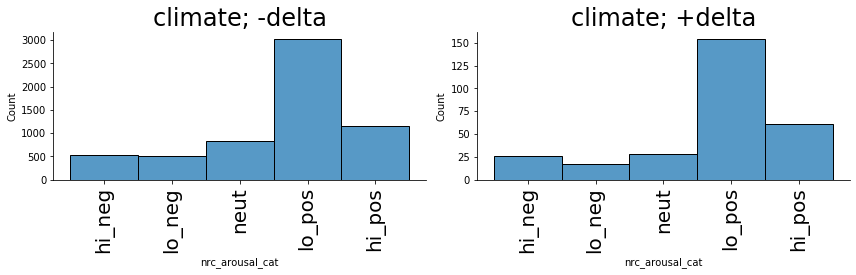

In [140]:
# Fig 5: Distribution of NRC VAD arousal categories for comments
for corp_name in ['matched_cc_cmv_subsample']:#corp_to_analyze:
    if 'cmv' in corp_name:
        for model_name in ['all','adxs_only']:
        
            # prep data to plot
            to_plot_df = pd.DataFrame({
                'is_awarded_delta': [utt.meta['is_awarded_delta']
                                     for utt in corp_to_analyze[corp_name].iter_utterances()
                                     if f'nrc_{model_name}_arousal_cat' in utt.meta 
                                     and utt.meta[f'nrc_{model_name}_arousal_cat']],
                'nrc_arousal_cat': [utt.meta[f'nrc_{model_name}_arousal_cat']
                                    for utt in corp_to_analyze[corp_name].iter_utterances()
                                    if f'nrc_{model_name}_arousal_cat' in utt.meta 
                                    and utt.meta[f'nrc_{model_name}_arousal_cat']],
                'is_cc_related': [utt.meta['is_cc_related']
                                  for utt in corp_to_analyze[corp_name].iter_utterances()
                                  if f'nrc_{model_name}_arousal_cat' in utt.meta 
                                  and utt.meta[f'nrc_{model_name}_arousal_cat']]})
            to_plot_df['nrc_arousal_cat'] = \
            pd.Categorical(to_plot_df['nrc_arousal_cat'],
            categories=['hi_neg','lo_neg','neut','lo_pos','hi_pos'],
            ordered=True)

            # plotting
            g = sns.FacetGrid(to_plot_df, col="is_awarded_delta", row="is_cc_related", 
                              sharey=False, aspect=2)
            g.map(sns.histplot, "nrc_arousal_cat")

            # aesthetics
            for ax in g.axes.ravel():
                title = ax.get_title()
                is_cc_related = title.split(' |')[0].split('= ')[-1]
                is_awarded_delta = title.split('| ')[-1].split('= ')[-1]
                if is_cc_related == 'True':
                    pretty_title = 'climate; '
                else:
                    pretty_title = 'other; '
                if is_awarded_delta == 'True':
                    pretty_title += '+delta'
                else:
                    pretty_title += '-delta'
                ax.set_title(pretty_title, fontsize=24)
                ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)

            # saving
            plt.savefig(f'figs/nrc_arousal_dist_deltas_vs_no_deltas_{corp_name}_{model_name}.png',
                       dpi=150,bbox_inches="tight")

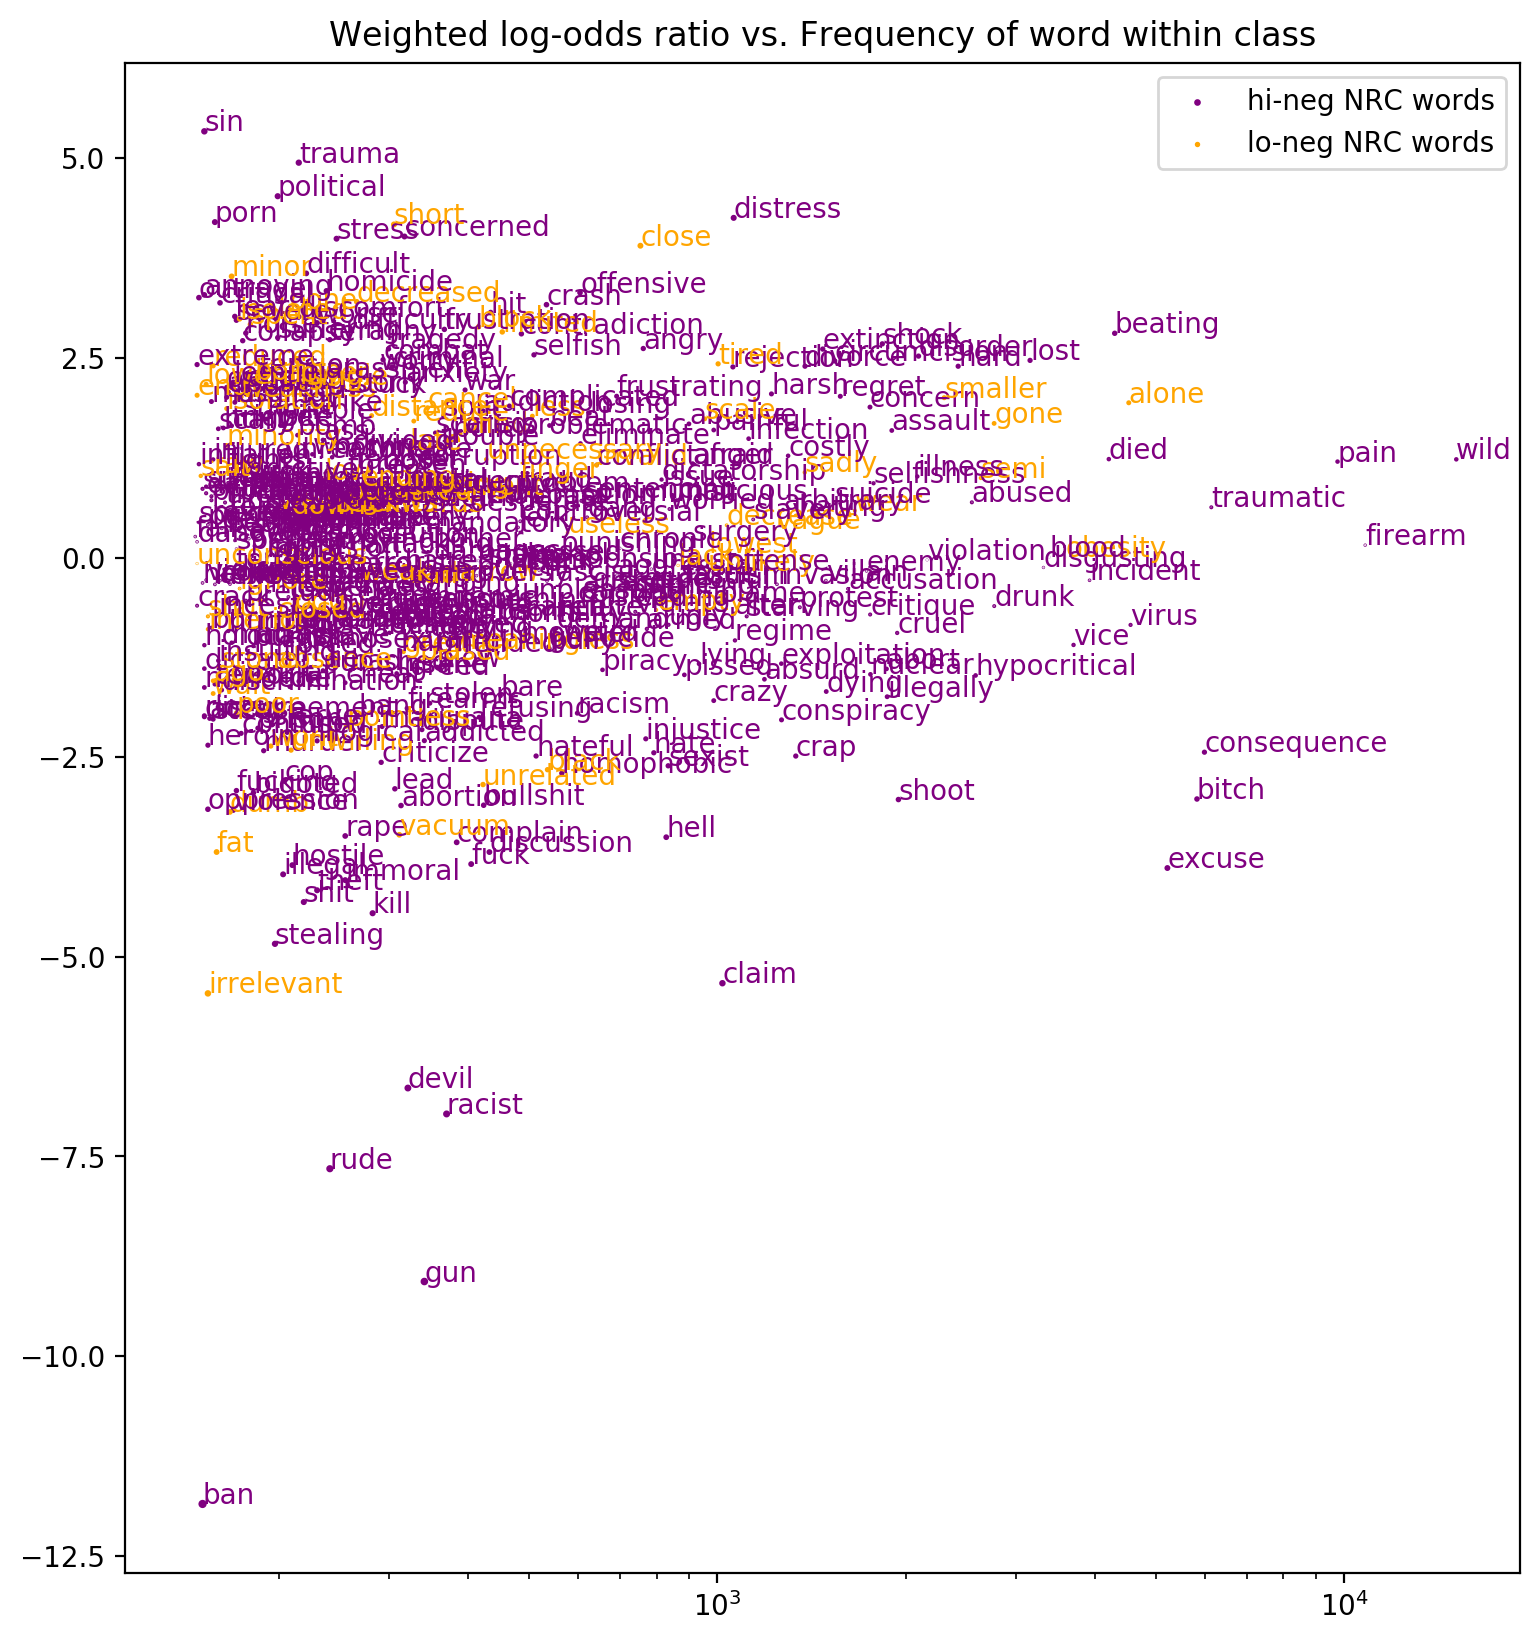

In [32]:
# no annotations of words or non-of-interest words--too crowded
fw_all_topics_no_bots.plot_fighting_words_fancy(class1_name='hi-neg NRC words', 
                                                class2_name='lo-neg NRC words', 
                                 config={'threshold': 1.96, 'annot_method': 'custom'},
                                word_set1=NRC_words_per_cat['hi_neg'],
                                word_set2=NRC_words_per_cat['lo_neg'],
                                verbose=True)

In [153]:
for corp_name in corp_to_analyze:
    #for model_name in ['all','adxs_only']:
    to_plot_df = pd.DataFrame({
        'z-score': [lor_per_corp[corp_name]['weighted_wo_pos'][w]
                    for w in lor_per_corp[corp_name]['weighted_wo_pos']],
        'nrc_arousal_cat': [word2NRC_cat[w]
                            if w in word2NRC_cat else None
                            for w in lor_per_corp[corp_name]['weighted_wo_pos']]
    })
    
    sns.boxplot(data=to_plot_df,
            x='nrc_arousal_cat',y='z-score',
            order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'],
            showfliers=False,color='dodgerblue')
    plt.ylabel("likelihood of occurring in a +delta comment",fontsize=24)
    plt.xticks(fontsize=24)
    plt.savefig(f'figs/lor_per_nrc_arousal_cat_{corp_name}.png',
                dpi=150,bbox_inches="tight")
    plt.close()

In [176]:
pd.set_option('display.max_rows', None)

In [197]:
# Check LOR values for words of derived NRC arousal cats
df_all_topics_no_bots.loc[df_all_topics_no_bots.index.isin(NRC_words_per_cat['hi_neg'])][::-1]

,z-score,class,nrc_arousal_cat
ngram,,,
sin,5.339229,+delta,hi_neg
trauma,4.946676,+delta,hi_neg
political,4.526476,+delta,hi_neg
distress,4.255409,+delta,hi_neg
porn,4.202505,+delta,hi_neg
concerned,4.022244,+delta,hi_neg
stress,3.994436,+delta,hi_neg
difficult,3.560136,+delta,hi_neg
homicide,3.341408,+delta,hi_neg


In [198]:
df_cc_no_bots.loc[df_cc_no_bots.index.isin(NRC_words_per_cat['hi_neg'])][::-1]

,z-score,class,nrc_arousal_cat
ngram,,,
extreme,2.714408,+delta,hi_neg
claim,2.619961,+delta,hi_neg
discussion,2.092369,+delta,hi_neg
war,1.862176,+delta,hi_neg
dangerous,1.845808,+delta,hi_neg
radiation,1.394837,+delta,hi_neg
killing,1.069105,+delta,hi_neg
burn,1.069105,+delta,hi_neg
concerned,0.750657,+delta,hi_neg


In [199]:
df_all_topics_no_bots.loc[df_all_topics_no_bots.index.isin(NRC_words_per_cat['lo_neg'])][::-1]

,z-score,class,nrc_arousal_cat
ngram,,,
short,4.172916,+delta,lo_neg
close,3.906505,+delta,lo_neg
minor,3.522939,+delta,lo_neg
decreased,3.204856,+delta,lo_neg
bone,3.116801,+delta,lo_neg
isolated,2.990515,+delta,lo_neg
spent,2.920450,+delta,lo_neg
block,2.890761,+delta,lo_neg
limited,2.826781,+delta,lo_neg


In [200]:
df_cc_no_bots.loc[df_cc_no_bots.index.isin(NRC_words_per_cat['lo_neg'])][::-1]

,z-score,class,nrc_arousal_cat
ngram,,,
poor,3.846353,+delta,lo_neg
alone,1.734936,+delta,lo_neg
ago,1.585521,+delta,lo_neg
ignore,1.218605,+delta,lo_neg
gone,1.218605,+delta,lo_neg
smaller,0.441009,+delta,lo_neg
reduced,0.441009,+delta,lo_neg
less,0.264567,+delta,lo_neg
unlikely,0.246867,+delta,lo_neg


In [196]:
df_all_topics_no_bots.loc[df_all_topics_no_bots.index.isin(NRC_words_per_cat['hi_pos'])][::-1]

,z-score,class,nrc_arousal_cat
ngram,,,
important,7.149845,+delta,hi_pos
great,7.005137,+delta,hi_pos
game,6.323888,+delta,hi_pos
award,5.640205,+delta,hi_pos
strategy,5.413235,+delta,hi_pos
quickly,5.178074,+delta,hi_pos
strong,4.921336,+delta,hi_pos
famous,4.725250,+delta,hi_pos
strength,4.700326,+delta,hi_pos


In [195]:
df_cc_no_bots.loc[df_cc_no_bots.index.isin(NRC_words_per_cat['hi_pos'])][::-1]

,z-score,class,nrc_arousal_cat
ngram,,,
want,3.171865,+delta,hi_pos
rich,2.623893,+delta,hi_pos
million,2.451567,+delta,hi_pos
electricity,2.210863,+delta,hi_pos
action,2.096099,+delta,hi_pos
strong,1.977402,+delta,hi_pos
wealth,1.974274,+delta,hi_pos
interest,1.710557,+delta,hi_pos
gain,1.707710,+delta,hi_pos


In [194]:
df_all_topics_no_bots.loc[df_all_topics_no_bots.index.isin(NRC_words_per_cat['lo_pos'])][::-2]

,z-score,class,nrc_arousal_cat
ngram,,,
may,6.610528,+delta,lo_pos
social,5.077646,+delta,lo_pos
water,4.973147,+delta,lo_pos
chess,4.757118,+delta,lo_pos
space,4.414929,+delta,lo_pos
feeling,4.023770,+delta,lo_pos
can,3.965356,+delta,lo_pos
local,3.790939,+delta,lo_pos
shower,3.702482,+delta,lo_pos


In [193]:
df_cc_no_bots.loc[df_cc_no_bots.index.isin(NRC_words_per_cat['lo_pos'])][::-1]

,z-score,class,nrc_arousal_cat
ngram,,,
certain,2.345502,+delta,lo_pos
local,2.328475,+delta,lo_pos
human,2.259116,+delta,lo_pos
order,2.107711,+delta,lo_pos
total,1.977402,+delta,lo_pos
clean,1.862176,+delta,lo_pos
air,1.846382,+delta,lo_pos
ocean,1.805145,+delta,lo_pos
ecosystem,1.720417,+delta,lo_pos


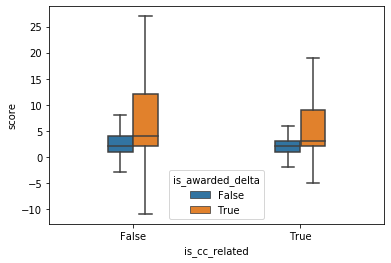

In [51]:
# Is score of a comment related to whether or not it gets a delta?
to_plot_df = pd.DataFrame({
    'is_awarded_delta': [utt.meta['is_awarded_delta']
                        for utt in filtered_cmv_subsample.iter_utterances()],
    'score': [utt.meta['score']
                        for utt in filtered_cmv_subsample.iter_utterances()],
    'is_cc_related': [utt.meta['is_cc_related']
                        for utt in filtered_cmv_subsample.iter_utterances()]
})

sns.boxplot(data=to_plot_df, x='is_cc_related', y='score', showfliers=False, width=0.3,
           hue='is_awarded_delta')

##### RQ3: Do emotions matter for deltas?

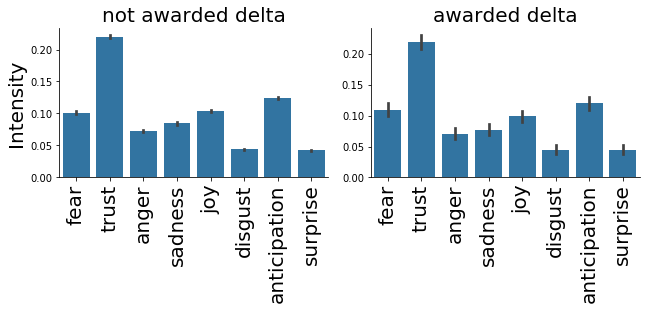

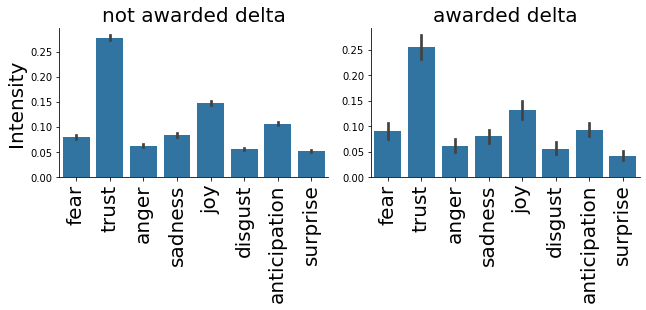

In [142]:
for corp_name in ['matched_cc_cmv_subsample']:#corp_to_analyze:

    years = list(range(2013,2022))
    topics = ['climate change','other']
    emotions = EMOLEX_EMOS
    for model_name in ['all','adxs_only']:
        df_year, df_topic, df_emo, df_emoscore = [], [], [], []
        df_id, df_contro, df_replies, df_score = [], [], [], []
        df_nrc_arousal, df_pos_arousal, df_neg_arousal = [], [], []
        df_delta = []
        for utt in corp_to_analyze[corp_name].iter_utterances():
            year = datetime.utcfromtimestamp(utt.timestamp).year
            topic = 'climate change' if utt.meta['is_cc_related'] else 'other'
            for key in utt.meta.keys():
                if key.startswith(f'emolex_{model_name}'):
                    emo = key.split('_')[-1]
                    score = utt.meta[f'emolex_{model_name}_{emo}']
                    df_year.append(year)
                    df_topic.append(topic)
                    df_emo.append(emo)
                    df_emoscore.append(score)
                    df_id.append(utt.id)
                    df_contro.append(utt.meta['controversiality'])
                    df_replies.append(len(utt.meta['reply_ids']))
                    df_score.append(utt.meta['score'])
                    df_nrc_arousal.append(utt.meta[f'nrc_{model_name}_arousal_cat'])
                    senti_cat = utt.meta[f'senti_{model_name}_arousal_cat']
                    df_pos_arousal.append(senti_cat.split('_pos')[0].split('_')[-1])
                    df_neg_arousal.append(senti_cat.split('_neg')[0].split('_')[-1])
                    df_delta.append(utt.meta['is_awarded_delta'])
        to_plot_df = pd.DataFrame({
            'year':df_year,
            'topic':df_topic,
            'emotion':df_emo,
            'emoscore':df_emoscore,
            'id':df_id,
            'contro':df_contro,
            'num_replies':df_replies,
            'score':df_score,
            'nrc_arousal':df_nrc_arousal,
            'pos_arousal':df_pos_arousal,
            'neg_arousal':df_neg_arousal,
            'is_awarded_delta':df_delta
        })

#         g = sns.FacetGrid(to_plot_df, col="is_awarded_delta", row="emotion", sharey=False, aspect=1.5)
#         g.map(sns.histplot, "emoscore")
        
        g = sns.FacetGrid(to_plot_df, col="is_awarded_delta", sharey=False, aspect=1.5)
        g.map(sns.barplot, "emotion", "emoscore", order=EMOLEX_EMOS)
        for ax_ix,ax in enumerate(g.axes[0]):
            ax.set_xticklabels(ax.get_xticklabels(),rotation=90,fontsize=20)
            ax.set_xlabel("")
            if ax_ix == 0:
                ax.set_ylabel("Intensity",fontsize=20)
            ax.set_title("not "[:4*(not (ax.get_title().split(' = ')[-1] == 'True'))] \
                         + "awarded delta",fontsize=20)
        plt.savefig(f'figs/emo_dist_deltas_v_no_deltas_{corp_name}_{model_name}.png',
                    dpi=150,bbox_inches="tight")

### General LOR

In [172]:
fw_all = FightingWords()
fw_no_bots = FightingWords()
fw_no_generic_utts = FightingWords()

Initializing default CountVectorizer with ngram_range (1, 3)... Done.
Initializing default CountVectorizer with ngram_range (1, 3)... Done.
Initializing default CountVectorizer with ngram_range (1, 3)... Done.


In [177]:
successful_utt_ids = [utt.id for utt in corpus.iter_utterances()
                     if utt.meta['is_cc_related'] 
                      and utt.meta['is_awarded_delta']]
len(successful_utt_ids)

316

In [178]:
pd.DataFrame({
    'id':successful_utt_ids,
    'text':[corpus.get_utterance(i).text 
           for i in successful_utt_ids]
})

,id,text
0,t1_fai041n,"Her goal is *not* to change the minds of people that disagree with climate change. \n\nFor the most part, that's impossible.\n\nHer goal is to galvanize the people that *agree* with the scientific consensus to organize and fight for action. \n\nWho cares what skeptics and deniers think? They're wrong and they will continue to be wrong. What matters is how hard the majority that believes in science will fight. \n\nI would argue that she's been very effective at that."
1,t1_cfs92i3,"But what if we're not far from a clean coal technology that is better than, say, burning oil or natural gas? Or what if people just use power from oil-burning factories instead? Whatever they use, as population and wealth grows, people will want to consume more energy, so even if the source is a bit cleaner than coal currently is, this can still be a problem. Also, there are some good reasons to think that [reducing consumption of meat](http://www.pbjcampaign.org/) is the most effective way to reduce climate-change-inducing pollution.\n\nThe point being, simply shutting down coal plants may be a good way to cut pollution, but it's not the best way. The best way would be to simply tax pollutants. This creates incentive for energy producers to find cleaner and more efficient ways to produce energy, regardless of whatever the method will be (and we can't predict ahead of time what those methods will be!). And it allows consumers to adjust their energy consumption in the way they each find least burdensome given each person's unique preferences, rather than forcing one way on everyone. [This NYTimes article](http://www.nytimes.com/2013/09/01/business/a-carbon-tax-that-america-could-live-with.html) elaborates further."
2,t1_f99227z,"So i think the reason many people think that socialism will help with climate change is the follows:\n\nSocialist lefties are pro climate activism, they view the industrial complex as the main source of pollution, and if they come to power, and have majority, enough to take over the means of production from individuals, they will have the power to stop the industrial complex from polluting for personal gain."
3,t1_f83z8zi,"There should be some burden, but it doesn't have to be huge. Anyone can shell out a few bucks for some reusable coffee cups. We can all benefit from eating less meat products. It's not a huge inconvenience for us to choose a shared Uber or public transportation. \n\nIf we all take a few small steps, it'll add up."
4,t1_ha1wfoj,You're demanding an experiment for what exactly? This is a question of multiple experiments.\n\nCan we experimentally prove that CO2 concentrations in the atmosphere insulate more solar radiation? Yes. \n\nCan we prove that more insulated solar radiation increase temperatures? Yes.\n\nCan we prove humanity releases inordinate amounts of CO2? Yes.\n\nWhich of these are you saying haven't been proven experimentally?
...,...,...
311,t1_du6w5dd,"I'm a climate scientist. I've worked on the National Climate Assessment and I do a ton of outreach to groups to explain the science to them. I'll do my best.\n\n> Please don’t resort to logical fallacies such as 97% of scientists confirm this(appeal to authority) or what not.\n\nI agree, that proves nothing about the science, but it does rebut a claim we often hear that ""the science isn't settled"" like it's some major point of contention within climate science. It's not. \n\n> Our models still give us only partially accurate short term weather predictions and climate change takes decades and has more unpredictable variables than weather.\n\nPredicting the weather and predicting the climate are entirely different beasts. Short-term prediction is about sorting through that chaos and saying ""This is how Thursday is gonna be."" Climate isn't actually that affected by chaos, because we're talking about long-term statistics, and all of that noise is filtered out. We're not saying ""The high temperature in NYC on October 12, 2048

In [173]:
fw_all.fit(corpus, 
        class1_func = lambda utt: (utt.meta['is_awarded_delta'] == 1)\
           and (utt.meta['is_cc_related']),
       class2_func = lambda utt: (utt.meta['is_awarded_delta'] == 0)\
          and (utt.meta['is_cc_related']))

class1_func returned 316 valid corpus components. class2_func returned 24798 valid corpus components.
Vocab size is 15000
Comparing language...
ngram zscores computed.


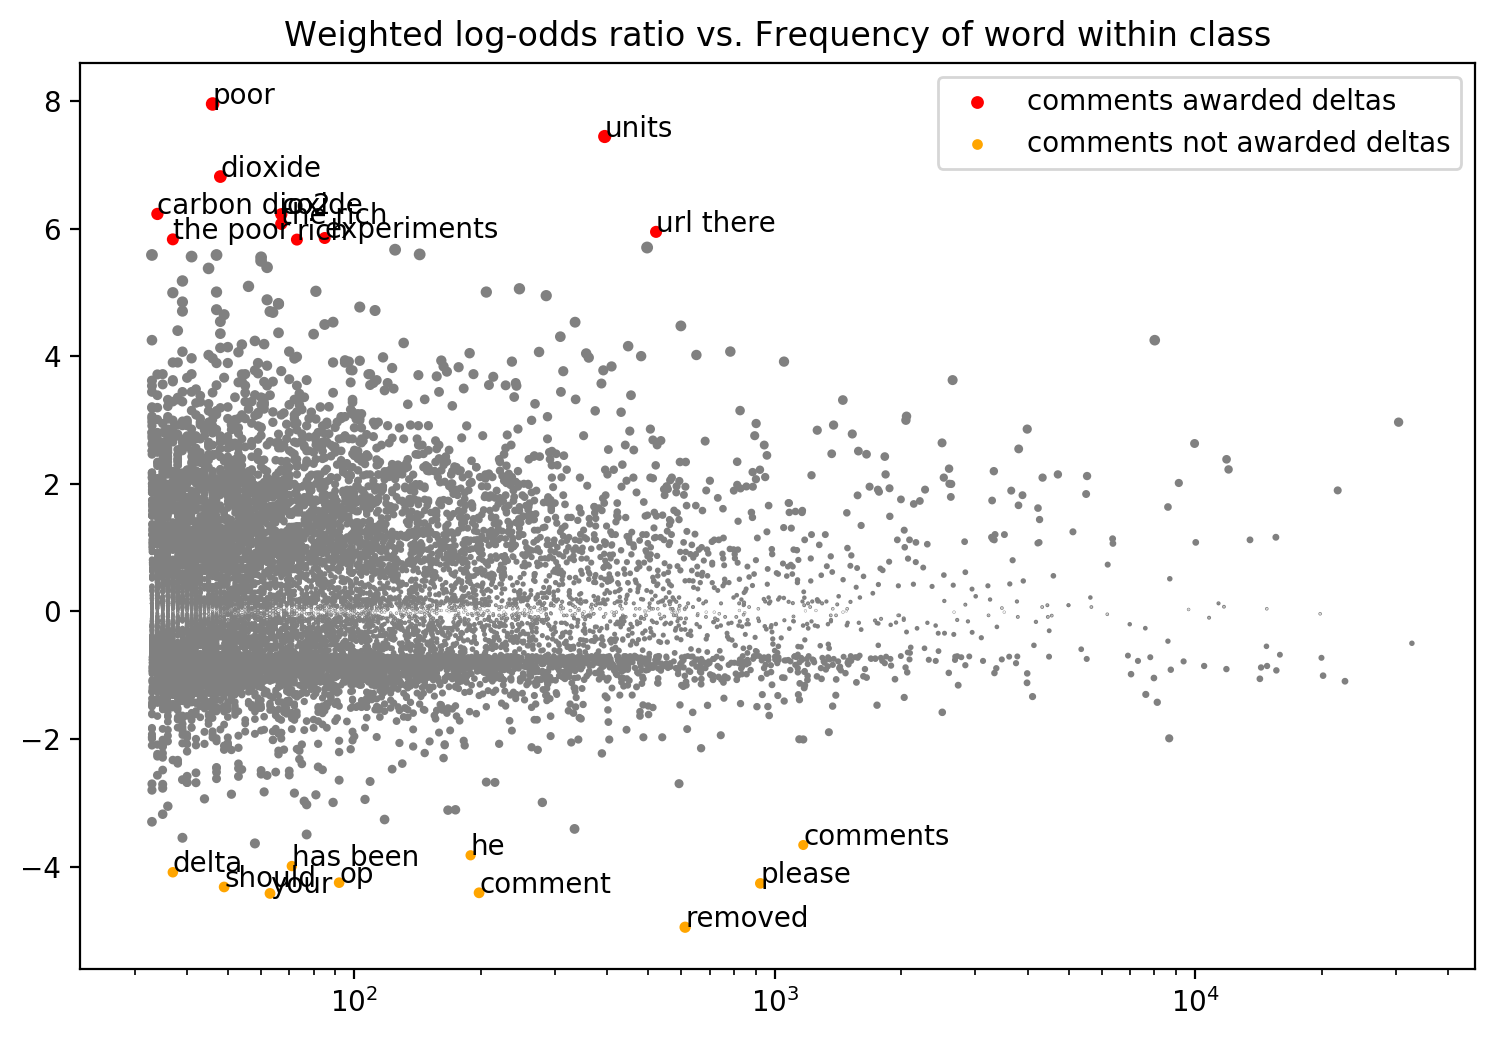

In [174]:
df_all = fw_all.summarize(corpus, plot=True, 
                  class1_name='comments awarded deltas', 
                    class2_name='comments not awarded deltas')

In [175]:
df_all.sort_values('z-score',ascending=False).head(20)

,z-score,class
ngram,,
poor,7.952880,comments awarded deltas
units,7.442983,comments awarded deltas
dioxide,6.815170,comments awarded deltas
carbon dioxide,6.229400,comments awarded deltas
co2,6.224359,comments awarded deltas
the rich,6.074059,comments awarded deltas
url there,5.948274,comments awarded deltas
experiments,5.852355,comments awarded deltas
the poor,5.830947,comments awarded deltas


In [36]:
df_all.sort_values('z-score',ascending=False).head(20)

,z-score,class
ngram,,
url,8.159434,comments awarded deltas
price,5.007118,comments awarded deltas
wiki,4.684719,comments awarded deltas
carbon taxes,4.506498,comments awarded deltas
the us,4.387404,comments awarded deltas
taxes,4.353331,comments awarded deltas
delta,4.014703,comments awarded deltas
christian,3.990494,comments awarded deltas
cur,3.974307,comments awarded deltas


In [26]:
fw_no_bots.fit(corpus, 
    class1_func = lambda utt: (not utt.meta['written_by_bot']) and (utt.meta['is_awarded_delta'] == 1)\
        and (utt.meta['is_cc_related']),
    class2_func = lambda utt: (not utt.meta['written_by_bot']) and (utt.meta['is_awarded_delta'] == 0)\
        and (utt.meta['is_cc_related']))

class1_func returned 7948 valid corpus components. class2_func returned 16686 valid corpus components.
Vocab size is 15000
Comparing language...
ngram zscores computed.


In [35]:
# df_no_bots = fw_no_bots.summarize(corpus, plot=True, 
#                   class1_name='comments awarded deltas', class2_name='comments not awarded deltas')

In [28]:
df_no_bots.sort_values('z-score',ascending=False).head(20)

,z-score,class
ngram,,
your comment,14.506357,comments awarded deltas
rule,13.996509,comments awarded deltas
clicking,13.927992,comments awarded deltas
by clicking,13.894580,comments awarded deltas
has been removed,13.771117,comments awarded deltas
clicking this link,13.562254,comments awarded deltas
clicking this,13.562254,comments awarded deltas
the moderators by,13.562254,comments awarded deltas
by clicking this,13.562254,comments awarded deltas


In [36]:
# fw_no_generic_utts.fit(corpus, 
#     class1_func = lambda utt: (~utt.meta['is_generic']) and (utt.meta['is_awarded_delta'] == 1)\
#         and (utt.meta['is_cc_related']),
#     class2_func = lambda utt: (~utt.meta['is_generic']) and (utt.meta['is_awarded_delta'] == 0)\
#         and (utt.meta['is_cc_related']))

In [37]:
# df_no_generic = fw_no_generic_utts.summarize(corpus, plot=True, 
#                   class1_name='comments awarded deltas', class2_name='comments not awarded deltas')

In [32]:
df_no_generic.sort_values('z-score',ascending=False).head(20)

,z-score,class
ngram,,
delta,25.117795,comments awarded deltas
explained,20.970349,comments awarded deltas
wiki,20.947304,comments awarded deltas
comments,18.189741,comments awarded deltas
url,17.828676,comments awarded deltas
awarded,16.926767,comments awarded deltas
user,15.951246,comments awarded deltas
your comment,15.176900,comments awarded deltas
note that,15.157092,comments awarded deltas


In [ ]:
# TO DO: better recall in filtering out generic comments

# TO DO: filter by stance

In [ ]:
# plot LOR but single out (high) affect-related words


### LOR: words from specific lexicons

In [19]:
# plot LOR but single out words from specific lexicons
PATH_TO_EMOLEX = "/u/scr/yiweil/datasets/NRC-Emotion-Intensity-Lexicon-v1.txt"
EMOLEX = pd.read_csv(PATH_TO_EMOLEX,sep='\t')
EMOLEX.head()

print(EMOLEX[
    'emotion'
].value_counts())

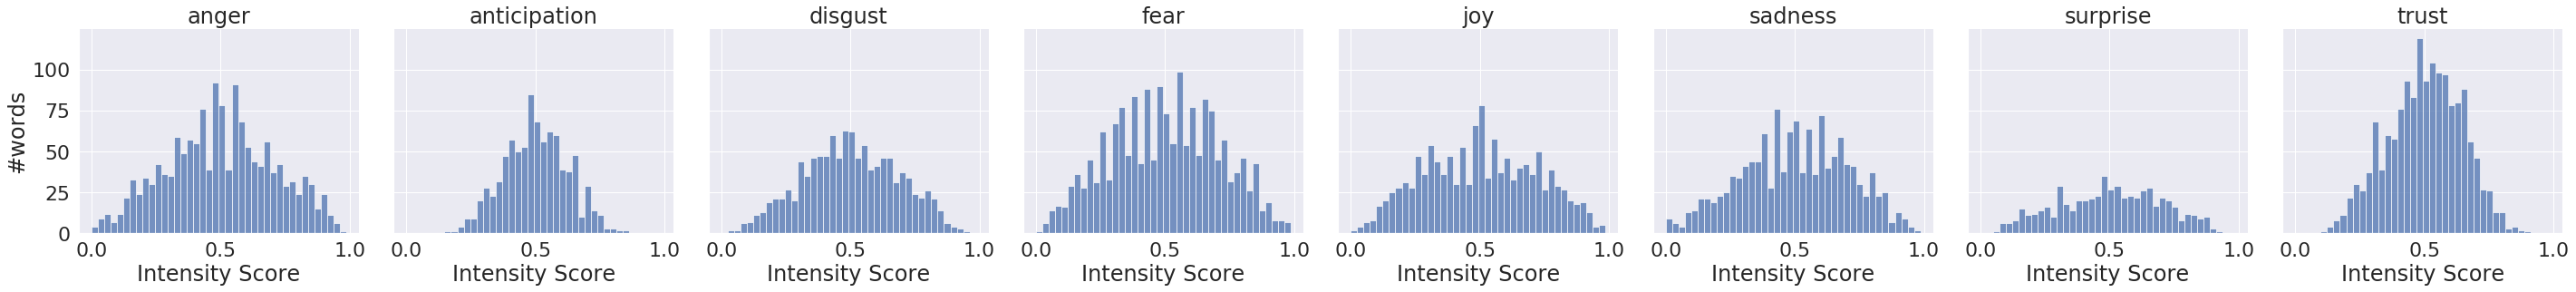

In [28]:
# Plot intensity scores for each emotion category
sns.set(font_scale=2)

g = sns.displot(data=EMOLEX,x='emotion-intensity-score',col='emotion')
g.set_titles("{col_name}")
g.set_axis_labels("Intensity Score", "#words")
if not os.path.exists('figs/'):
    os.mkdir('figs/')
g.savefig("figs/emolex_intensity_per_emotion.png")

In [47]:
# Distribution is pretty normal
# Let's threshold to 1.5 stds above the mean to obatin high intensity words in each category
per_emotion_means = EMOLEX.groupby('emotion').mean()
per_emotion_stds = EMOLEX.groupby('emotion').std()

EMOLEX['is_high_intensity'] = EMOLEX.apply(
    lambda x: x['emotion-intensity-score'] >= per_emotion_means['emotion-intensity-score'][x['emotion']], axis=1
)

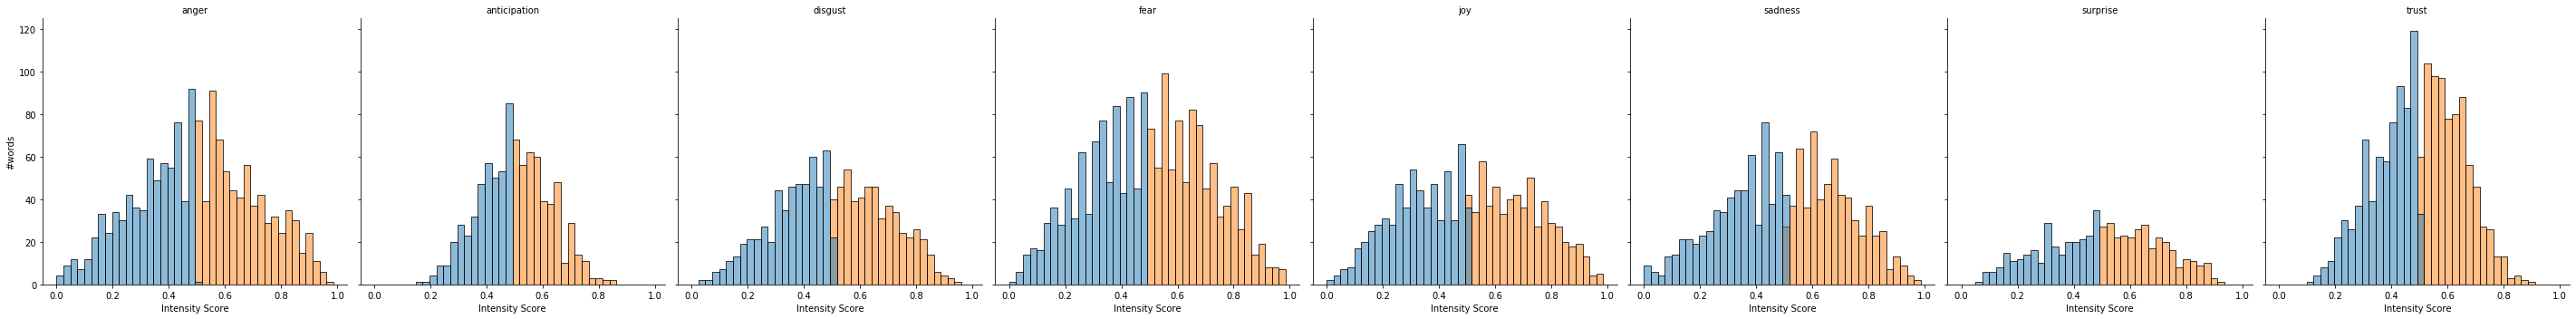

In [48]:
g = sns.displot(data=EMOLEX,x='emotion-intensity-score',hue='is_high_intensity',col='emotion')
g.set_titles("{col_name}")
g.set_axis_labels("Intensity Score", "#words")
g._legend.remove()

if not os.path.exists('figs/'):
    os.mkdir('figs/')
g.savefig("figs/emolex_intensity_per_emotion.png")

In [31]:
EMOLEX.loc[(EMOLEX['is_high_intensity']) & 
          (EMOLEX['emotion']=='joy')]['word'].values

array(['happiest', 'happiness', 'bliss', 'celebrating', 'jubilant',
       'ecstatic', 'elation', 'beaming', 'bestdayever', 'loveee',
       'celebration', 'awesomeness', 'joy', 'excitement', 'joyous',
       'happily', 'exuberance', 'makesmehappy', 'euphoria', 'fabulous',
       'lovee', 'gratitude', 'merriment', 'spectacular', 'happydance',
       'purebliss', 'overjoyed', 'triumphant', 'cheerful', 'lovelovelove',
       'ecstasy', 'cheer', 'elated', 'delighted', 'exhilaration',
       'peaceofmind', 'jolly', 'lovethis', 'excitation', 'pleasures',
       'laugh', 'marvelously', 'loving', 'blissful', 'joyful',
       'outstanding', 'pleasurable', 'yaaaay', 'happyplace',
       'overthemoon', 'glee', 'enthusiastic', 'lovinglife', 'iloveher',
       'sohappy', 'laughing', 'superb', 'woohoo', 'wonderful',
       'ilovechristmas', 'cheering', 'magnificent', 'celebrated',
       'hooray', 'loved', 'brilliant', 'hallelujah', 'tearsofjoy',
       'yayyyy', 'glory', 'heavenly', 'exciting', 't

In [49]:
#import importlib
os.chdir('../1_data_collection/reddit/convokit')
#import customized_fighting_words
import importlib
importlib.reload(customized_fighting_words)
from customized_fighting_words import FightingWords
os.chdir(og_dir)

In [50]:
fw_all = FightingWords()
fw_all.fit(corpus, class1_func = lambda utt: (utt.meta['is_awarded_delta'] == 1)\
           and (utt.meta['is_cc_related']),
       class2_func = lambda utt: (utt.meta['is_awarded_delta'] == 0)\
          and (utt.meta['is_cc_related']))

Initializing default CountVectorizer with ngram_range (1, 3)... Done.
class1_func returned 8414 valid corpus components. class2_func returned 16700 valid corpus components.
Vocab size is 15000
Comparing language...
ngram zscores computed.


In [ ]:
# Distribution of z-scores for high and low intensity words
sns.displot(data=df_all,x=)

In [285]:
# # no annotations of words or non-of-interest words--too crowded
# fw_all.plot_fighting_words_fancy(class1_name='high intensity emotion words', 
#                                  class2_name='low intensity emotion words', 
#                                  config={'threshold': 1.96, 'annot_method': 'custom'},
#                                 word_set1=set(EMOLEX.loc[(EMOLEX['is_high_intensity'])]['word'].values),
#                                 word_set2=set(EMOLEX.loc[~EMOLEX['is_high_intensity']]['word'].values),
#                                 verbose=True)

In [284]:
# fw_all.plot_fighting_words_fancy(class1_name='high intensity emotion words', 
#                                  class2_name='low intensity emotion words', 
#                                  config={'threshold': 1.96, 'annot_method': 'custom'},
#                                 word_set1=set(EMOLEX.loc[(EMOLEX['is_high_intensity'])]['word'].values),
#                                 word_set2=set(EMOLEX.loc[~EMOLEX['is_high_intensity']]['word'].values),
#                                 verbose=True)

In [283]:
# df_all.loc[df_all.index.isin(set(EMOLEX.loc[(EMOLEX['is_high_intensity']) & 
#           (EMOLEX['emotion']=='joy')]['word'].values))].sort_values('z-score',ascending=False).head(20)

In [282]:
# df_all.loc[df_all.index.isin(set(EMOLEX.loc[(EMOLEX['is_high_intensity']) & 
#           (EMOLEX['emotion']=='anger')]['word'].values))].sort_values('z-score',ascending=False).head(20)

In [281]:
# df_all.loc[df_all.index.isin(set(EMOLEX.loc[(EMOLEX['is_high_intensity']) & 
#           (EMOLEX['emotion']=='disgust')]['word'].values))].sort_values('z-score',ascending=False).head(20)

In [280]:
# df_all.loc[df_all.index.isin(set(EMOLEX.loc[(EMOLEX['is_high_intensity']) & 
#           (EMOLEX['emotion']=='fear')]['word'].values))].sort_values('z-score',ascending=False).head(20)

In [279]:
# df_all.loc[df_all.index.isin(set(EMOLEX.loc[(EMOLEX['is_high_intensity']) & 
#           (EMOLEX['emotion']=='sadness')]['word'].values))].sort_values('z-score',ascending=False).head(20)

In [278]:
# df_all.loc[df_all.index.isin(set(EMOLEX.loc[(EMOLEX['is_high_intensity']) & 
#           (EMOLEX['emotion']=='surprise')]['word'].values))].sort_values('z-score',ascending=False).head(20)

# Hypothesis: engaging with opponent is good strategy (agree > disagree chains)

Already tested in other paper and found to be ineffective.

# Topic analysis

## Why do "doom people" think we're doomed?